In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
from itertools import product


load_dotenv()

True

In [3]:
# Carregar variáveis de ambiente
load_dotenv()

path_dados_tratados = os.getenv('PATH_DADOS_TRATADOS')

resultado_bruto = pd.read_csv(f"{path_dados_tratados}resultado_bruto.csv", index_col=0, parse_dates=True)
lucro_consolidado = pd.read_csv(f"{path_dados_tratados}lucro_consolidado.csv", index_col=0, parse_dates=True)
despesas_operacionais = pd.read_csv(f"{path_dados_tratados}despesas_operacionais.csv", index_col=0, parse_dates=True)
input_receita = {}
exog_vars_estac_lags = {}
dados_indices = {}
for empresa in resultado_bruto.columns:
    input_receita[empresa] = pd.read_csv(f"{path_dados_tratados}input_receita_{empresa}.csv", index_col=0, parse_dates=True)
    input_receita[empresa].index = pd.to_datetime(input_receita[empresa].index, format='%Y-%m-%d')
    exog_vars_estac_lags[empresa] = pd.read_csv(f"{path_dados_tratados}exog_vars_estac_lags_{empresa}.csv", index_col=0, parse_dates=True)
    exog_vars_estac_lags[empresa].index = pd.to_datetime(exog_vars_estac_lags[empresa].index, format='%Y-%m-%d')
    dados_indices[empresa] = pd.read_csv(f"{path_dados_tratados}dados_indices.csv", index_col=1, parse_dates=True, sep=';')
    dados_indices[empresa].drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
exog_vars_filtered = exog_vars_estac_lags['21490'][['Energia Ind.', 'INCC-Brasil-DI', 'IPAOG-DI', 'Juros EUA', 'PIB Corrente',
                                                    'Vol. Impostos','Vol. PIB Mensal', 'Vol. VA Agro Sazonal', 'Vol. VA Agro Trim. Saz.',
                                                    'Vol. VA Ind. Sazonal', 'Vol. VA Ind. Trim. Saz.', 'Vol. VA Serviços', 'ibov', 'iee', 'igpm']]

exog_vars_estac_lags[empresa] = exog_vars_estac_lags[empresa].loc[:, ~exog_vars_estac_lags[empresa].columns.str.contains('Data', case=False)]

Gerar 1 indicador de 1 empresa

In [7]:
def discretizar_receita(valor_percentual):
    # # valor_percentual deve estar em decimal (ex: 0.50 para 50%)
    # if valor_percentual > 1.0: return 0        # > +100%
    # if 0.5 < valor_percentual <= 1.0: return 1 # 50% a 100%
    # if 0.3 < valor_percentual <= 0.5: return 2 # 30% a 50%
    # if 0.1 < valor_percentual <= 0.3: return 3 # 10% a 30%
    # if 0.0 <= valor_percentual <= 0.1: return 4 # 0% a 10%
    # if -0.1 <= valor_percentual < 0.0: return 5 # > -10% (0 a -10)
    # if -0.3 <= valor_percentual < -0.1: return 6 # -10% a -30%
    # if -0.5 <= valor_percentual < -0.3: return 7 # -30% a -50%
    # if -1.0 <= valor_percentual < -0.5: return 8 # -50% a -100%
    # return 9                                    # < -100%
    return 0 if valor_percentual > 0 else 1

Modelo convergiu? True
Log-Likelihood final: -35.10


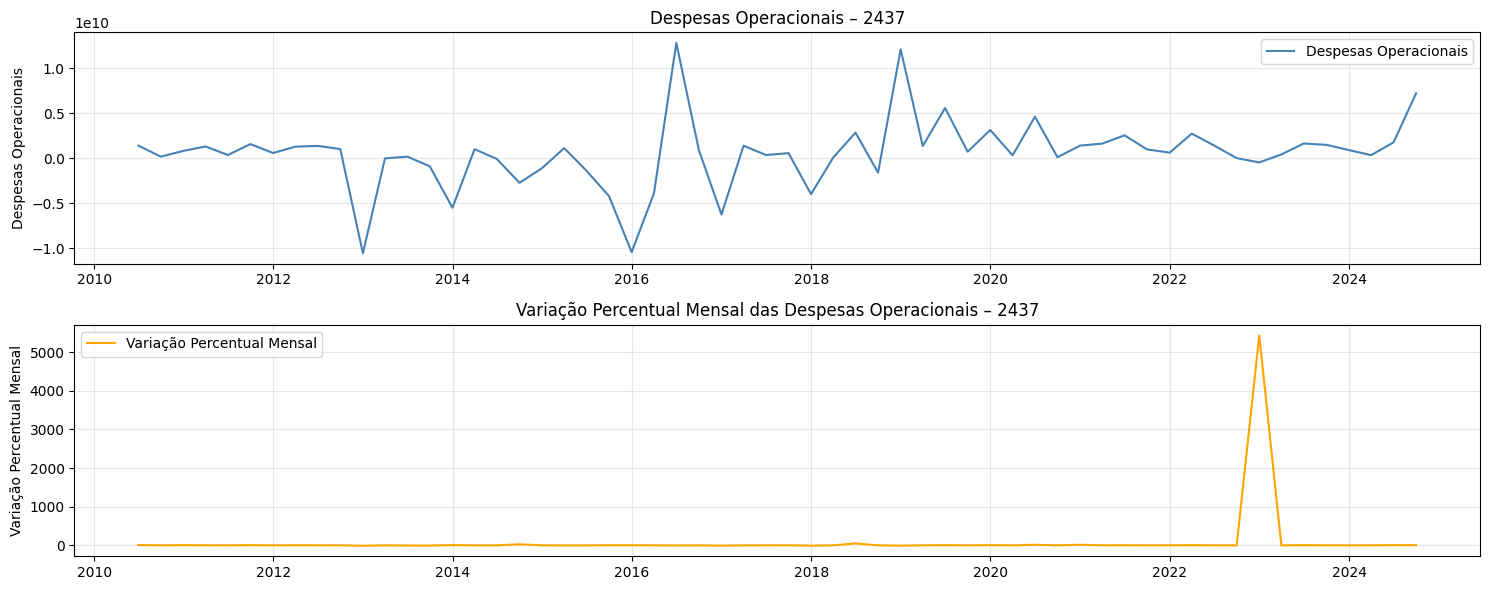


--- Matriz de Transição ---
[[0.012 0.538 0.45 ]
 [0.947 0.    0.053]
 [0.001 0.911 0.088]]

--- Matriz de Emissão ---
[[0.448 0.552]
 [0.    1.   ]
 [1.    0.   ]]


In [8]:
# Configurações do Modelo
N_ESTADOS = 3 # S: Alta (0), Estabilidade (1), Crise (2)
N_OBSERVACOES = 2

empresa_hmm = '2437'  # ajuste conforme necessário

serie_receita = (
    lucro_consolidado[empresa_hmm]
    .sort_index()
    .astype(float)
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

serie_pct = serie_receita.pct_change().dropna()
obs_index = serie_pct.index
obs_sequencia = serie_pct.apply(discretizar_receita).to_numpy().reshape(-1, 1)

model_aprendido = hmm.CategoricalHMM(
    n_components=N_ESTADOS,
    n_iter=100,
    random_state=1
)
model_aprendido.fit(obs_sequencia)

print(f"Modelo convergiu? {model_aprendido.monitor_.converged}")
print(f"Log-Likelihood final: {model_aprendido.monitor_.history[-1]:.2f}")

logprob, estados_preditos = model_aprendido.decode(obs_sequencia)

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(obs_index, serie_receita.loc[obs_index], color='steelblue', label='Despesas Operacionais')
plt.ylabel('Despesas Operacionais')
plt.title(f'Despesas Operacionais – {empresa_hmm}')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(obs_index, serie_pct.loc[obs_index], color='orange', label='Variação Percentual Mensal')
plt.ylabel('Variação Percentual Mensal')
plt.title(f'Variação Percentual Mensal das Despesas Operacionais – {empresa_hmm}')
plt.grid(True, alpha=0.3)
plt.legend()

# plt.subplot(2, 1, 3)
# plt.step(obs_index, estados_preditos, where='mid', color='crimson', label='Estados Viterbi')
# plt.yticks([0, 1, 3], ['Alta', 'Estável', 'Crise'])
# plt.xlabel('Tempo')
# plt.title('Estados Ocultos Estimados')
# plt.grid(True, alpha=0.3)
# plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Matriz de Transição ---")
print(model_aprendido.transmat_.round(3))

print("\n--- Matriz de Emissão ---")
print(model_aprendido.emissionprob_.round(3))
# ...existing code...

In [9]:
serie_pct.loc[obs_index]

DT_FIM_EXERC
2010-06-30       6.283623
2010-09-30      -0.882623
2010-12-31       3.934890
2011-03-31       0.598351
2011-06-30      -0.730701
2011-09-30       3.490075
2011-12-31      -0.635763
2012-03-31       1.241670
2012-06-30       0.064825
2012-09-30      -0.258446
2012-12-31     -11.507696
2013-03-31      -0.996790
2013-06-30      -5.979992
2013-09-30      -6.439764
2013-12-31       5.000484
2014-03-31      -1.180266
2014-06-30      -1.100702
2014-09-30      26.427424
2014-12-31      -0.594191
2015-03-31      -2.000603
2015-06-30      -2.260805
2015-09-30       2.009262
2015-12-31       1.470469
2016-03-31      -0.626903
2016-06-30      -4.284358
2016-09-30      -0.931581
2016-12-31      -8.151127
2017-03-31      -1.220220
2017-06-30      -0.750324
2017-09-30       0.598869
2017-12-31      -8.267172
2018-03-31      -1.014041
2018-06-30      49.445776
2018-09-30      -1.569737
2018-12-31      -8.482689
2019-03-31      -0.888399
2019-06-30       3.127300
2019-09-30      -0.871268

In [10]:
def hmm_one_step_ahead(serie_receita, n_estados=3, n_iter=100, janela=12):
    serie_pct = (
        serie_receita
        .sort_index()
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .pct_change()
        .dropna()
    )
    obs = serie_pct.apply(discretizar_receita).to_numpy().reshape(-1, 1)
    idx_obs = serie_pct.index
    preds, reals = [], []

    for i in range(janela, len(obs) - 1):
        model = hmm.CategoricalHMM(n_components=n_estados, n_iter=n_iter, random_state=6)
        model.fit(obs[:i])

        estados = model.predict(obs[:i])
        estado_atual = estados[-1]

        probs_prox_obs = model.transmat_[estado_atual] @ model.emissionprob_
        prox_simbolo = int(np.argmax(probs_prox_obs))

        preds.append(prox_simbolo)
        reals.append(int(obs[i][0]))

    df_res = pd.DataFrame(
        {"real": reals, "previsto": preds},
        index=idx_obs[janela:-1]
    )
    acuracia = accuracy_score(reals, preds)
    return df_res, acuracia
# ...existing code...

In [11]:
for empresa in resultado_bruto.columns:

    df_prev, acc = hmm_one_step_ahead(despesas_operacionais[empresa], janela=19)
    print(f"Empresa: {empresa}, Acurácia: {acc}")
    #display(df_prev)

Empresa: 2437, Acurácia: 0.631578947368421
Empresa: 18376, Acurácia: 0.7894736842105263
Empresa: 20257, Acurácia: 0.5263157894736842
Empresa: 21490, Acurácia: 0.7368421052631579


GRID_SEARCH 1 indicador 1 empresa - categorical HMM

In [14]:
def discretizar_receita_parametrizada(valor_percentual, n_bins=2):
    """Discretiza com número variável de bins"""
    if n_bins == 2:
        return 0 if valor_percentual > 0 else 1
    elif n_bins == 3:
        if valor_percentual > 0.1: return 0
        if -0.1 <= valor_percentual <= 0.1: return 1
        return 2
    elif n_bins == 4:
        if valor_percentual > 0.2: return 0
        if 0 < valor_percentual <= 0.2: return 1
        if -0.2 <= valor_percentual <= 0: return 2
        return 3
    elif n_bins == 5:
        if valor_percentual > 0.3: return 0
        if 0.1 < valor_percentual <= 0.3: return 1
        if -0.1 <= valor_percentual <= 0.1: return 2
        if -0.3 <= valor_percentual < -0.1: return 3
        return 4
    elif n_bins == 10:
        if valor_percentual > 1.0: return 0
        if 0.5 < valor_percentual <= 1.0: return 1
        if 0.3 < valor_percentual <= 0.5: return 2
        if 0.1 < valor_percentual <= 0.3: return 3
        if 0.0 <= valor_percentual <= 0.1: return 4
        if -0.1 <= valor_percentual < 0.0: return 5
        if -0.3 <= valor_percentual < -0.1: return 6
        if -0.5 <= valor_percentual < -0.3: return 7
        if -1.0 <= valor_percentual < -0.5: return 8
        return 9
    else:
        # Fallback: discretização uniforme
        percentis = np.linspace(-1, 1, n_bins + 1)
        for i in range(n_bins):
            if percentis[i] <= valor_percentual < percentis[i + 1]:
                return i
        return n_bins - 1

def hmm_grid_search(serie_receita, estados_range=(2, 6), bins_range=(2, 11), janela=12, n_iter=100, random_series=[1,42,6,99,7,150,33,25,21,12,200,2,3,4,5,6]):
    """
    Grid search para HMM variando número de estados e bins de discretização.
    
    Args:
        serie_receita: série temporal de receita
        estados_range: tuple (min, max) para número de estados
        bins_range: tuple (min, max) para número de bins
        janela: tamanho da janela rolling
        n_iter: iterações do algoritmo Baum-Welch
        random_series: lista de seeds para testar
    
    Returns:
        DataFrame com resultados ordenados por acurácia
    """
    resultados = []
    
    serie_pct = (
        serie_receita
        .sort_index()
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .pct_change()
        .dropna()
    )
    
    if len(serie_pct) <= janela:
        raise ValueError("Série insuficiente para janela informada.")
    
    # Gera todas as combinações
    combinacoes = list(product(
        range(estados_range[0], estados_range[1]),
        range(bins_range[0], bins_range[1])
    ))
    
    print(f"Testando {len(combinacoes)} combinações...")
    
    for n_estados, n_bins in combinacoes:
        try:
            # Discretiza com n_bins
            obs = serie_pct.apply(lambda x: discretizar_receita_parametrizada(x, n_bins)).to_numpy().reshape(-1, 1)
            idx_obs = serie_pct.index
            
            # Loop sobre diferentes random_states
            for r in random_series:
                preds, reals = [], []
                
                # Loop de previsões rolling
                for i in range(janela, len(obs)):  
                    history = obs[i - janela:i]
                    
                    model = hmm.CategoricalHMM(
                        n_components=n_estados,
                        n_iter=n_iter,
                        random_state=r,
                        verbose=False
                    )
                    model.fit(history)
                    
                    estado_atual = model.predict(history)[-1]
                    probs_prox_obs = model.transmat_[estado_atual] @ model.emissionprob_
                    prox_simbolo = int(np.argmax(probs_prox_obs))
                    
                    preds.append(prox_simbolo)
                    reals.append(int(obs[i][0]))
                
                # Calcula acurácia APÓS todas as previsões
                acuracia = accuracy_score(reals, preds)
                
                # Armazena resultado UMA VEZ por combinação
                resultados.append({
                    'n_estados': n_estados,
                    'n_bins': n_bins,
                    'random_state': r,
                    'acuracia': acuracia,
                    'n_previsoes': len(preds)
                })
                
                print(f"Estados={n_estados}, Bins={n_bins}, Seed={r} → Acurácia={acuracia:.4f} ({len(preds)} previsões)")
            
        except Exception as e:
            print(f"Erro com Estados={n_estados}, Bins={n_bins}: {str(e)}")
            continue
    
    df_resultados = pd.DataFrame(resultados).sort_values('acuracia', ascending=False)
    return df_resultados

In [22]:
# Teste para uma empresa
empresa_teste = '18376'
resultados_grid = hmm_grid_search(
    resultado_bruto[empresa_teste],
    estados_range=(2,5),
    bins_range=(3,5),
    janela=18
)

print("\n=== Top 10 Melhores Configurações ===")
display(resultados_grid.head(10))

print("\n=== Melhor Configuração ===")
melhor = resultados_grid.iloc[0]
print(f"Estados: {melhor['n_estados']}, Bins: {melhor['n_bins']}, Acurácia: {melhor['acuracia']:.4f}")

Testando 6 combinações...
Estados=2, Bins=3, Seed=1 → Acurácia=0.1500 (40 previsões)
Estados=2, Bins=3, Seed=42 → Acurácia=0.2250 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=99 → Acurácia=0.2000 (40 previsões)
Estados=2, Bins=3, Seed=7 → Acurácia=0.2500 (40 previsões)
Estados=2, Bins=3, Seed=150 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=33 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=25 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=21 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=12 → Acurácia=0.1500 (40 previsões)
Estados=2, Bins=3, Seed=200 → Acurácia=0.1000 (40 previsões)
Estados=2, Bins=3, Seed=2 → Acurácia=0.2250 (40 previsões)
Estados=2, Bins=3, Seed=3 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=4 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=5 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=4, S

Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=3, Bins=4, Seed=6 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=1 → Acurácia=0.3750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=42 → Acurácia=0.3750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.3750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=99 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=7 → Acurácia=0.4750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=150 → Acurácia=0.4250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=33 → Acurácia=0.2000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=25 → Acurácia=0.3250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=21 → Acurácia=0.2000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=12 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=200 → Acurácia=0.4250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=2 → Acurácia=0.4000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=3 → Acurácia=0.3250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=4 → Acurácia=0.2250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=5 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.3750 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=1 → Acurácia=0.2000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=42 → Acurácia=0.1500 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=6 → Acurácia=0.3000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=99 → Acurácia=0.3000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=7 → Acurácia=0.3750 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=150 → Acurácia=0.3000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=33 → Acurácia=0.2000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=25 → Acurácia=0.3250 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=21 → Acurácia=0.2500 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=12 → Acurácia=0.2500 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=200 → Acurácia=0.2750 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=2 → Acurácia=0.2500 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=3 → Acurácia=0.2250 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=4 → Acurácia=0.2250 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=5 → Acurácia=0.2000 (40 previsões)


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=4, Seed=6 → Acurácia=0.3000 (40 previsões)

=== Top 10 Melhores Configurações ===


n_estados  n_bins  random_state  acuracia  n_previsoes
68          4       3             7     0.475           40
43          3       3             2     0.450           40
74          4       3           200     0.425           40
45          3       3             4     0.425           40
69          4       3           150     0.425           40
75          4       3             2     0.400           40
39          3       3            25     0.375           40
84          4       4             7     0.375           40
41          3       3            12     0.375           40
47          3       3             6     0.375           40


=== Melhor Configuração ===
Estados: 4.0, Bins: 3.0, Acurácia: 0.4750


Comparação dos estados entre os 3 indicadores da mesma empresa


--- Processando Resultado Bruto ---
Shape:  (58, 1)
Convergiu: True
Log-Likelihood: -34.33

--- Processando Lucro Consolidado ---
Shape:  (58, 1)
Convergiu: True
Log-Likelihood: -36.27

--- Processando Despesas Operacionais ---
Shape:  (58, 1)
Convergiu: True
Log-Likelihood: -27.24


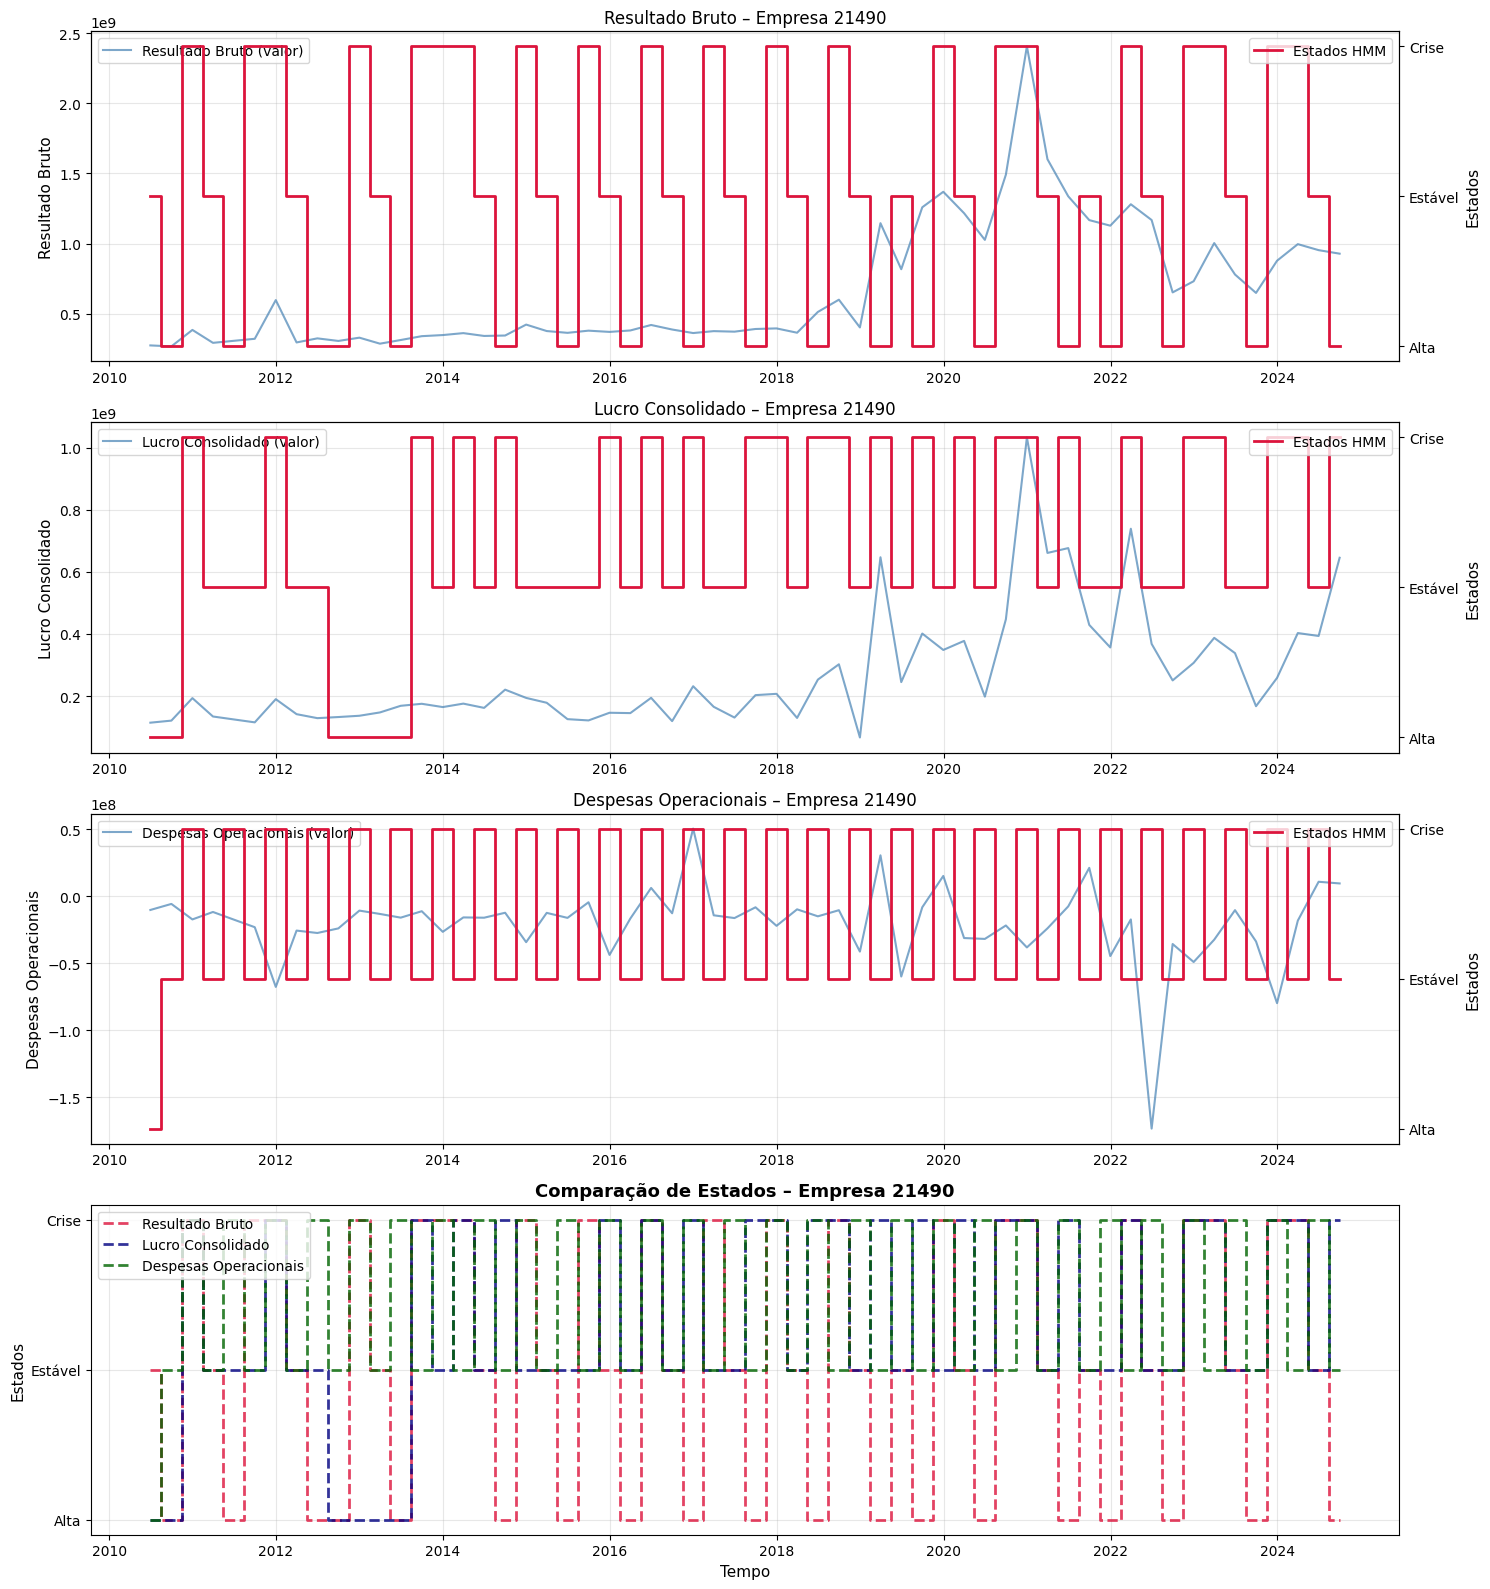


RESUMO DOS MODELOS HMM

Resultado Bruto:
  Convergiu: True
  Log-Likelihood: -34.33
  Número de observações: 58

  Matriz de Transição:
[[0.171 0.081 0.747]
 [0.969 0.    0.031]
 [0.    0.747 0.252]]

  Matriz de Emissão:
[[0.488 0.512]
 [0.    1.   ]
 [1.    0.   ]]

Lucro Consolidado:
  Convergiu: True
  Log-Likelihood: -36.27
  Número de observações: 58

  Matriz de Transição:
[[0.444 0.    0.556]
 [0.09  0.338 0.572]
 [0.002 0.771 0.227]]

  Matriz de Emissão:
[[0.984 0.016]
 [0.    1.   ]
 [0.98  0.02 ]]

Despesas Operacionais:
  Convergiu: True
  Log-Likelihood: -27.24
  Número de observações: 58

  Matriz de Transição:
[[0.    1.    0.   ]
 [0.062 0.    0.938]
 [0.    1.    0.   ]]

  Matriz de Emissão:
[[0.008 0.992]
 [0.103 0.897]
 [0.723 0.277]]


In [52]:
# ...existing code...
def analisar_multiplos_indicadores_hmm(empresa, indicadores_dict, n_estados=3, n_bins=2, n_iter=100):
    """
    Treina modelos HMM para múltiplos indicadores da mesma empresa e compara estados.
    
    Args:
        empresa: código da empresa
        indicadores_dict: dicionário {'nome': serie_temporal}
        n_estados: número de estados ocultos
        n_bins: número de bins para discretização
        n_iter: iterações do Baum-Welch
    
    Returns:
        dict com modelos, estados e séries processadas
    """
    resultados = {}
    
    for nome_indicador, serie in indicadores_dict.items():
        print(f"\n--- Processando {nome_indicador} ---")
        
        # Prepara série
        serie_limpa = (
            serie
            .sort_index()
            .astype(float)
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
        )
        
        serie_pct = serie_limpa.pct_change().dropna()
        obs_sequencia = serie_pct.apply(
            lambda x: discretizar_receita_parametrizada(x, n_bins)
        ).to_numpy().reshape(-1, 1)
        
        print("Shape: ", np.shape(obs_sequencia))
        # Treina modelo
        model = hmm.CategoricalHMM(
            n_components=n_estados,
            n_iter=n_iter,
            random_state=1
        )
        model.fit(obs_sequencia)
        
        # Decodifica estados
        _, estados_preditos = model.decode(obs_sequencia)
        
        # Armazena resultados
        resultados[nome_indicador] = {
            'serie_original': serie_limpa,
            'serie_pct': serie_pct,
            'estados': estados_preditos,
            'index': serie_pct.index,
            'modelo': model,
            'convergiu': model.monitor_.converged,
            'log_likelihood': model.monitor_.history[-1] if model.monitor_.history else np.nan
        }
        
        print(f"Convergiu: {model.monitor_.converged}")
        print(f"Log-Likelihood: {model.monitor_.history[-1]:.2f}" if model.monitor_.history else "N/A")
    
    return resultados

def plotar_comparacao_estados(resultados, empresa, n_estados=3):
    """
    Plota comparação dos estados de múltiplos indicadores.
    
    Args:
        resultados: dict retornado por analisar_multiplos_indicadores_hmm
        empresa: código da empresa
        n_estados: número de estados para labels
    """
    n_indicadores = len(resultados)
    fig, axes = plt.subplots(n_indicadores + 1, 1, figsize=(15, 4 * (n_indicadores + 1)))
    
    if n_indicadores == 1:
        axes = [axes]
    
    # Plot individual de cada indicador
    for i, (nome, dados) in enumerate(resultados.items()):
        ax = axes[i]
        ax.plot(dados['index'], dados['serie_original'].loc[dados['index']], 
                color='steelblue', label=f'{nome} (valor)', alpha=0.7)
        ax.set_ylabel(nome, fontsize=11)
        ax.set_title(f'{nome} – Empresa {empresa}', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        
        # Eixo secundário para estados
        ax2 = ax.twinx()
        ax2.step(dados['index'], dados['estados'], where='mid', 
                 color='crimson', label='Estados HMM', linewidth=2)
        ax2.set_ylabel('Estados', fontsize=11)
        
        if n_estados == 2:
            ax2.set_yticks([0, 1])
            ax2.set_yticklabels(['Positivo', 'Negativo'])
        elif n_estados == 3:
            ax2.set_yticks([0, 1, 2])
            ax2.set_yticklabels(['Alta', 'Estável', 'Crise'])
        else:
            ax2.set_yticks(range(n_estados))
        
        ax2.legend(loc='upper right')
    
    # Plot comparativo (último subplot)
    ax_comp = axes[-1]
    cores = ['crimson', 'navy', 'darkgreen', 'purple', 'orange']
    
    for idx, (nome, dados) in enumerate(resultados.items()):
        ax_comp.step(dados['index'], dados['estados'], where='mid',
                     label=nome, linewidth=2, color=cores[idx % len(cores)], alpha=0.8, linestyle='--')
    
    ax_comp.set_title(f'Comparação de Estados – Empresa {empresa}', fontsize=13, fontweight='bold')
    ax_comp.set_xlabel('Tempo', fontsize=11)
    ax_comp.set_ylabel('Estados', fontsize=11)
    
    if n_estados == 2:
        ax_comp.set_yticks([0, 1])
        ax_comp.set_yticklabels(['Positivo', 'Negativo'])
    elif n_estados == 3:
        ax_comp.set_yticks([0, 1, 2])
        ax_comp.set_yticklabels(['Alta', 'Estável', 'Crise'])
    else:
        ax_comp.set_yticks(range(n_estados))
    
    ax_comp.legend(loc='upper left', fontsize=10)
    ax_comp.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def resumo_modelos(resultados):
    """Exibe resumo dos modelos treinados"""
    print("\n" + "="*60)
    print("RESUMO DOS MODELOS HMM")
    print("="*60)
    
    for nome, dados in resultados.items():
        print(f"\n{nome}:")
        print(f"  Convergiu: {dados['convergiu']}")
        print(f"  Log-Likelihood: {dados['log_likelihood']:.2f}")
        print(f"  Número de observações: {len(dados['estados'])}")
        print(f"\n  Matriz de Transição:")
        print(dados['modelo'].transmat_.round(3))
        print(f"\n  Matriz de Emissão:")
        print(dados['modelo'].emissionprob_.round(3))

# Uso da função
empresa_analise = '21490'

indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

# Executa análise
resultados_hmm = analisar_multiplos_indicadores_hmm(
    empresa=empresa_analise,
    indicadores_dict=indicadores,
    n_estados=3,
    n_bins=2,
    n_iter=100
)

# Plota comparação
plotar_comparacao_estados(resultados_hmm, empresa_analise, n_estados=3)

# Exibe resumo
resumo_modelos(resultados_hmm)
# ...existing code...

Comparação dos estados do mesmo indicador em 3 empresas


--- Processando Empresa 21490 ---
Convergiu: True
Log-Likelihood: -34.33

--- Processando Empresa 2437 ---
Convergiu: True
Log-Likelihood: -38.44

--- Processando Empresa 20257 ---
Convergiu: True
Log-Likelihood: -33.45

--- Processando Empresa 18376 ---
Convergiu: True
Log-Likelihood: -33.05

--- Processando Empresa 21490 ---
Convergiu: True
Log-Likelihood: -36.27

--- Processando Empresa 2437 ---
Convergiu: True
Log-Likelihood: -35.10

--- Processando Empresa 20257 ---
Convergiu: True
Log-Likelihood: -35.37

--- Processando Empresa 18376 ---
Convergiu: True
Log-Likelihood: -32.00

--- Processando Empresa 21490 ---
Convergiu: True
Log-Likelihood: -27.24

--- Processando Empresa 2437 ---
Convergiu: True
Log-Likelihood: -35.95

--- Processando Empresa 20257 ---
Convergiu: True
Log-Likelihood: -35.89

--- Processando Empresa 18376 ---
Convergiu: True
Log-Likelihood: -29.64


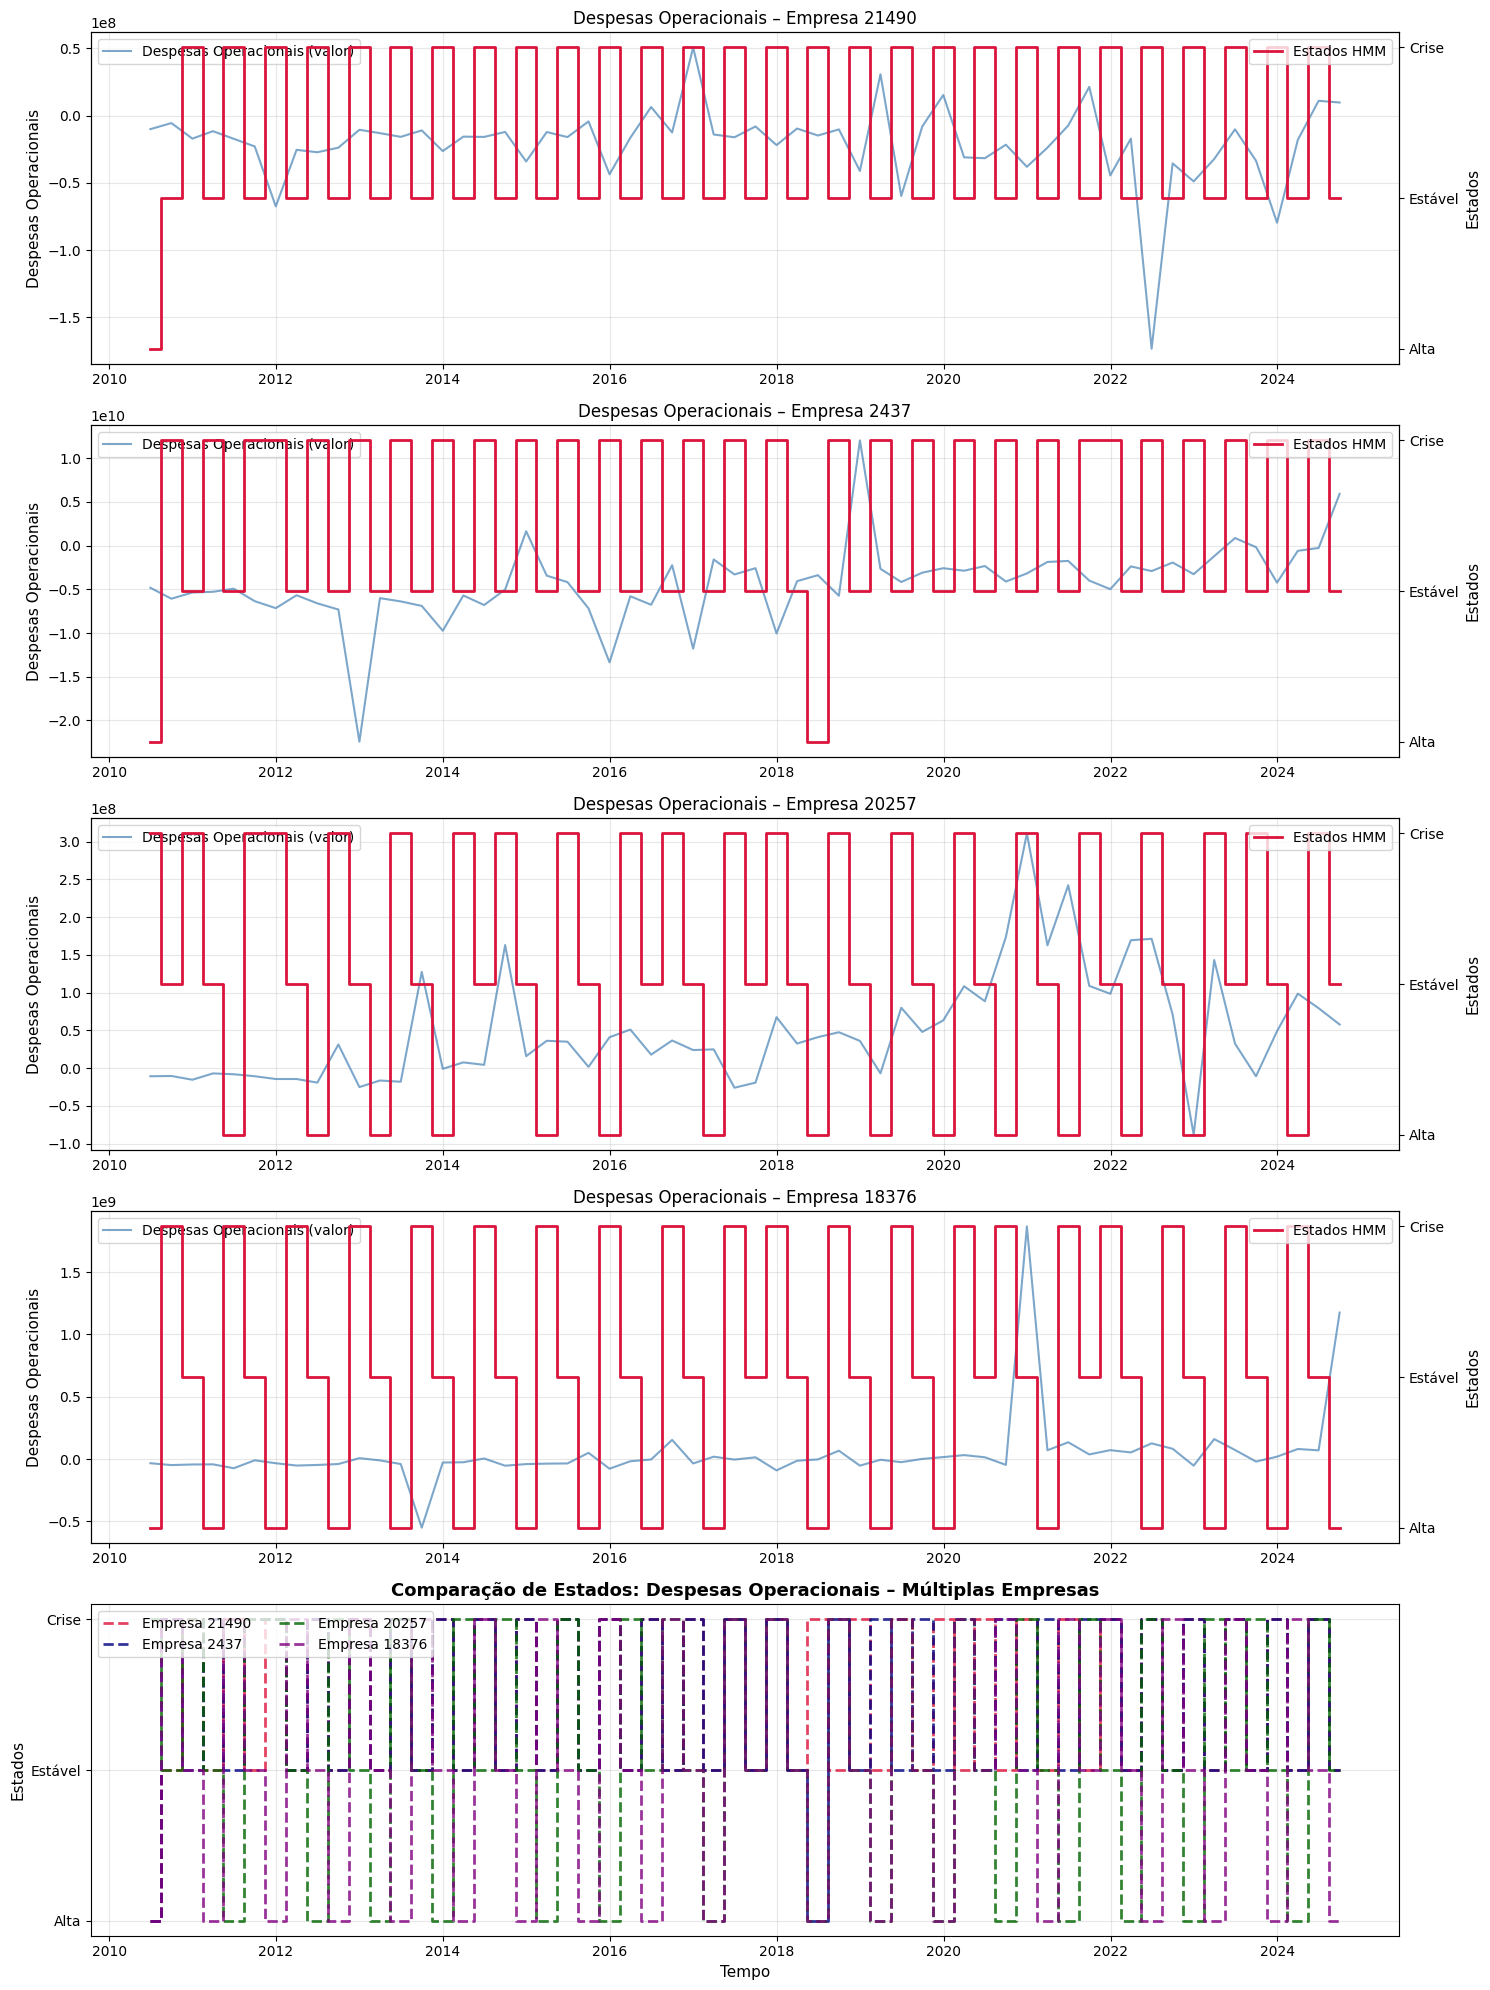


RESUMO DOS MODELOS HMM - Despesas Operacionais

Empresa 21490:
  Convergiu: True
  Log-Likelihood: -27.24
  Número de observações: 58

  Matriz de Transição:
[[0.    1.    0.   ]
 [0.062 0.    0.938]
 [0.    1.    0.   ]]

  Matriz de Emissão:
[[0.008 0.992]
 [0.103 0.897]
 [0.723 0.277]]

Empresa 2437:
  Convergiu: True
  Log-Likelihood: -35.95
  Número de observações: 58

  Matriz de Transição:
[[0.005 0.004 0.991]
 [0.063 0.    0.937]
 [0.078 0.804 0.118]]

  Matriz de Emissão:
[[0.011 0.989]
 [0.179 0.821]
 [0.734 0.266]]

Empresa 20257:
  Convergiu: True
  Log-Likelihood: -35.89
  Número de observações: 58

  Matriz de Transição:
[[0.051 0.035 0.914]
 [0.691 0.    0.309]
 [0.001 0.907 0.092]]

  Matriz de Emissão:
[[0.733 0.267]
 [0.001 0.999]
 [0.543 0.457]]

Empresa 18376:
  Convergiu: True
  Log-Likelihood: -29.64
  Número de observações: 58

  Matriz de Transição:
[[0.    0.001 0.999]
 [0.788 0.    0.212]
 [0.    0.998 0.002]]

  Matriz de Emissão:
[[0.269 0.731]
 [0.    1.  

In [ ]:
def analisar_indicador_multiplas_empresas(empresas_list, indicador_series, nome_indicador, n_estados=3, n_bins=2, n_iter=100):
    """
    Treina modelos HMM para o mesmo indicador em múltiplas empresas e compara estados.
    
    Args:
        empresas_list: lista de códigos das empresas
        indicador_series: DataFrame ou dict com séries do indicador por empresa
        nome_indicador: nome do indicador (ex: 'Resultado Bruto')
        n_estados: número de estados ocultos
        n_bins: número de bins para discretização
        n_iter: iterações do Baum-Welch
    
    Returns:
        dict com modelos, estados e séries processadas por empresa
    """
    resultados = {}
    
    for empresa in empresas_list:
        print(f"\n--- Processando Empresa {empresa} ---")
        
        # Obtém série da empresa
        if isinstance(indicador_series, pd.DataFrame):
            serie = indicador_series[empresa]
        else:
            serie = indicador_series[empresa]
        
        # Prepara série
        serie_limpa = (
            serie
            .sort_index()
            .astype(float)
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
        )
        
        serie_pct = serie_limpa.pct_change().dropna()
        obs_sequencia = serie_pct.apply(
            lambda x: discretizar_receita_parametrizada(x, n_bins)
        ).to_numpy().reshape(-1, 1)
        
        # Treina modelo
        model = hmm.CategoricalHMM(
            n_components=n_estados,
            n_iter=n_iter,
            random_state=1
        )
        model.fit(obs_sequencia)
        
        # Decodifica estados
        _, estados_preditos = model.decode(obs_sequencia)
        
        # Armazena resultados
        resultados[empresa] = {
            'serie_original': serie_limpa,
            'serie_pct': serie_pct,
            'estados': estados_preditos,
            'index': serie_pct.index,
            'modelo': model,
            'convergiu': model.monitor_.converged,
            'log_likelihood': model.monitor_.history[-1] if model.monitor_.history else np.nan
        }
        
        print(f"Convergiu: {model.monitor_.converged}")
        print(f"Log-Likelihood: {model.monitor_.history[-1]:.2f}" if model.monitor_.history else "N/A")
    
    return resultados

def plotar_comparacao_empresas(resultados, nome_indicador, n_estados=3):
    """
    Plota comparação dos estados do mesmo indicador entre múltiplas empresas.
    
    Args:
        resultados: dict retornado por analisar_indicador_multiplas_empresas
        nome_indicador: nome do indicador
        n_estados: número de estados para labels
    """
    n_empresas = len(resultados)
    fig, axes = plt.subplots(n_empresas + 1, 1, figsize=(15, 4 * (n_empresas + 1)))
    
    if n_empresas == 1:
        axes = [axes]
    
    # Plot individual de cada empresa
    for i, (empresa, dados) in enumerate(resultados.items()):
        ax = axes[i]
        ax.plot(dados['index'], dados['serie_original'].loc[dados['index']], 
                color='steelblue', label=f'{nome_indicador} (valor)', alpha=0.7)
        ax.set_ylabel(nome_indicador, fontsize=11)
        ax.set_title(f'{nome_indicador} – Empresa {empresa}', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        
        # Eixo secundário para estados
        ax2 = ax.twinx()
        ax2.step(dados['index'], dados['estados'], where='mid', 
                 color='crimson', label='Estados HMM', linewidth=2)
        ax2.set_ylabel('Estados', fontsize=11)
        
        if n_estados == 2:
            ax2.set_yticks([0, 1])
            ax2.set_yticklabels(['Positivo', 'Negativo'])
        elif n_estados == 3:
            ax2.set_yticks([0, 1, 2])
            ax2.set_yticklabels(['Alta', 'Estável', 'Crise'])
        else:
            ax2.set_yticks(range(n_estados))
        
        ax2.legend(loc='upper right')
    
    # Plot comparativo (último subplot)
    ax_comp = axes[-1]
    cores = ['crimson', 'navy', 'darkgreen', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for idx, (empresa, dados) in enumerate(resultados.items()):
        ax_comp.step(dados['index'], dados['estados'], where='mid',
                     label=f'Empresa {empresa}', linewidth=2, 
                     color=cores[idx % len(cores)], alpha=0.8, linestyle='--')
    
    ax_comp.set_title(f'Comparação de Estados: {nome_indicador} – Múltiplas Empresas', 
                      fontsize=13, fontweight='bold')
    ax_comp.set_xlabel('Tempo', fontsize=11)
    ax_comp.set_ylabel('Estados', fontsize=11)
    
    if n_estados == 2:
        ax_comp.set_yticks([0, 1])
        ax_comp.set_yticklabels(['Positivo', 'Negativo'])
    elif n_estados == 3:
        ax_comp.set_yticks([0, 1, 2])
        ax_comp.set_yticklabels(['Alta', 'Estável', 'Crise'])
    else:
        ax_comp.set_yticks(range(n_estados))
    
    ax_comp.legend(loc='upper left', fontsize=10, ncol=2)
    ax_comp.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def resumo_modelos_empresas(resultados, nome_indicador):
    """Exibe resumo dos modelos treinados por empresa"""
    print("\n" + "="*60)
    print(f"RESUMO DOS MODELOS HMM - {nome_indicador}")
    print("="*60)
    
    for empresa, dados in resultados.items():
        print(f"\nEmpresa {empresa}:")
        print(f"  Convergiu: {dados['convergiu']}")
        print(f"  Log-Likelihood: {dados['log_likelihood']:.2f}")
        print(f"  Número de observações: {len(dados['estados'])}")
        print(f"\n  Matriz de Transição:")
        print(dados['modelo'].transmat_.round(3))
        print(f"\n  Matriz de Emissão:")
        print(dados['modelo'].emissionprob_.round(3))

# Uso da função
empresas_analise = ['21490', '2437', '20257', '18376']  # Liste as empresas desejadas

# Executa análise para Resultado Bruto
resultados_empresas = analisar_indicador_multiplas_empresas(
    empresas_list=empresas_analise,
    indicador_series=resultado_bruto,
    nome_indicador='Resultado Bruto',
    n_estados=3,
    n_bins=2,
    n_iter=100
)

lucro_empresas = analisar_indicador_multiplas_empresas(
    empresas_list=empresas_analise,
    indicador_series=lucro_consolidado,
    nome_indicador='Lucro Consolidado',
    n_estados=3,
    n_bins=2,
    n_iter=100
)

despesas_operacionais = analisar_indicador_multiplas_empresas(
    empresas_list=empresas_analise,
    indicador_series=despesas_operacionais,
    nome_indicador='Despesas Operacionais',
    n_estados=3,
    n_bins=2,
    n_iter=100
)

plotar_comparacao_empresas(despesas_operacionais, 'Despesas Operacionais', n_estados=3)
resumo_modelos_empresas(despesas_operacionais, 'Despesas Operacionais')

Teste PoissonHMM

ANÁLISE INDIVIDUAL

DIAGNÓSTICO DE ADEQUAÇÃO PARA POISSON HMM

Série: Resultado Bruto - Empresa 18376
Observações: 59

--- Estatísticas Descritivas ---
Média:           926619762.7119
Variância:       830438314080632448.0000
Desvio Padrão:   911283882.2676

--- Teste de Dispersão ---
Índice de Dispersão (Var/Média): 896201815.9965
Classificação:   SOBREDISPERSÃO SEVERA

--- Verificações Adicionais ---
Contém valores negativos: NÃO
Contém valores decimais:  NÃO

--- Conclusão ---
Adequado para PoissonHMM: ✗ NÃO
Recomendação: CategoricalHMM ou GaussianHMM

ANÁLISE COMPARATIVA - RESULTADO BRUTO (MÚLTIPLAS EMPRESAS)

DIAGNÓSTICO DE ADEQUAÇÃO PARA POISSON HMM

Série: Empresa 21490
Observações: 59

--- Estatísticas Descritivas ---
Média:           664665974.5763
Variância:       198436786202469184.0000
Desvio Padrão:   445462440.8437

--- Teste de Dispersão ---
Índice de Dispersão (Var/Média): 298551142.6683
Classificação:   SOBREDISPERSÃO SEVERA

--- Verificações Adicionais ---
Contém valor

nome         media     variancia  indice_dispersao  \
0  Empresa 21490  6.646660e+08  1.984368e+17      2.985511e+08   
1   Empresa 2437  8.658432e+09  1.629101e+19      1.881520e+09   
2  Empresa 20257  4.923618e+08  7.737627e+16      1.571533e+08   
3  Empresa 18376  9.266198e+08  8.304383e+17      8.962018e+08   

          dispersao_tipo  adequado_poisson  \
0  SOBREDISPERSÃO SEVERA             False   
1  SOBREDISPERSÃO SEVERA             False   
2  SOBREDISPERSÃO SEVERA             False   
3  SOBREDISPERSÃO SEVERA             False   

                                        recomendacao  
0                      CategoricalHMM ou GaussianHMM  
1  CategoricalHMM ou GaussianHMM (dados não são c...  
2                      CategoricalHMM ou GaussianHMM  
3                      CategoricalHMM ou GaussianHMM


ANÁLISE COMPARATIVA - INDICADORES DA MESMA EMPRESA

DIAGNÓSTICO DE ADEQUAÇÃO PARA POISSON HMM

Série: Resultado Bruto
Observações: 59

--- Estatísticas Descritivas ---
Média:           664665974.5763
Variância:       198436786202469184.0000
Desvio Padrão:   445462440.8437

--- Teste de Dispersão ---
Índice de Dispersão (Var/Média): 298551142.6683
Classificação:   SOBREDISPERSÃO SEVERA

--- Verificações Adicionais ---
Contém valores negativos: NÃO
Contém valores decimais:  NÃO

--- Conclusão ---
Adequado para PoissonHMM: ✗ NÃO
Recomendação: CategoricalHMM ou GaussianHMM

DIAGNÓSTICO DE ADEQUAÇÃO PARA POISSON HMM

Série: Lucro Consolidado
Observações: 59

--- Estatísticas Descritivas ---
Média:           268447093.2203
Variância:       36059109278857536.0000
Desvio Padrão:   189892362.3500

--- Teste de Dispersão ---
Índice de Dispersão (Var/Média): 134324826.7146
Classificação:   SOBREDISPERSÃO SEVERA

--- Verificações Adicionais ---
Contém valores negativos: NÃO
Contém valores decimai

nome         media     variancia  indice_dispersao  \
0        Resultado Bruto  6.646660e+08  1.984368e+17      2.985511e+08   
1      Lucro Consolidado  2.684471e+08  3.605911e+16      1.343248e+08   
2  Despesas Operacionais -2.053469e+07  8.604696e+14     -4.190323e+07   

          dispersao_tipo  adequado_poisson  \
0  SOBREDISPERSÃO SEVERA             False   
1  SOBREDISPERSÃO SEVERA             False   
2           SUBDISPERSÃO             False   

                                        recomendacao  
0                      CategoricalHMM ou GaussianHMM  
1                      CategoricalHMM ou GaussianHMM  
2  CategoricalHMM ou GaussianHMM (dados não são c...

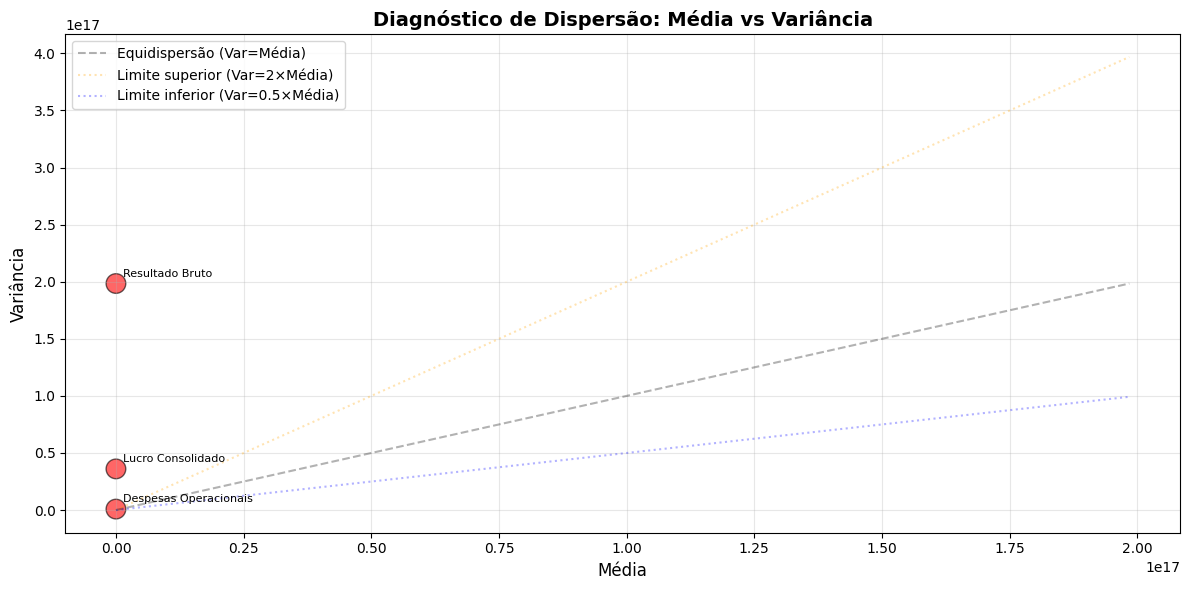

In [20]:
def testar_adequacao_poisson(serie, nome_serie='Série'):
    """
    Testa se uma série temporal é adequada para distribuição Poisson.
    
    A distribuição Poisson assume que média ≈ variância (equidispersão).
    - Se variância >> média: sobredispersão (use Negative Binomial ou Categorical)
    - Se variância << média: subdispersão (menos comum, ainda use Categorical)
    - Se variância ≈ média: adequado para Poisson
    
    Args:
        serie: série temporal (pandas Series)
        nome_serie: nome descritivo da série
    
    Returns:
        dict com estatísticas e recomendação de modelo
    """
    # Prepara série
    serie_limpa = (
        serie
        .sort_index()
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )
    
    # Calcula estatísticas
    media = serie_limpa.mean()
    variancia = serie_limpa.var()
    desvio_padrao = serie_limpa.std()
    
    # Índice de dispersão (variance-to-mean ratio)
    indice_dispersao = variancia / media if media != 0 else np.inf
    
    # Classificação
    if indice_dispersao > 5:
        dispersao_tipo = "SOBREDISPERSÃO SEVERA"
        recomendacao = "CategoricalHMM ou GaussianHMM"
        adequado_poisson = False
    elif indice_dispersao > 2:
        dispersao_tipo = "SOBREDISPERSÃO MODERADA"
        recomendacao = "CategoricalHMM (preferível)"
        adequado_poisson = False
    elif 0.5 <= indice_dispersao <= 2:
        dispersao_tipo = "EQUIDISPERSÃO"
        recomendacao = "PoissonHMM (adequado)"
        adequado_poisson = True
    elif indice_dispersao < 0.5:
        dispersao_tipo = "SUBDISPERSÃO"
        recomendacao = "CategoricalHMM"
        adequado_poisson = False
    else:
        dispersao_tipo = "INDEFINIDO"
        recomendacao = "CategoricalHMM (seguro)"
        adequado_poisson = False
    
    # Teste adicional: valores negativos (Poisson não suporta)
    tem_negativos = (serie_limpa < 0).any()
    tem_decimais = (serie_limpa % 1 != 0).any()
    
    if tem_negativos or tem_decimais:
        adequado_poisson = False
        recomendacao = "CategoricalHMM ou GaussianHMM (dados não são contagens inteiras não-negativas)"
    
    resultado = {
        'nome': nome_serie,
        'n_observacoes': len(serie_limpa),
        'media': media,
        'variancia': variancia,
        'desvio_padrao': desvio_padrao,
        'indice_dispersao': indice_dispersao,
        'dispersao_tipo': dispersao_tipo,
        'tem_negativos': tem_negativos,
        'tem_decimais': tem_decimais,
        'adequado_poisson': adequado_poisson,
        'recomendacao': recomendacao
    }
    
    return resultado

def exibir_diagnostico_poisson(resultado):
    """Exibe relatório formatado do diagnóstico"""
    print("\n" + "="*70)
    print(f"DIAGNÓSTICO DE ADEQUAÇÃO PARA POISSON HMM")
    print("="*70)
    print(f"\nSérie: {resultado['nome']}")
    print(f"Observações: {resultado['n_observacoes']}")
    print(f"\n--- Estatísticas Descritivas ---")
    print(f"Média:           {resultado['media']:.4f}")
    print(f"Variância:       {resultado['variancia']:.4f}")
    print(f"Desvio Padrão:   {resultado['desvio_padrao']:.4f}")
    print(f"\n--- Teste de Dispersão ---")
    print(f"Índice de Dispersão (Var/Média): {resultado['indice_dispersao']:.4f}")
    print(f"Classificação:   {resultado['dispersao_tipo']}")
    print(f"\n--- Verificações Adicionais ---")
    print(f"Contém valores negativos: {'SIM' if resultado['tem_negativos'] else 'NÃO'}")
    print(f"Contém valores decimais:  {'SIM' if resultado['tem_decimais'] else 'NÃO'}")
    print(f"\n--- Conclusão ---")
    print(f"Adequado para PoissonHMM: {'✓ SIM' if resultado['adequado_poisson'] else '✗ NÃO'}")
    print(f"Recomendação: {resultado['recomendacao']}")
    print("="*70)

def analisar_multiplas_series_poisson(series_dict):
    """
    Analisa múltiplas séries e retorna DataFrame comparativo.
    
    Args:
        series_dict: dicionário {'nome': serie_pandas}
    
    Returns:
        DataFrame com resultados comparativos
    """
    resultados = []
    
    for nome, serie in series_dict.items():
        resultado = testar_adequacao_poisson(serie, nome)
        resultados.append(resultado)
        exibir_diagnostico_poisson(resultado)
    
    df_resultados = pd.DataFrame(resultados)
    return df_resultados

# ==========================================
# EXEMPLO DE USO
# ==========================================

# Teste para uma empresa específica
print("="*70)
print("ANÁLISE INDIVIDUAL")
print("="*70)

empresa_teste = '18376'
resultado_rb = testar_adequacao_poisson(
    resultado_bruto[empresa_teste], 
    f'Resultado Bruto - Empresa {empresa_teste}'
)
exibir_diagnostico_poisson(resultado_rb)

# Teste para múltiplas empresas do mesmo indicador
print("\n" + "="*70)
print("ANÁLISE COMPARATIVA - RESULTADO BRUTO (MÚLTIPLAS EMPRESAS)")
print("="*70)

empresas_analise = ['21490', '2437', '20257', '18376']
series_rb = {
    f'Empresa {emp}': resultado_bruto[emp] 
    for emp in empresas_analise
}

df_comparativo_rb = analisar_multiplas_series_poisson(series_rb)

print("\n=== TABELA COMPARATIVA ===")
display(df_comparativo_rb[['nome', 'media', 'variancia', 'indice_dispersao', 
                            'dispersao_tipo', 'adequado_poisson', 'recomendacao']])

# Teste para múltiplos indicadores de uma empresa
print("\n" + "="*70)
print("ANÁLISE COMPARATIVA - INDICADORES DA MESMA EMPRESA")
print("="*70)

empresa_analise = '21490'
series_indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

df_comparativo_ind = analisar_multiplas_series_poisson(series_indicadores)

print("\n=== TABELA COMPARATIVA ===")
display(df_comparativo_ind[['nome', 'media', 'variancia', 'indice_dispersao', 
                             'dispersao_tipo', 'adequado_poisson', 'recomendacao']])

# Visualização gráfica
def plotar_diagnostico_dispersao(df_resultados):
    """Plota gráfico de dispersão para análise visual"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    cores = ['green' if x else 'red' for x in df_resultados['adequado_poisson']]
    
    ax.scatter(df_resultados['media'], df_resultados['variancia'], 
               s=200, c=cores, alpha=0.6, edgecolors='black')
    
    # Linha de referência (média = variância)
    max_val = max(df_resultados['media'].max(), df_resultados['variancia'].max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equidispersão (Var=Média)')
    
    # Linhas de tolerância
    ax.plot([0, max_val], [0, max_val*2], 'orange', alpha=0.3, linestyle=':', label='Limite superior (Var=2×Média)')
    ax.plot([0, max_val], [0, max_val*0.5], 'blue', alpha=0.3, linestyle=':', label='Limite inferior (Var=0.5×Média)')
    
    # Anotações
    for idx, row in df_resultados.iterrows():
        ax.annotate(row['nome'], (row['media'], row['variancia']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_xlabel('Média', fontsize=12)
    ax.set_ylabel('Variância', fontsize=12)
    ax.set_title('Diagnóstico de Dispersão: Média vs Variância', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plota diagnóstico
plotar_diagnostico_dispersao(df_comparativo_ind)

Prepara para a GaussianHMM


Processando: Resultado Bruto

RESUMO DO MODELO GAUSSIANHMM - Resultado Bruto - Empresa 21490

--- Transformações Aplicadas ---
1. Log natural
2. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.1000 ✓ Estacionária
Conclusão: ✓ SÉRIE ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: 11.72
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.866 0.134 0.001]
 [0.    0.069 0.931]
 [0.207 0.361 0.432]]

--- Médias por Estado ---
[[ 0.005]
 [ 0.303]
 [-0.127]]

--- Covariâncias por Estado ---

Estado 0:
[[0.006]]

Estado 1:
[[0.122]]

Estado 2:
[[0.084]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual     media  desvio_padrao       min      max
      0             33   56.896552  0.004222       0.076992 -0.138616 0.203306
      1              9   15.517241  0.422426       0.301909 -0.091765 1.044632
      2             16   27.586207 -0.171857    

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


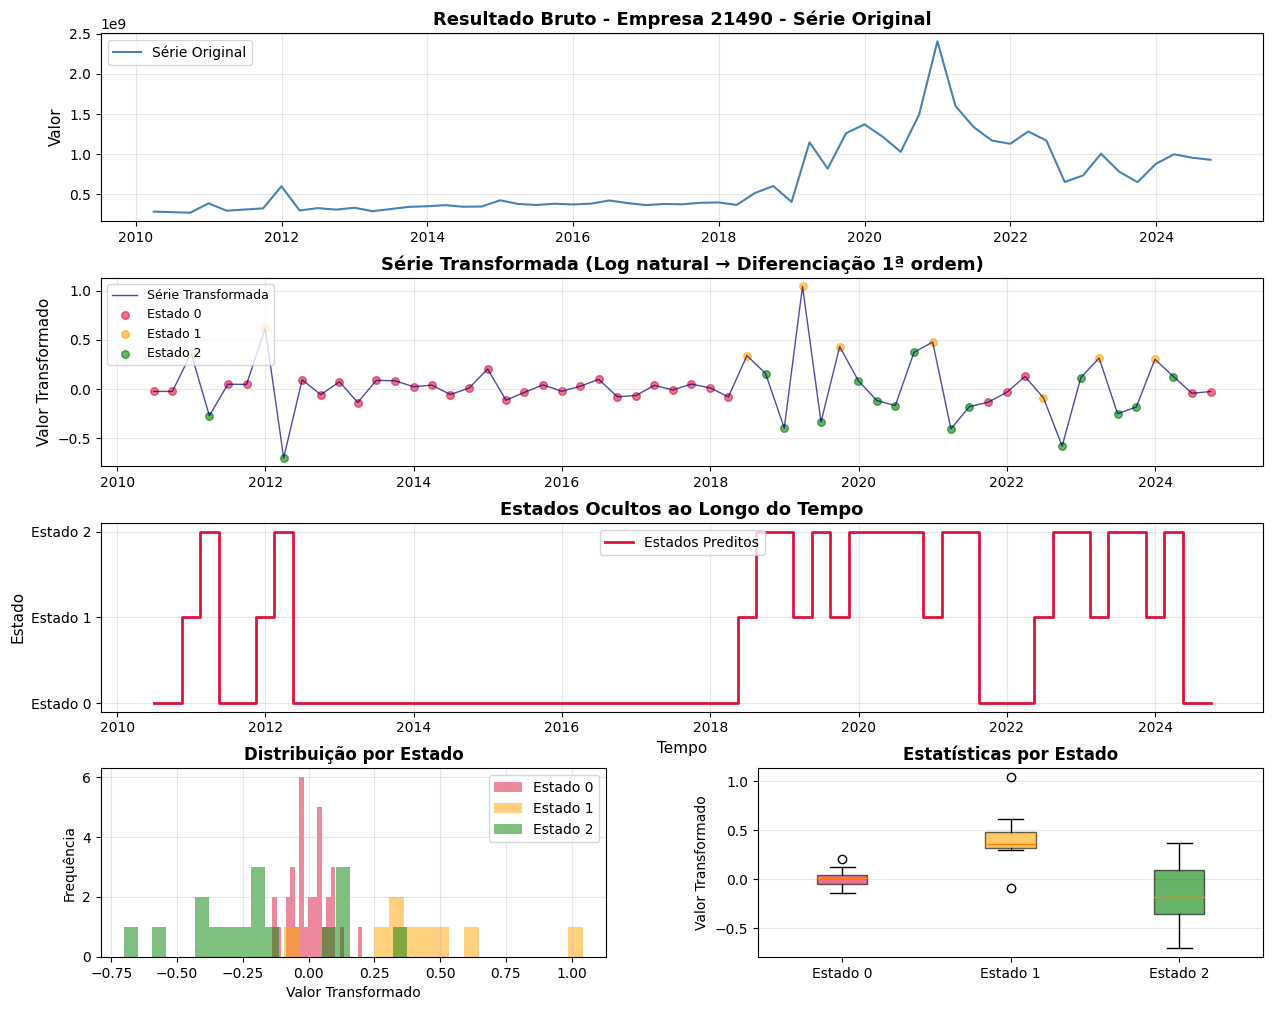


Processando: Lucro Consolidado

RESUMO DO MODELO GAUSSIANHMM - Lucro Consolidado - Empresa 21490

--- Transformações Aplicadas ---
1. Log natural
2. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -32.50
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.959 0.    0.041]
 [0.    0.03  0.97 ]
 [0.    0.48  0.52 ]]

--- Médias por Estado ---
[[ 0.018]
 [ 0.437]
 [-0.152]]

--- Covariâncias por Estado ---

Estado 0:
[[0.046]]

Estado 1:
[[0.516]]

Estado 2:
[[0.301]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual     media  desvio_padrao       min      max
      0             25   43.103448  0.023661       0.215049 -0.365720 0.500015
      1             12   20.689655  0.615673       0.579967  0.023332 2.276798
      2             21   36.206897 

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


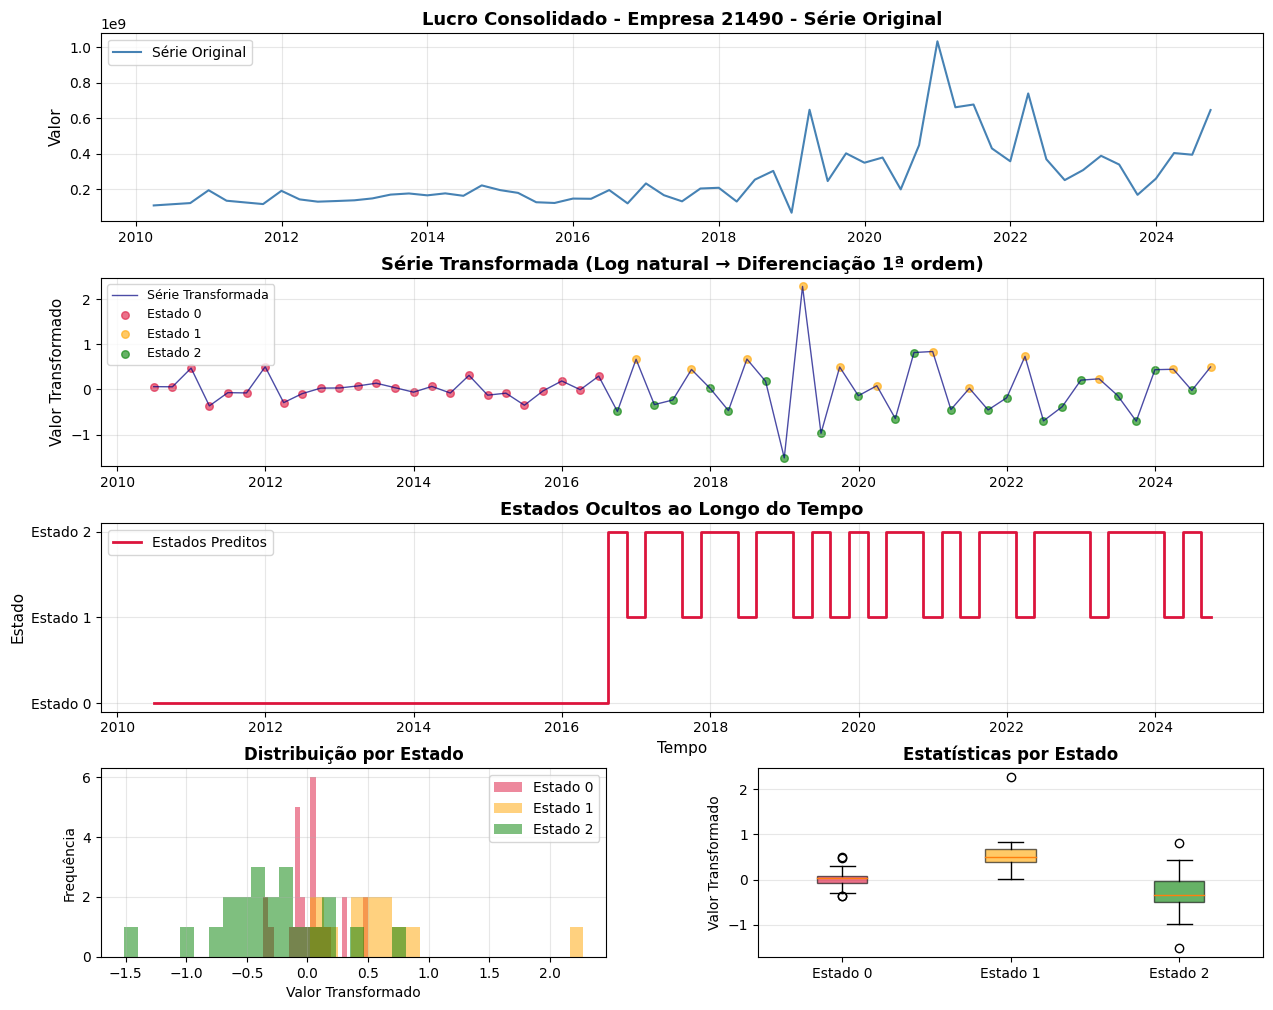


Processando: Despesas Operacionais

RESUMO DO MODELO GAUSSIANHMM - Despesas Operacionais - Empresa 21490

--- Transformações Aplicadas ---
1. Shift +173367001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.6787 ✗ Não estacionária
KPSS p-value: 0.0784 ✓ Estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: 7.67
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.018 0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]]

--- Médias por Estado ---
[[ 5.0000e-03]
 [-1.8866e+01]
 [ 1.8741e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.041]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.004779       0.204602  -0.586125   0.505559
      1              1    1.724138 -18.866469            NaN -18

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


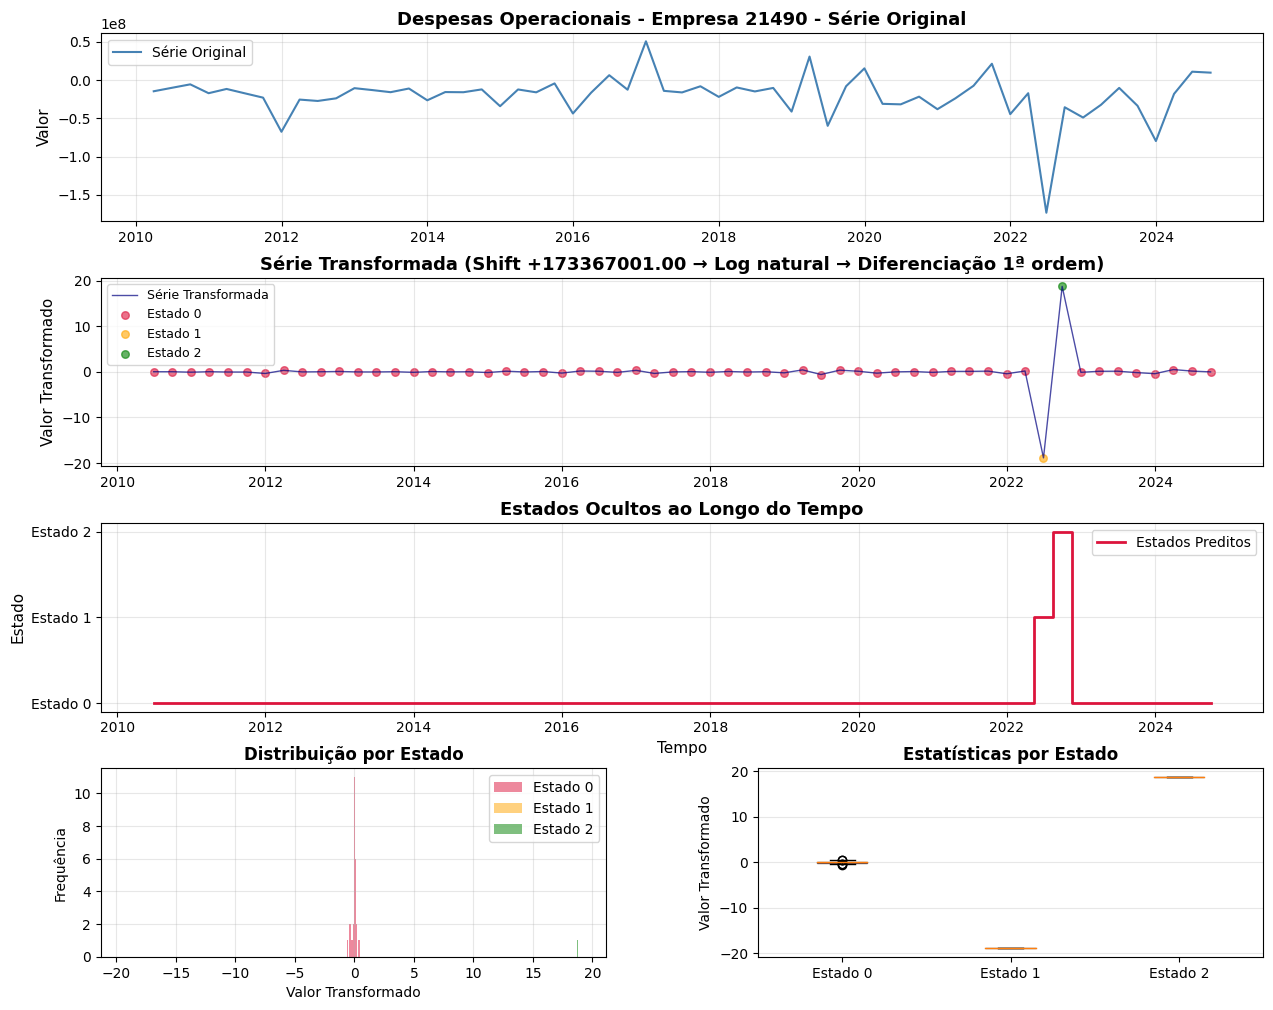


COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR

Resultado Bruto:
 estado  n_observacoes  percentual     media
      0             33   56.896552  0.004222
      1              9   15.517241  0.422426
      2             16   27.586207 -0.171857

Lucro Consolidado:
 estado  n_observacoes  percentual     media
      0             25   43.103448  0.023661
      1             12   20.689655  0.615673
      2             21   36.206897 -0.294613

Despesas Operacionais:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.004779
      1              1    1.724138 -18.866469
      2              1    1.724138  18.741408


In [26]:
def preparar_serie_gaussianhmm(serie, aplicar_log=True, diferenciacao=1):
    """
    Prepara série temporal para GaussianHMM: torna estacionária e aplica log.
    
    Args:
        serie: série temporal (pandas Series)
        aplicar_log: se True, aplica log após tornar positiva
        diferenciacao: ordem de diferenciação (1 = primeira diferença)
    
    Returns:
        tuple: (serie_transformada, serie_original_limpa, transformacoes_aplicadas)
    """
    # Limpa série
    serie_limpa = (
        serie
        .sort_index()
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )
    
    transformacoes = []
    serie_transformada = serie_limpa.copy()
    
    # Torna valores positivos (necessário para log)
    if aplicar_log:
        min_val = serie_transformada.min()
        if min_val <= 0:
            shift_value = abs(min_val) + 1
            serie_transformada = serie_transformada + shift_value
            transformacoes.append(f'Shift +{shift_value:.2f}')
        
        # Aplica log
        serie_transformada = np.log(serie_transformada)
        transformacoes.append('Log natural')
    
    # Diferenciação para estacionariedade
    if diferenciacao > 0:
        for _ in range(diferenciacao):
            serie_transformada = serie_transformada.diff().dropna()
            transformacoes.append('Diferenciação 1ª ordem')
    
    return serie_transformada, serie_limpa, transformacoes

def testar_estacionariedade(serie, nome='Série', alpha=0.05):
    """
    Testa estacionariedade usando ADF e KPSS.
    
    Args:
        serie: série temporal
        nome: nome da série
        alpha: nível de significância
    
    Returns:
        dict com resultados dos testes
    """
    from statsmodels.tsa.stattools import adfuller, kpss
    
    # Teste ADF (H0: série tem raiz unitária = não estacionária)
    adf_result = adfuller(serie.dropna(), autolag='AIC')
    adf_estatistica, adf_pvalue = adf_result[0], adf_result[1]
    adf_estacionaria = adf_pvalue < alpha
    
    # Teste KPSS (H0: série é estacionária)
    kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
    kpss_estatistica, kpss_pvalue = kpss_result[0], kpss_result[1]
    kpss_estacionaria = kpss_pvalue > alpha
    
    return {
        'nome': nome,
        'adf_estatistica': adf_estatistica,
        'adf_pvalue': adf_pvalue,
        'adf_estacionaria': adf_estacionaria,
        'kpss_estatistica': kpss_estatistica,
        'kpss_pvalue': kpss_pvalue,
        'kpss_estacionaria': kpss_estacionaria,
        'conclusao_estacionaria': adf_estacionaria and kpss_estacionaria
    }

def analisar_gaussianhmm(serie, nome_serie='Série', n_estados=3, n_iter=100, 
                          aplicar_log=True, diferenciacao=1, random_state=1):
    """
    Treina GaussianHMM em série transformada e retorna resultados.
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        n_estados: número de estados ocultos
        n_iter: iterações do Baum-Welch
        aplicar_log: se True, aplica log
        diferenciacao: ordem de diferenciação
        random_state: seed para reprodutibilidade
    
    Returns:
        dict com modelo treinado, estados, séries e estatísticas
    """
    # Prepara série
    serie_transformada, serie_original, transformacoes = preparar_serie_gaussianhmm(
        serie, aplicar_log, diferenciacao
    )
    
    # Testa estacionariedade
    teste_estacionariedade = testar_estacionariedade(serie_transformada, nome_serie)
    
    # Prepara dados para HMM (precisa ser 2D)
    obs_sequencia = serie_transformada.to_numpy().reshape(-1, 1)
    
    # Treina modelo
    model = hmm.GaussianHMM(
        n_components=n_estados,
        covariance_type='full',
        n_iter=n_iter,
        random_state=random_state,
        verbose=False
    )
    model.fit(obs_sequencia)
    
    # Decodifica estados
    logprob, estados_preditos = model.decode(obs_sequencia)
    
    # Calcula estatísticas por estado
    estatisticas_estados = []
    for estado in range(n_estados):
        mascara = estados_preditos == estado
        valores_estado = serie_transformada[mascara]
        
        estatisticas_estados.append({
            'estado': estado,
            'n_observacoes': mascara.sum(),
            'percentual': (mascara.sum() / len(estados_preditos)) * 100,
            'media': valores_estado.mean(),
            'desvio_padrao': valores_estado.std(),
            'min': valores_estado.min(),
            'max': valores_estado.max()
        })
    
    return {
        'nome': nome_serie,
        'serie_original': serie_original,
        'serie_transformada': serie_transformada,
        'transformacoes': transformacoes,
        'estados': estados_preditos,
        'index': serie_transformada.index,
        'modelo': model,
        'convergiu': model.monitor_.converged,
        'log_likelihood': model.monitor_.history[-1] if model.monitor_.history else np.nan,
        'teste_estacionariedade': teste_estacionariedade,
        'estatisticas_estados': pd.DataFrame(estatisticas_estados),
        'n_estados': n_estados
    }

def plotar_resultados_gaussianhmm(resultado, figsize=(15, 12)):
    """
    Plota resultados completos do GaussianHMM.
    
    Args:
        resultado: dict retornado por analisar_gaussianhmm
        figsize: tamanho da figura
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
    
    # 1. Série Original
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(resultado['serie_original'].index, resultado['serie_original'], 
             color='steelblue', linewidth=1.5, label='Série Original')
    ax1.set_title(f"{resultado['nome']} - Série Original", fontsize=13, fontweight='bold')
    ax1.set_ylabel('Valor', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # 2. Série Transformada com Estados
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(resultado['index'], resultado['serie_transformada'], 
             color='navy', linewidth=1, alpha=0.7, label='Série Transformada')
    
    # Colorir por estado
    cores_estados = ['crimson', 'orange', 'green', 'purple', 'brown']
    for estado in range(resultado['n_estados']):
        mascara = resultado['estados'] == estado
        ax2.scatter(resultado['index'][mascara], 
                   resultado['serie_transformada'][mascara],
                   c=cores_estados[estado % len(cores_estados)], 
                   s=30, alpha=0.6, label=f'Estado {estado}')
    
    transformacoes_str = ' → '.join(resultado['transformacoes'])
    ax2.set_title(f"Série Transformada ({transformacoes_str})", fontsize=13, fontweight='bold')
    ax2.set_ylabel('Valor Transformado', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)
    
    # 3. Estados ao longo do tempo
    ax3 = fig.add_subplot(gs[2, :])
    ax3.step(resultado['index'], resultado['estados'], where='mid', 
             color='crimson', linewidth=2, label='Estados Preditos')
    ax3.set_title('Estados Ocultos ao Longo do Tempo', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Tempo', fontsize=11)
    ax3.set_ylabel('Estado', fontsize=11)
    ax3.set_yticks(range(resultado['n_estados']))
    ax3.set_yticklabels([f'Estado {i}' for i in range(resultado['n_estados'])])
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Distribuição dos valores por estado
    ax4 = fig.add_subplot(gs[3, 0])
    for estado in range(resultado['n_estados']):
        mascara = resultado['estados'] == estado
        valores = resultado['serie_transformada'][mascara]
        ax4.hist(valores, bins=20, alpha=0.5, 
                label=f'Estado {estado}', 
                color=cores_estados[estado % len(cores_estados)])
    
    ax4.set_title('Distribuição por Estado', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Valor Transformado', fontsize=10)
    ax4.set_ylabel('Frequência', fontsize=10)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Boxplot por estado
    ax5 = fig.add_subplot(gs[3, 1])
    dados_boxplot = [
        resultado['serie_transformada'][resultado['estados'] == estado]
        for estado in range(resultado['n_estados'])
    ]
    bp = ax5.boxplot(dados_boxplot, labels=[f'Estado {i}' for i in range(resultado['n_estados'])],
                     patch_artist=True)
    
    for patch, cor in zip(bp['boxes'], cores_estados):
        patch.set_facecolor(cor)
        patch.set_alpha(0.6)
    
    ax5.set_title('Estatísticas por Estado', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Valor Transformado', fontsize=10)
    ax5.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def resumo_gaussianhmm(resultado):
    """Exibe resumo detalhado do modelo GaussianHMM"""
    print("\n" + "="*70)
    print(f"RESUMO DO MODELO GAUSSIANHMM - {resultado['nome']}")
    print("="*70)
    
    print(f"\n--- Transformações Aplicadas ---")
    for i, transf in enumerate(resultado['transformacoes'], 1):
        print(f"{i}. {transf}")
    
    print(f"\n--- Teste de Estacionariedade ---")
    teste = resultado['teste_estacionariedade']
    print(f"ADF p-value: {teste['adf_pvalue']:.4f} {'✓ Estacionária' if teste['adf_estacionaria'] else '✗ Não estacionária'}")
    print(f"KPSS p-value: {teste['kpss_pvalue']:.4f} {'✓ Estacionária' if teste['kpss_estacionaria'] else '✗ Não estacionária'}")
    print(f"Conclusão: {'✓ SÉRIE ESTACIONÁRIA' if teste['conclusao_estacionaria'] else '✗ SÉRIE NÃO ESTACIONÁRIA'}")
    
    print(f"\n--- Informações do Modelo ---")
    print(f"Convergiu: {resultado['convergiu']}")
    print(f"Log-Likelihood: {resultado['log_likelihood']:.2f}")
    print(f"Número de observações: {len(resultado['estados'])}")
    print(f"Número de estados: {resultado['n_estados']}")
    
    print(f"\n--- Matriz de Transição ---")
    print(resultado['modelo'].transmat_.round(3))
    
    print(f"\n--- Médias por Estado ---")
    print(resultado['modelo'].means_.round(3))
    
    print(f"\n--- Covariâncias por Estado ---")
    for i in range(resultado['n_estados']):
        print(f"\nEstado {i}:")
        print(resultado['modelo'].covars_[i].round(3))
    
    print(f"\n--- Estatísticas Descritivas por Estado ---")
    print(resultado['estatisticas_estados'].to_string(index=False))
    print("="*70)

def comparar_multiplos_indicadores_gaussianhmm(empresa, indicadores_dict, n_estados=3, 
                                                aplicar_log=True, diferenciacao=1, n_iter=100):
    """
    Analisa múltiplos indicadores com GaussianHMM e compara resultados.
    
    Args:
        empresa: código da empresa
        indicadores_dict: dicionário {'nome': serie_temporal}
        n_estados: número de estados
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
        n_iter: iterações Baum-Welch
    
    Returns:
        dict com resultados por indicador
    """
    resultados = {}
    
    for nome, serie in indicadores_dict.items():
        print(f"\n{'='*70}")
        print(f"Processando: {nome}")
        print('='*70)
        
        resultado = analisar_gaussianhmm(
            serie=serie,
            nome_serie=f"{nome} - Empresa {empresa}",
            n_estados=n_estados,
            aplicar_log=aplicar_log,
            diferenciacao=diferenciacao,
            n_iter=n_iter
        )
        
        resultados[nome] = resultado
        
        # Exibe resumo
        resumo_gaussianhmm(resultado)
        
        # Plota resultados
        plotar_resultados_gaussianhmm(resultado)
    
    return resultados

# ==========================================
# EXEMPLO DE USO
# ==========================================

# Análise de múltiplos indicadores
empresa_analise = '21490'

indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

resultados_gaussian = comparar_multiplos_indicadores_gaussianhmm(
    empresa=empresa_analise,
    indicadores_dict=indicadores,
    n_estados=3,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100
)

# Comparação consolidada dos estados
print("\n" + "="*70)
print("COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR")
print("="*70)

for nome, resultado in resultados_gaussian.items():
    print(f"\n{nome}:")
    print(resultado['estatisticas_estados'][['estado', 'n_observacoes', 'percentual', 'media']].to_string(index=False))


Processando: Resultado Bruto

RESUMO DO MODELO GAUSSIANHMM - Resultado Bruto - Empresa 20257

--- Transformações Aplicadas ---
1. Log natural
2. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0990 ✓ Estacionária
Conclusão: ✓ SÉRIE ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -7.43
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.514 0.002 0.485]
 [1.    0.    0.   ]
 [0.    1.    0.   ]]

--- Médias por Estado ---
[[ 0.069]
 [-0.499]
 [ 0.474]]

--- Covariâncias por Estado ---

Estado 0:
[[0.024]]

Estado 1:
[[0.058]]

Estado 2:
[[0.12]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual     media  desvio_padrao       min       max
      0             30   51.724138  0.082532       0.147264 -0.201291  0.479440
      1             14   24.137931 -0.508840       0.231957 -0.877077 -0.129713
      2             14   24.137931  0.459916  

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


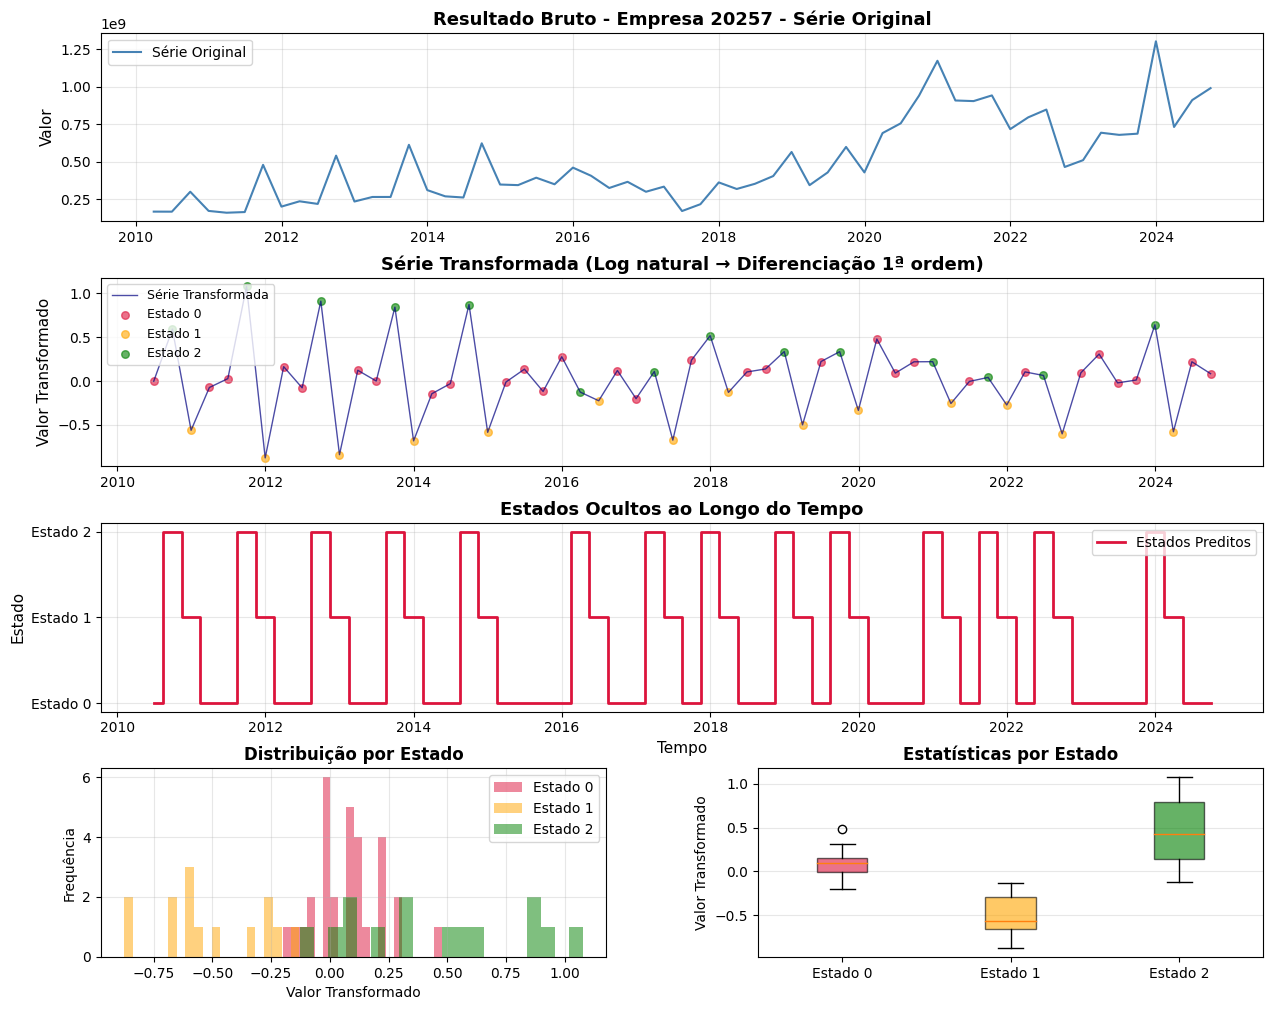


Processando: Lucro Consolidado

RESUMO DO MODELO GAUSSIANHMM - Lucro Consolidado - Empresa 20257

--- Transformações Aplicadas ---
1. Log natural
2. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.1000 ✓ Estacionária
Conclusão: ✓ SÉRIE ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -56.00
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.733 0.034 0.234]
 [0.866 0.    0.134]
 [0.    1.    0.   ]]

--- Médias por Estado ---
[[ 0.024]
 [-0.866]
 [ 1.059]]

--- Covariâncias por Estado ---

Estado 0:
[[0.123]]

Estado 1:
[[0.47]]

Estado 2:
[[0.856]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual     media  desvio_padrao       min       max
      0             40   68.965517  0.014589       0.353645 -0.717580  0.718872
      1              9   15.517241 -1.013695       0.691620 -2.584467 -0.244860
      2              9   15.517241  1.146

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


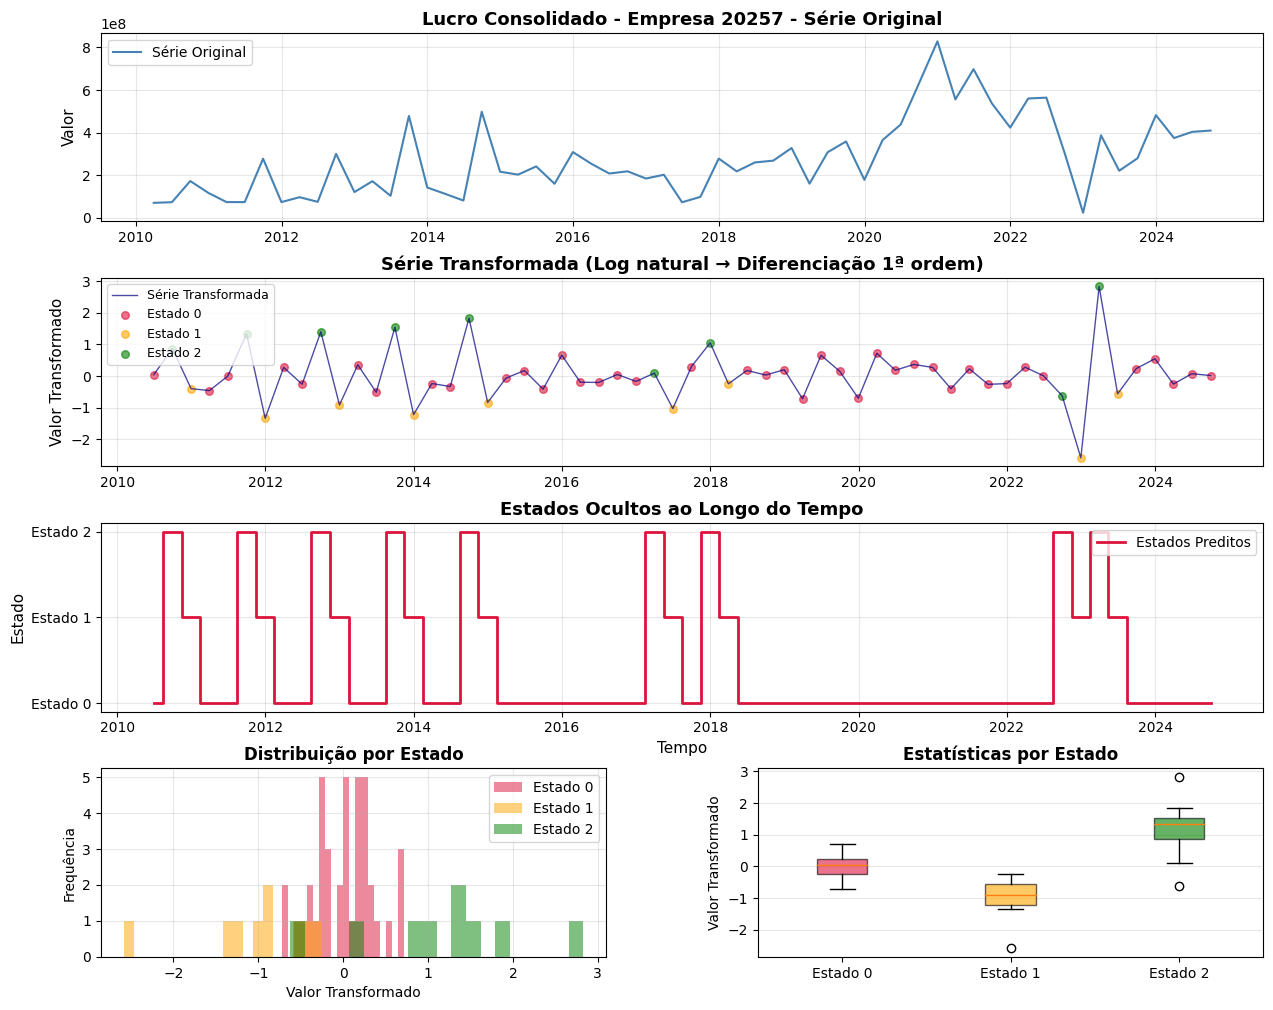


Processando: Despesas Operacionais

RESUMO DO MODELO GAUSSIANHMM - Despesas Operacionais - Empresa 20257

--- Transformações Aplicadas ---
1. Shift +88194001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0456 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -31.31
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.    0.018]
 [1.    0.    0.   ]
 [0.    1.    0.   ]]

--- Médias por Estado ---
[[ 4.0000e-03]
 [ 1.9259e+01]
 [-1.8885e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.166]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.004361       0.410414  -0.905026   1.123497
      1              1    1.724138  19.259434            NaN  1

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


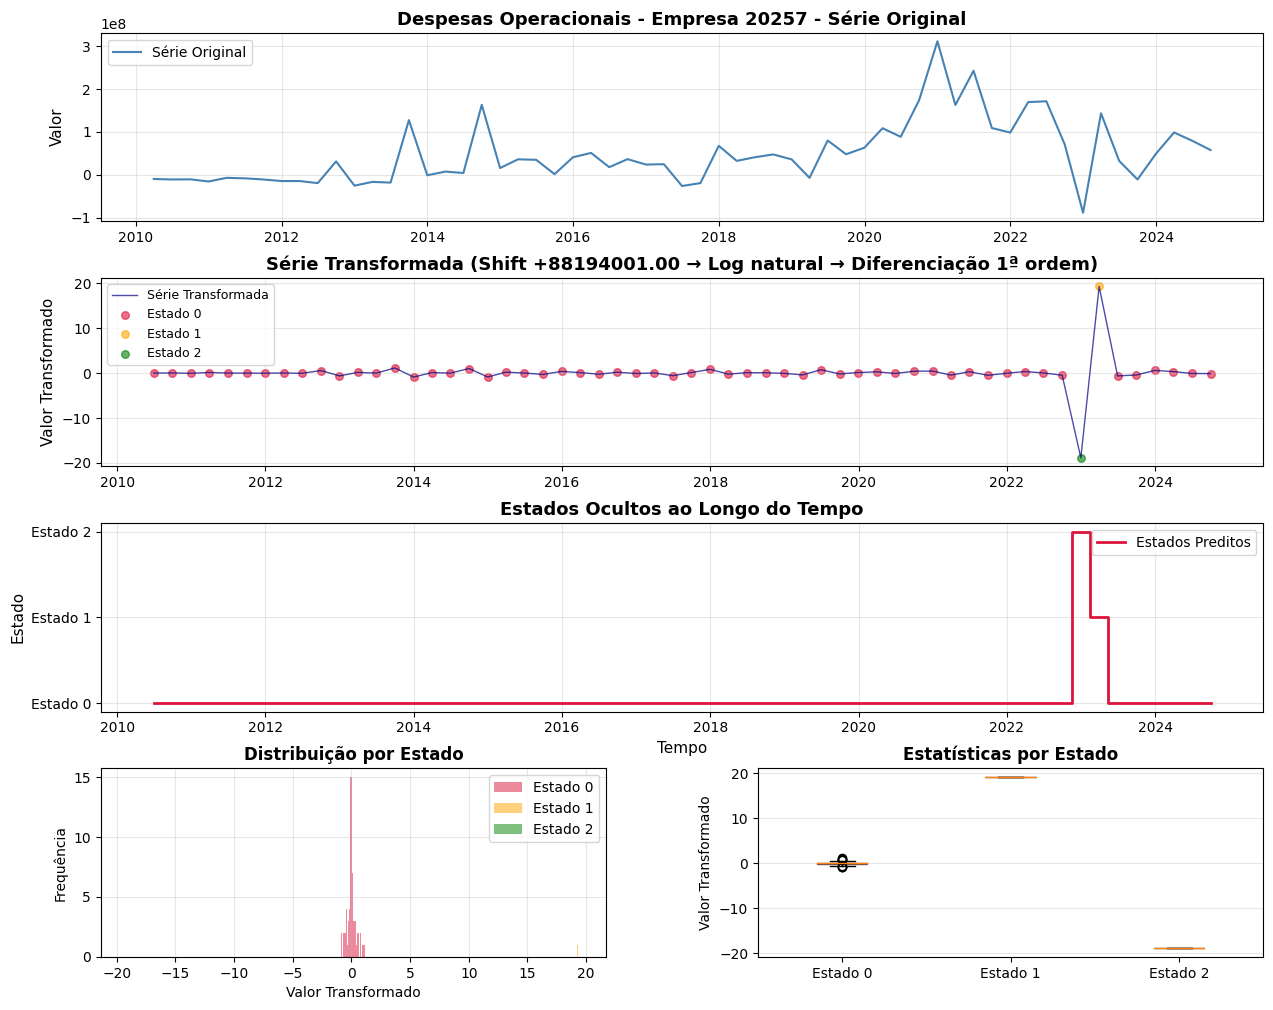


COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR

Resultado Bruto:
 estado  n_observacoes  percentual     media
      0             30   51.724138  0.082532
      1             14   24.137931 -0.508840
      2             14   24.137931  0.459916

Lucro Consolidado:
 estado  n_observacoes  percentual     media
      0             40   68.965517  0.014589
      1              9   15.517241 -1.013695
      2              9   15.517241  1.146242

Despesas Operacionais:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.004361
      1              1    1.724138  19.259434
      2              1    1.724138 -18.884685


In [ ]:
# Análise de múltiplos indicadores
empresa_analise = '20257'

indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

resultados_gaussian = comparar_multiplos_indicadores_gaussianhmm(
    empresa=empresa_analise,
    indicadores_dict=indicadores,
    n_estados=3,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100
)

# Comparação consolidada dos estados
print("\n" + "="*70)
print("COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR")
print("="*70)

for nome, resultado in resultados_gaussian.items():
    print(f"\n{nome}:")
    print(resultado['estatisticas_estados'][['estado', 'n_observacoes', 'percentual', 'media']].to_string(index=False))


Processando: Resultado Bruto

RESUMO DO MODELO GAUSSIANHMM - Resultado Bruto - Empresa 18376

--- Transformações Aplicadas ---
1. Log natural
2. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.1000 ✓ Estacionária
Conclusão: ✓ SÉRIE ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -22.20
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.94  0.021 0.04 ]
 [0.51  0.    0.49 ]
 [0.667 0.333 0.   ]]

--- Médias por Estado ---
[[ 0.039]
 [ 2.121]
 [-1.661]]

--- Covariâncias por Estado ---

Estado 0:
[[0.059]]

Estado 1:
[[1.034]]

Estado 2:
[[0.469]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual     media  desvio_padrao       min       max
      0             53   91.379310  0.039261       0.244574 -0.430449  0.633729
      1              2    3.448276  2.219865       1.323407  1.284075  3.155656
      2              3    5.172414 -1.708438

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


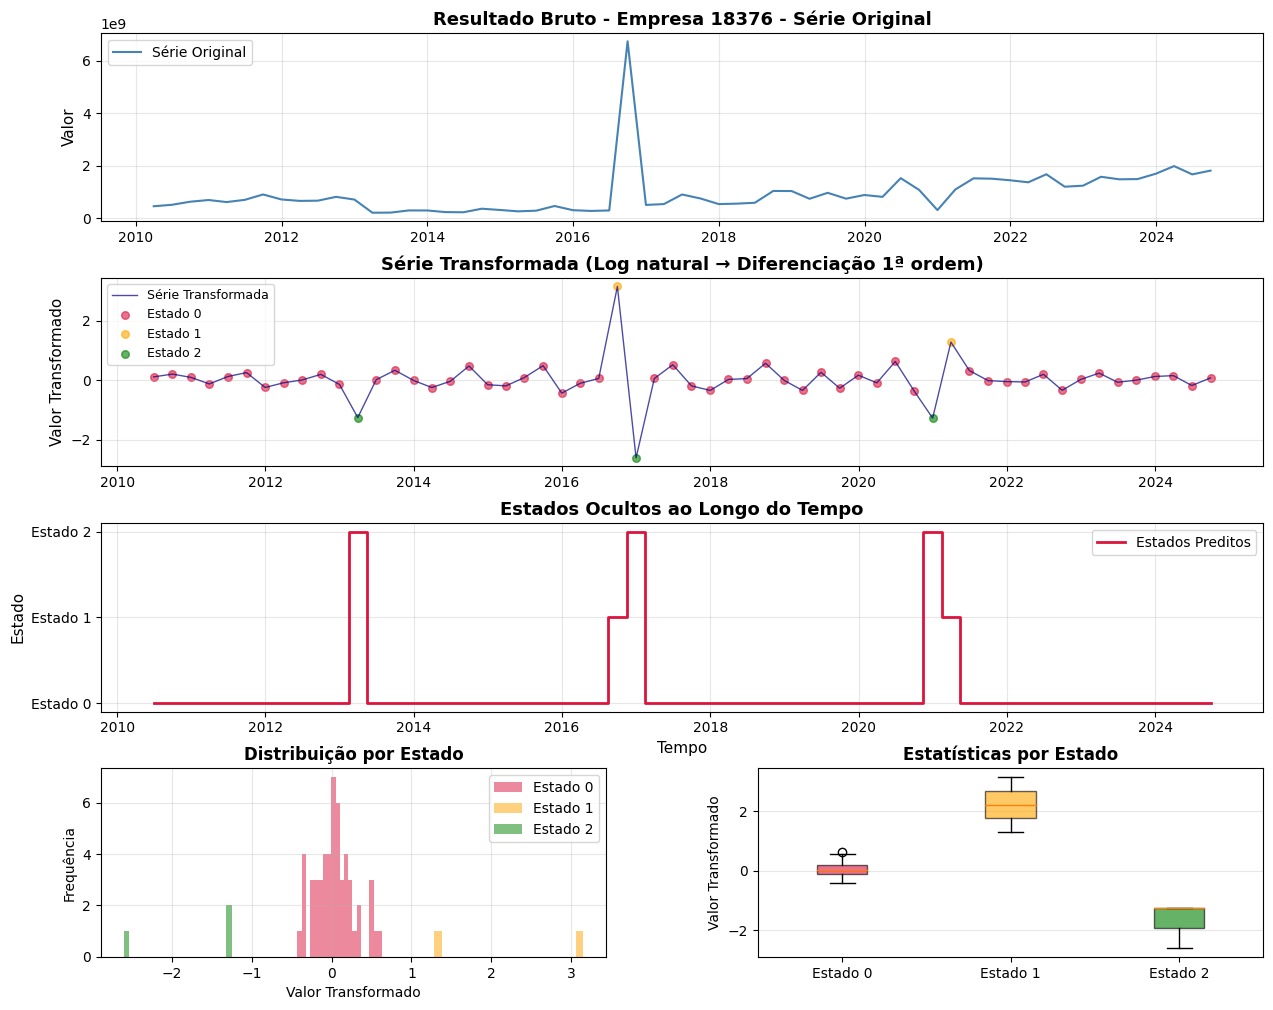


Processando: Lucro Consolidado

RESUMO DO MODELO GAUSSIANHMM - Lucro Consolidado - Empresa 18376

--- Transformações Aplicadas ---
1. Shift +245280001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -49.34
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.    0.018]
 [1.    0.    0.   ]
 [0.    1.    0.   ]]

--- Médias por Estado ---
[[ 1.4000e-02]
 [ 1.9817e+01]
 [-1.9495e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.315]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.013988       0.566287  -2.358369   2.605662
      1              1    1.724138  19.817084            NaN  19.81708

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


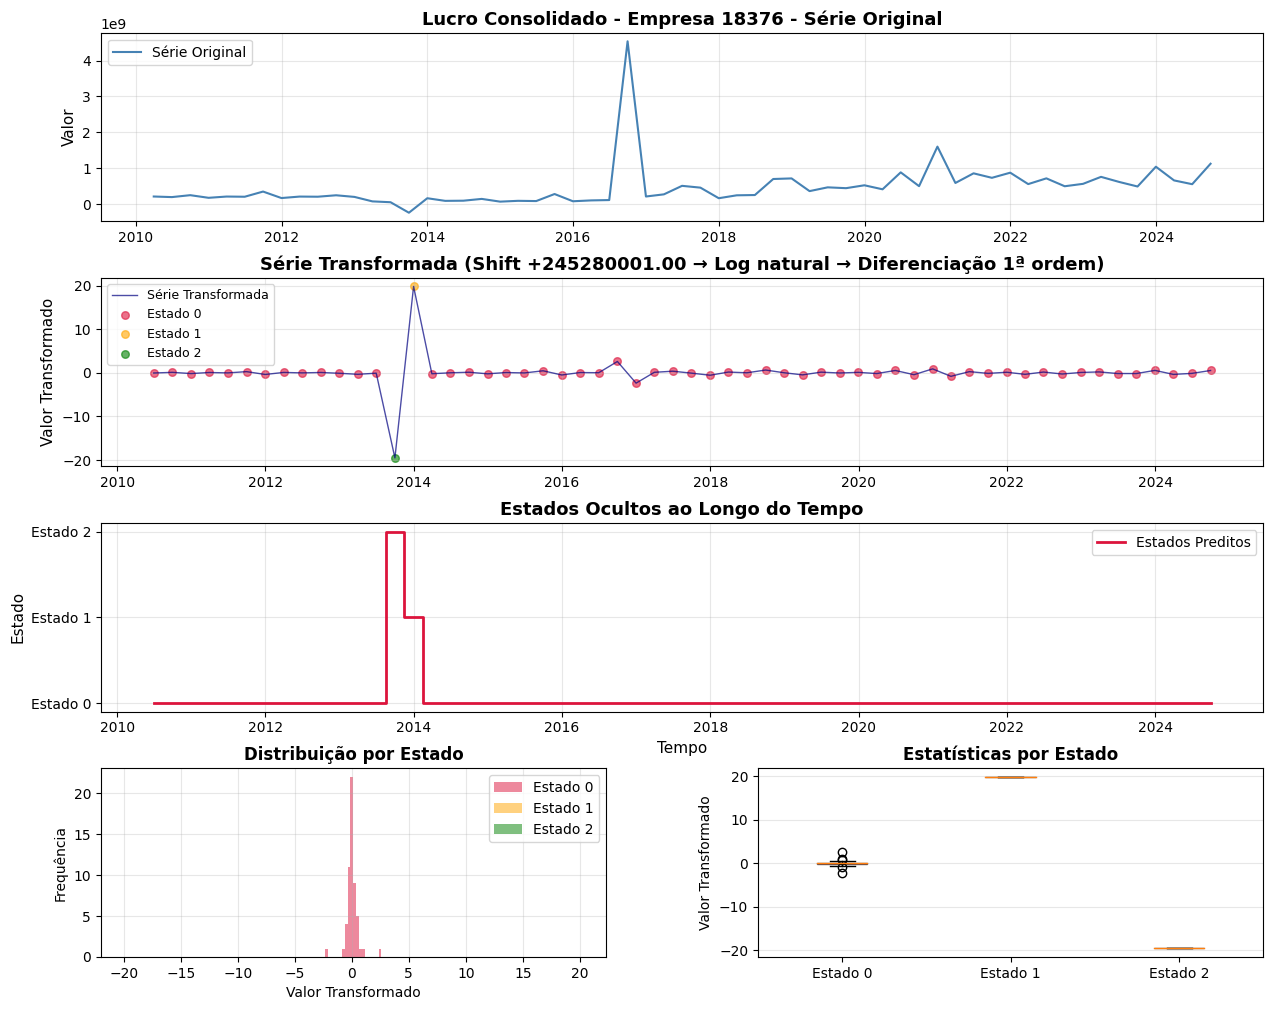


Processando: Despesas Operacionais

RESUMO DO MODELO GAUSSIANHMM - Despesas Operacionais - Empresa 18376

--- Transformações Aplicadas ---
1. Shift +549725001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -19.63
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.018 0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]]

--- Médias por Estado ---
[[  0.021]
 [-20.051]
 [ 20.074]]

--- Covariâncias por Estado ---

Estado 0:
[[0.109]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.021273        0.33314  -1.358982   1.568251
      1              1    1.724138 -20.050552            NaN -20.050552 -2

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


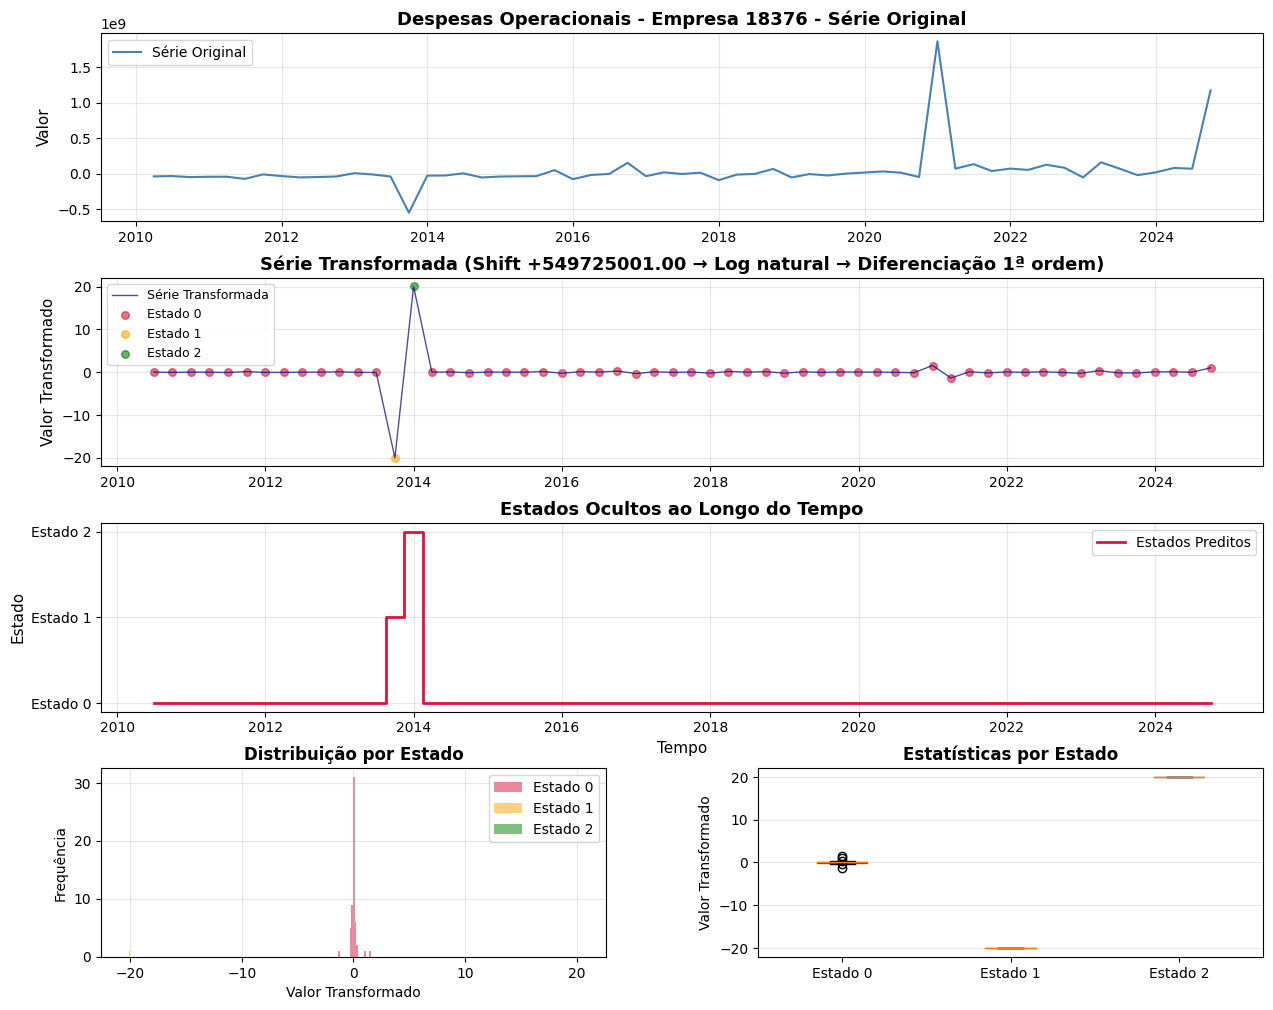


COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR

Resultado Bruto:
 estado  n_observacoes  percentual     media
      0             53   91.379310  0.039261
      1              2    3.448276  2.219865
      2              3    5.172414 -1.708438

Lucro Consolidado:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.013988
      1              1    1.724138  19.817084
      2              1    1.724138 -19.494573

Despesas Operacionais:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.021273
      1              1    1.724138 -20.050552
      2              1    1.724138  20.073812


In [23]:
# Análise de múltiplos indicadores
empresa_analise = '18376'

indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

resultados_gaussian = comparar_multiplos_indicadores_gaussianhmm(
    empresa=empresa_analise,
    indicadores_dict=indicadores,
    n_estados=3,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100
)

# Comparação consolidada dos estados
print("\n" + "="*70)
print("COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR")
print("="*70)

for nome, resultado in resultados_gaussian.items():
    print(f"\n{nome}:")
    print(resultado['estatisticas_estados'][['estado', 'n_observacoes', 'percentual', 'media']].to_string(index=False))


Processando: Resultado Bruto

RESUMO DO MODELO GAUSSIANHMM - Resultado Bruto - Empresa 2437

--- Transformações Aplicadas ---
1. Shift +4840844001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -6.15
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.018 0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]]

--- Médias por Estado ---
[[ 1.0000e-02]
 [-2.3346e+01]
 [ 2.3147e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.068]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.010111        0.26185  -1.036753   1.184445
      1              1    1.724138 -23.346220            NaN -23.346220 -23

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


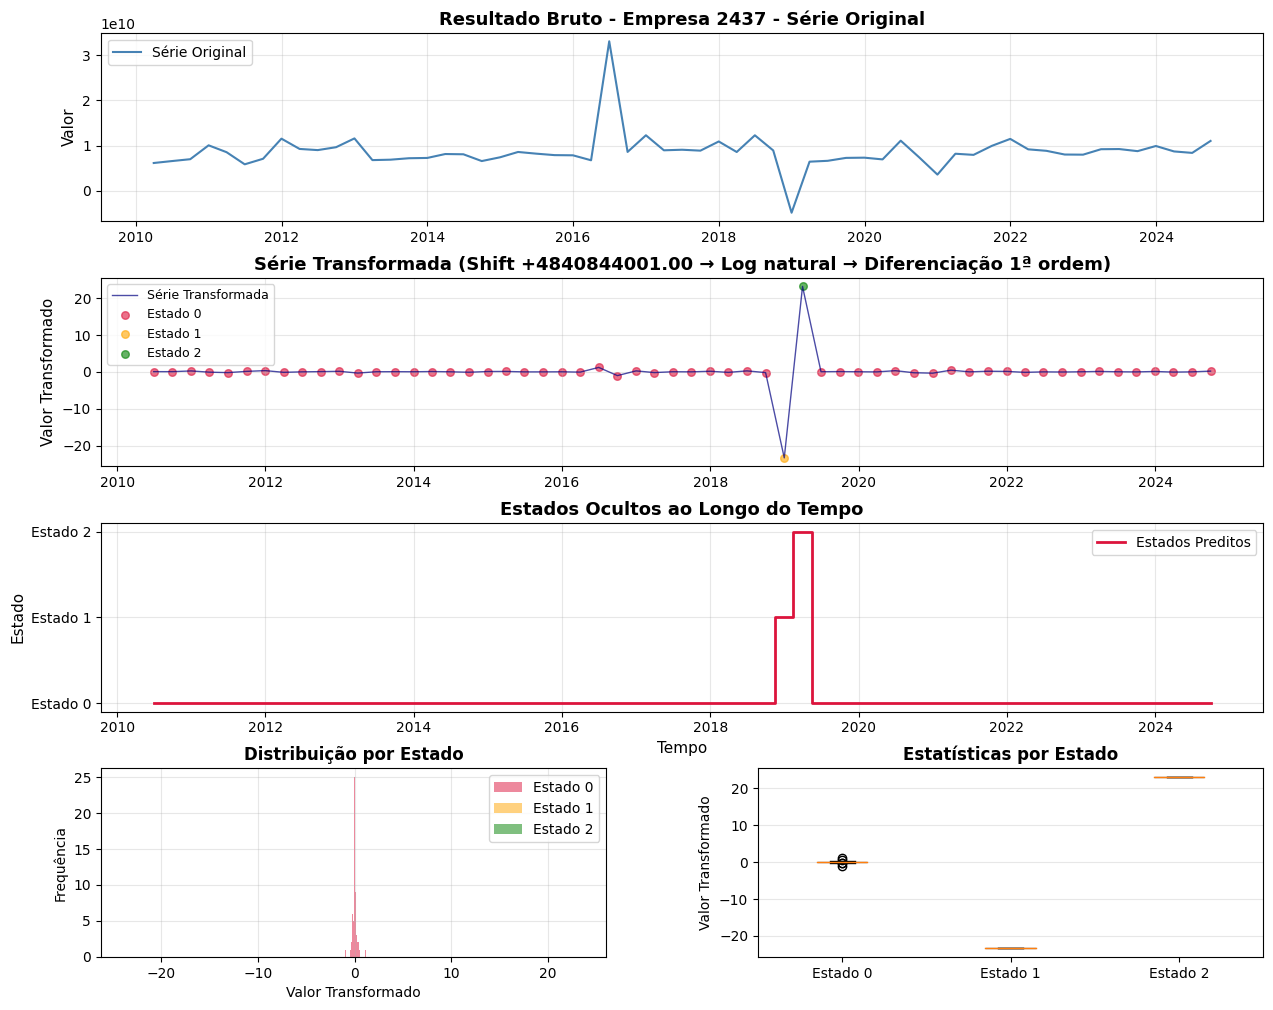


Processando: Lucro Consolidado

RESUMO DO MODELO GAUSSIANHMM - Lucro Consolidado - Empresa 2437

--- Transformações Aplicadas ---
1. Shift +10557849001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0128 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -72.50
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.018 0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]]

--- Médias por Estado ---
[[ 1.1000e-02]
 [-2.3171e+01]
 [ 2.3077e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.72]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.010641       0.856351  -3.967927   4.018834
      1              1    1.724138 -23.171043            NaN -23.17104

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


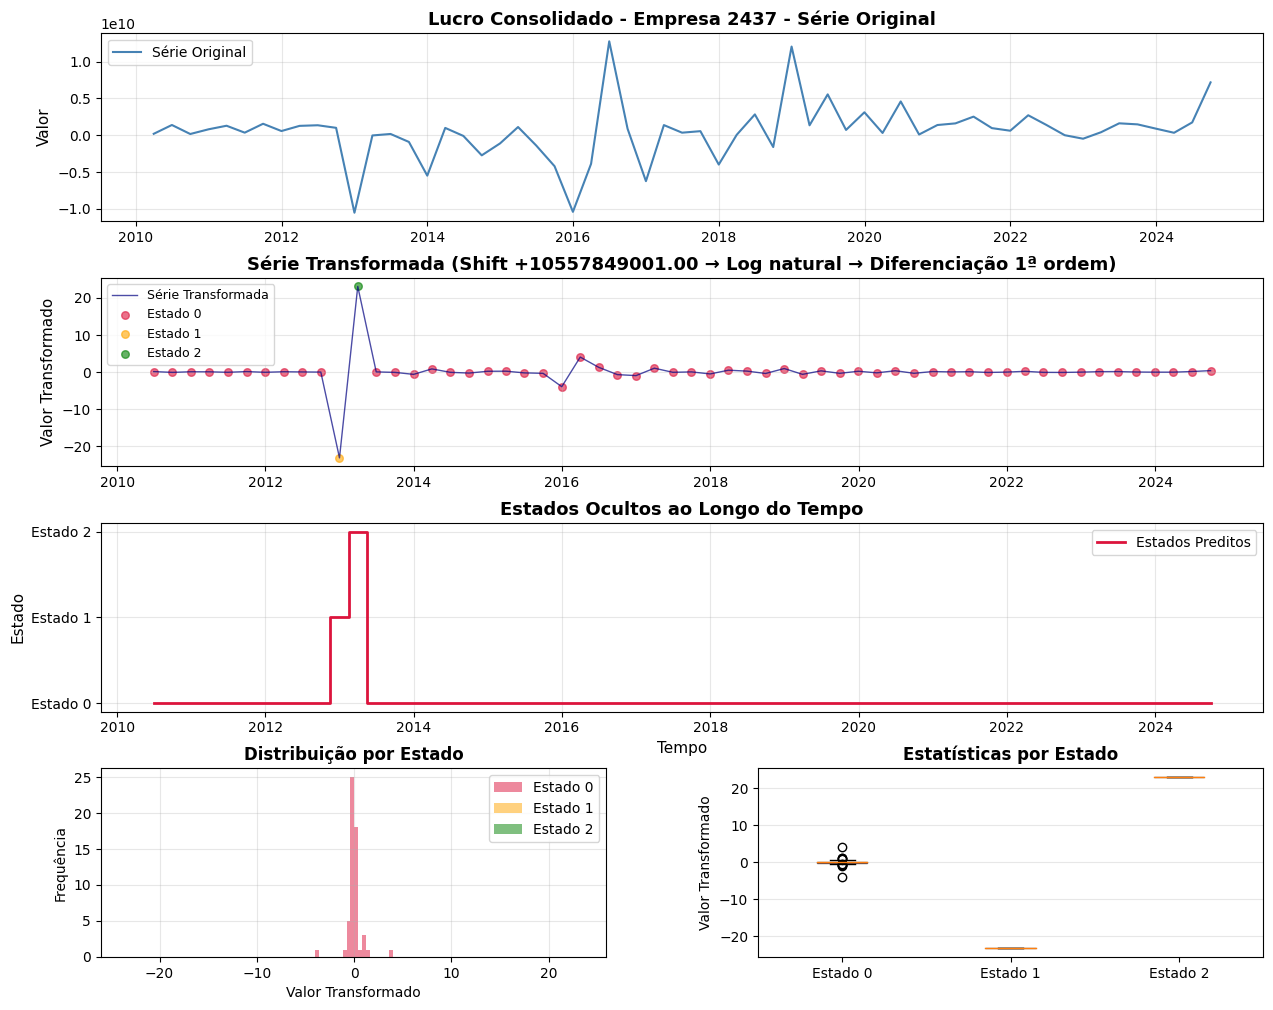


Processando: Despesas Operacionais

RESUMO DO MODELO GAUSSIANHMM - Despesas Operacionais - Empresa 2437

--- Transformações Aplicadas ---
1. Shift +22424616001.00
2. Log natural
3. Diferenciação 1ª ordem

--- Teste de Estacionariedade ---
ADF p-value: 0.0000 ✓ Estacionária
KPSS p-value: 0.0417 ✗ Não estacionária
Conclusão: ✗ SÉRIE NÃO ESTACIONÁRIA

--- Informações do Modelo ---
Convergiu: True
Log-Likelihood: -3.17
Número de observações: 58
Número de estados: 3

--- Matriz de Transição ---
[[0.982 0.    0.018]
 [1.    0.    0.   ]
 [0.    1.    0.   ]]

--- Médias por Estado ---
[[ 7.0000e-03]
 [ 2.3521e+01]
 [-2.3439e+01]]

--- Covariâncias por Estado ---

Estado 0:
[[0.061]]

Estado 1:
[[0.01]]

Estado 2:
[[0.01]]

--- Estatísticas Descritivas por Estado ---
 estado  n_observacoes  percentual      media  desvio_padrao        min        max
      0             56   96.551724   0.007073       0.248309  -0.640364   0.725128
      1              1    1.724138  23.521435            NaN  

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


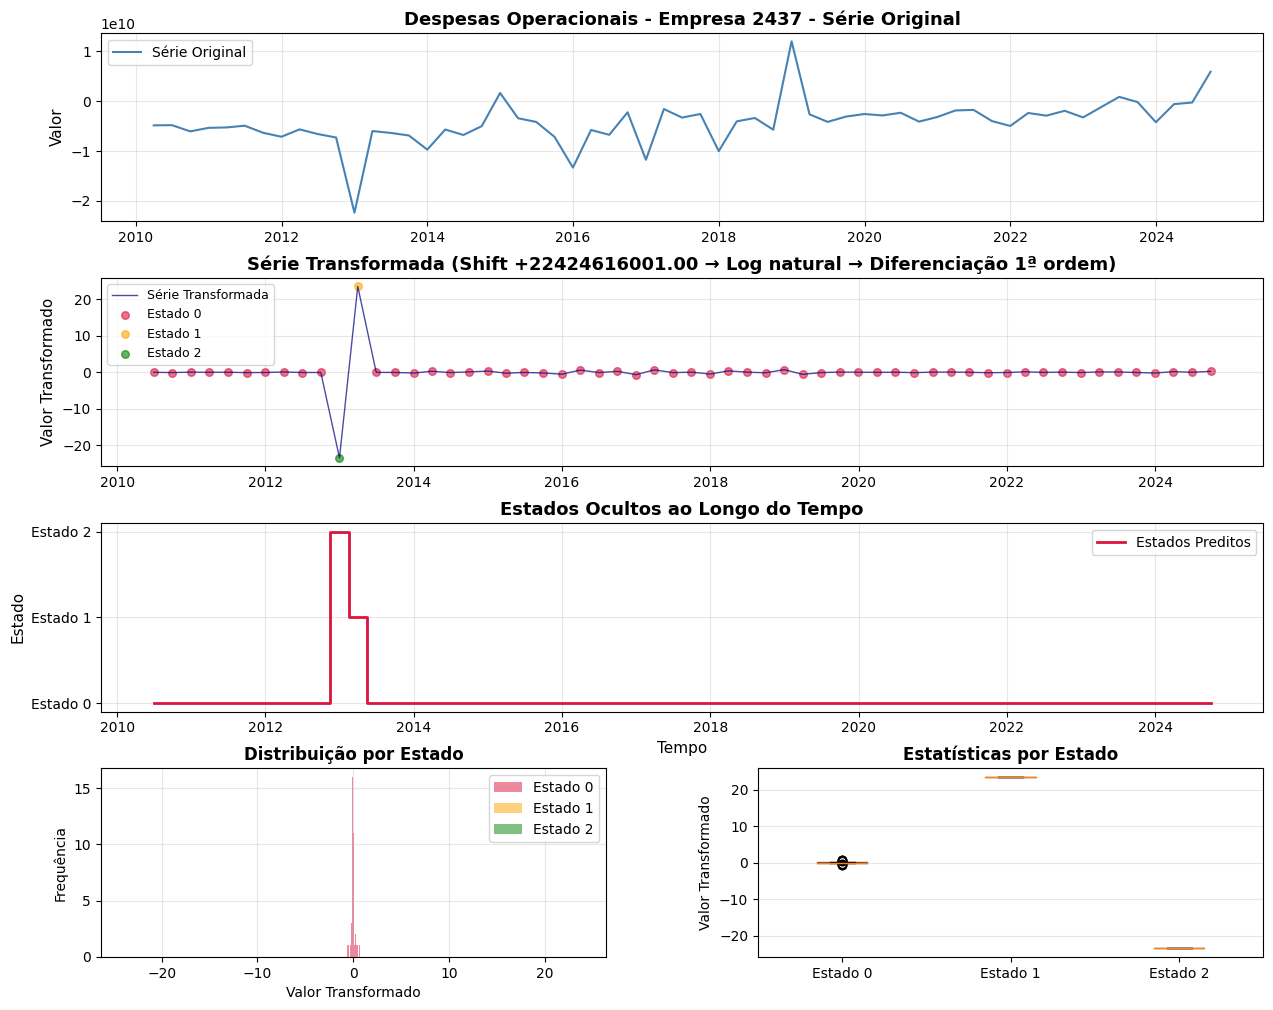


COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR

Resultado Bruto:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.010111
      1              1    1.724138 -23.346220
      2              1    1.724138  23.147414

Lucro Consolidado:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.010641
      1              1    1.724138 -23.171043
      2              1    1.724138  23.076921

Despesas Operacionais:
 estado  n_observacoes  percentual      media
      0             56   96.551724   0.007073
      1              1    1.724138  23.521435
      2              1    1.724138 -23.438989


In [24]:
# Análise de múltiplos indicadores
empresa_analise = '2437'

indicadores = {
    'Resultado Bruto': resultado_bruto[empresa_analise],
    'Lucro Consolidado': lucro_consolidado[empresa_analise],
    'Despesas Operacionais': despesas_operacionais[empresa_analise]
}

resultados_gaussian = comparar_multiplos_indicadores_gaussianhmm(
    empresa=empresa_analise,
    indicadores_dict=indicadores,
    n_estados=3,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100
)

# Comparação consolidada dos estados
print("\n" + "="*70)
print("COMPARAÇÃO CONSOLIDADA - ESTADOS POR INDICADOR")
print("="*70)

for nome, resultado in resultados_gaussian.items():
    print(f"\n{nome}:")
    print(resultado['estatisticas_estados'][['estado', 'n_observacoes', 'percentual', 'media']].to_string(index=False))

EXECUTANDO GRID SEARCH PARA RESULTADO BRUTO

GRID SEARCH GAUSSIANHMM - Resultado Bruto - Empresa 21490
Testando 4 configurações de estados
Com 10 pontos iniciais diferentes
Total de modelos: 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Estados=2, Seed=103 → LL=9.62, AIC=-5.24, BIC=9.19, Conv=✓
Estados=2, Seed=436 → LL=9.62, AIC=-5.24, BIC=9.18, Conv=✓
Estados=2, Seed=861 → LL=9.62, AIC=-5.24, BIC=9.19, Conv=✓
Estados=2, Seed=271 → LL=9.62, AIC=-5.24, BIC=9.19, Conv=✓
Estados=2, Seed=107 → LL=9.62, AIC=-5.23, BIC=9.19, Conv=✓
Estados=2, Seed= 72 → LL=-2.73, AIC=19.47, BIC=33.89, Conv=✓
Estados=2, Seed=701 → LL=9.62, AIC=-5.24, BIC=9.19, Conv=✓
Estados=2, Seed= 21 → LL=9.62, AIC=-5.24, BIC=9.19, Conv=✓
Estados=2, Seed=615 → LL=9.62, AIC=-5.23, BIC=9.19, Conv=✓
Estados=2, Seed=122 → LL=9.62, AIC=-5.23, BIC=9.19, Conv=✓
Estados=3, Seed=103 → LL=11.26, AIC=5.49, BIC=34.34, Conv=✓
Estados=3, Seed=436 → LL=11.26, AIC=5.48, BIC=34.32, Conv=✓
Estados=3, Seed=861 → LL=11.75, AIC=4.50, BIC=33.35, Conv=✓
Estados=3, Seed=271 → LL=11.26, AIC=5.48, BIC=34.32, Conv=✓
Estados=3, Seed=107 → LL=10.18, AIC=7.64, BIC=36.48, Conv=✓
Estados=3, Seed= 72 → LL=11.73, AIC=4.54, BIC=33.39, Conv=✓
Estados=3, Seed=701 → LL=11.61, AIC=4.78, BIC=33

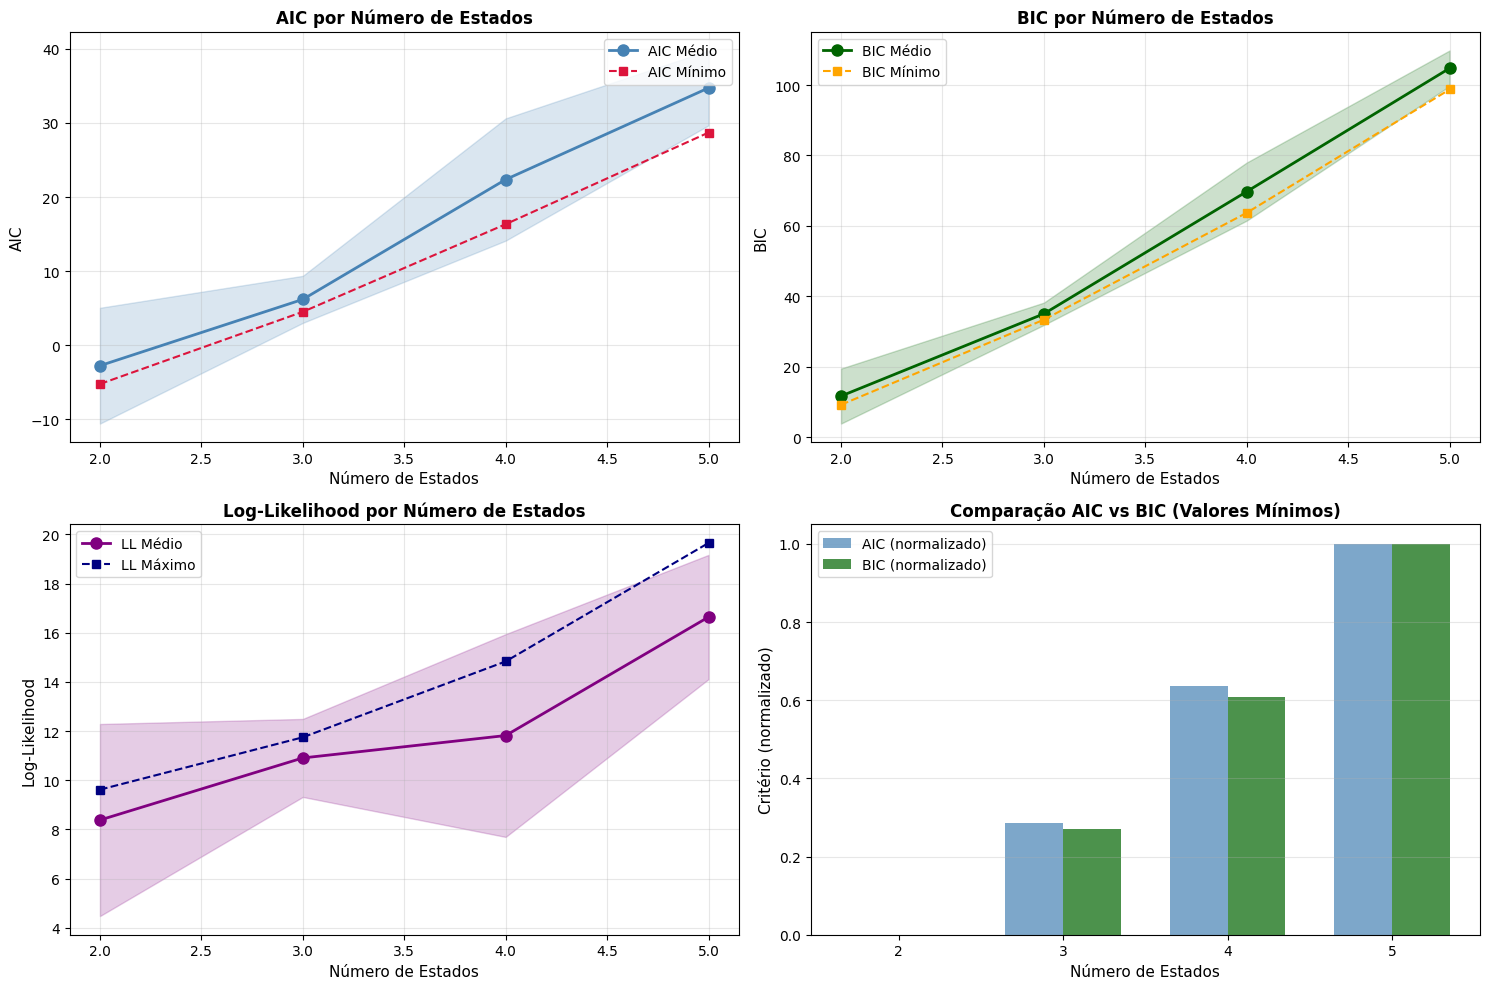


=== TOP 10 MODELOS POR BIC ===


n_estados  random_state  log_likelihood       aic        bic  convergiu
1           2           436        9.619154 -5.238309   9.184792       True
7           2            21        9.618896 -5.237791   9.185310       True
6           2           701        9.618767 -5.237535   9.185567       True
3           2           271        9.618420 -5.236840   9.186261       True
2           2           861        9.618351 -5.236702   9.186399       True
0           2           103        9.617910 -5.235820   9.187282       True
8           2           615        9.617254 -5.234507   9.188594       True
9           2           122        9.617131 -5.234262   9.188840       True
4           2           107        9.616117 -5.232234   9.190867       True
12          3           861       11.748269  4.503463  33.349665       True

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1652698472.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


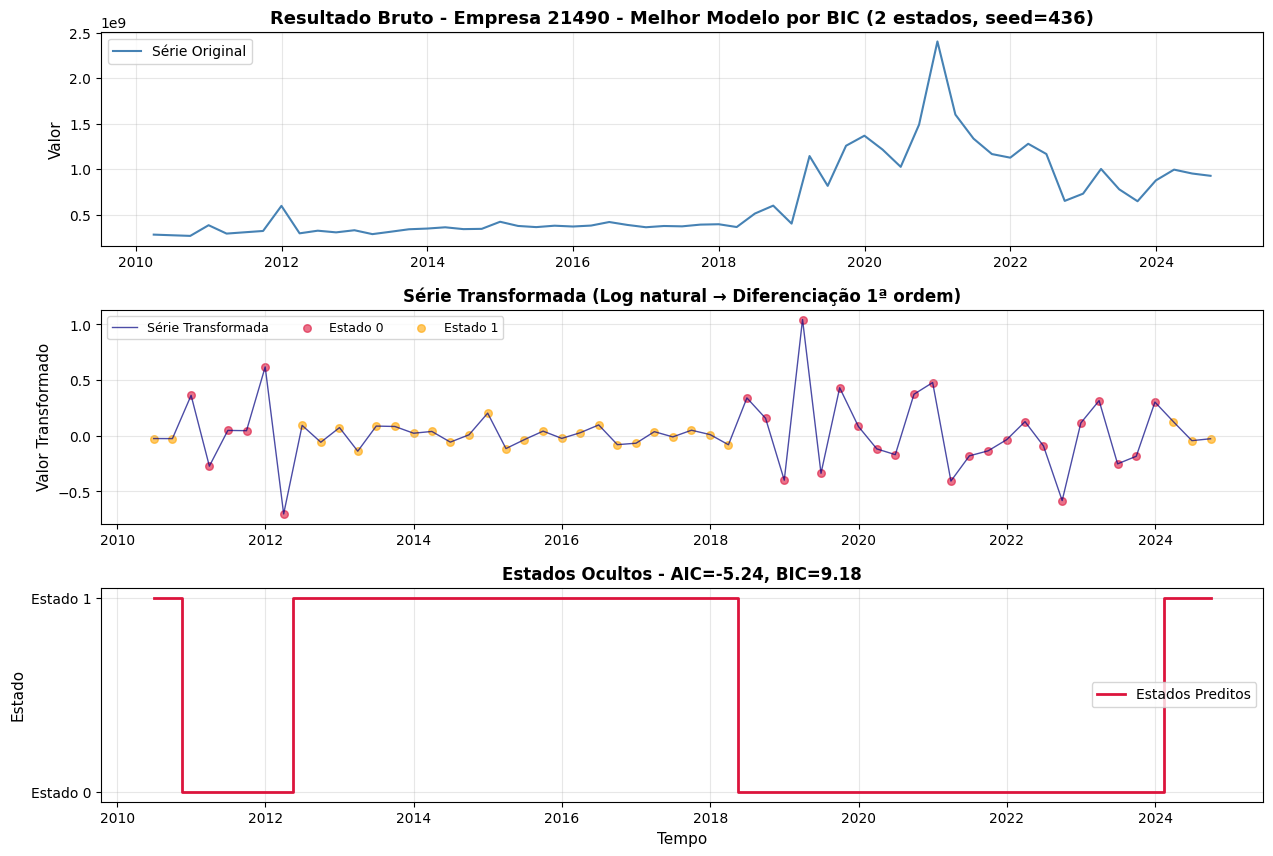


ESTATÍSTICAS DO MELHOR MODELO POR BIC

Número de Estados: 2
Random State: 436
Convergiu: True
Log-Likelihood: 9.6192
AIC: -5.2383
BIC: 9.1848

--- Matriz de Transição ---
[[0.88  0.12 ]
 [0.127 0.873]]

--- Estatísticas por Estado ---
 estado  n_observacoes  percentual    media  desvio_padrao
      0             29        50.0 0.033666       0.380064
      1             29        50.0 0.007418       0.076666


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1652698472.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


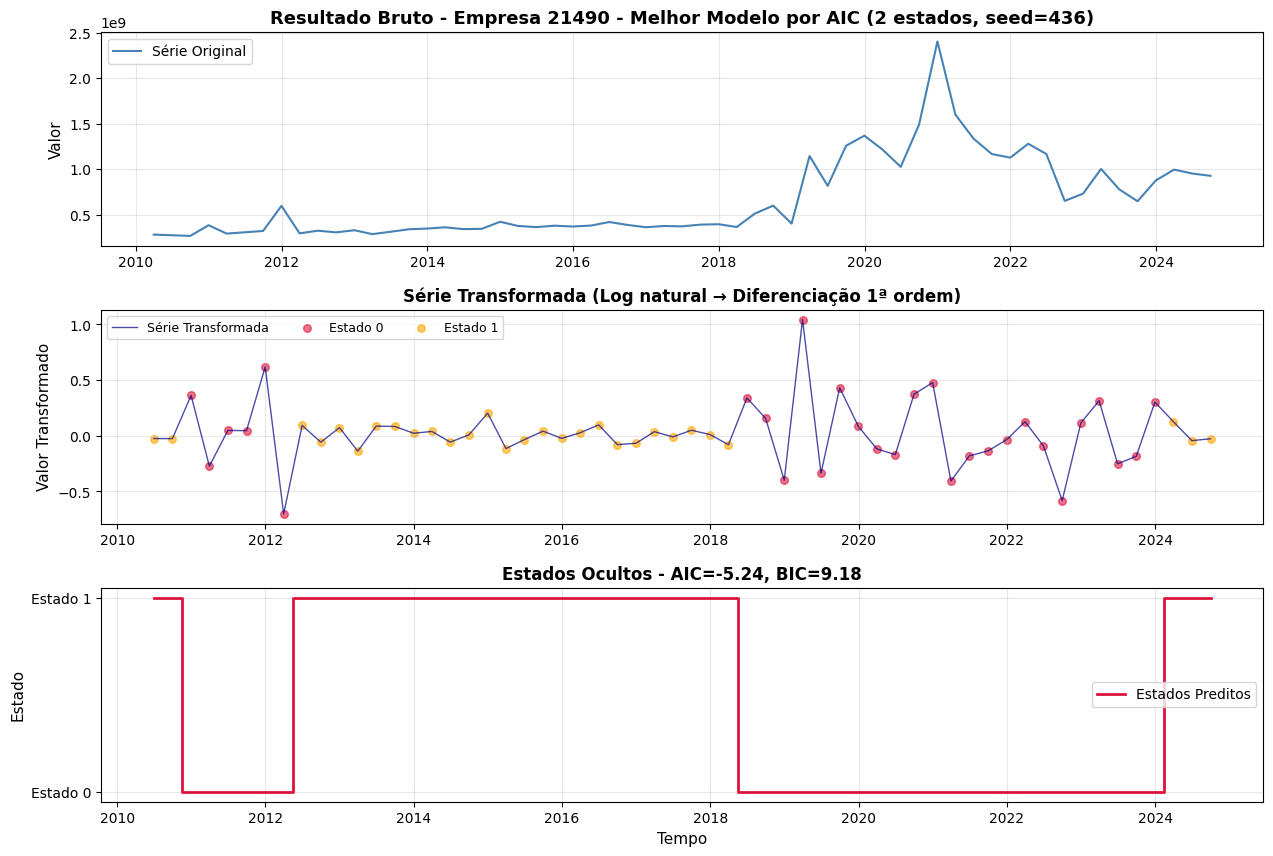


ESTATÍSTICAS DO MELHOR MODELO POR AIC

Número de Estados: 2
Random State: 436
Convergiu: True
Log-Likelihood: 9.6192
AIC: -5.2383
BIC: 9.1848

--- Matriz de Transição ---
[[0.88  0.12 ]
 [0.127 0.873]]

--- Estatísticas por Estado ---
 estado  n_observacoes  percentual    media  desvio_padrao
      0             29        50.0 0.033666       0.380064
      1             29        50.0 0.007418       0.076666


In [25]:
def calcular_aic_bic(model, obs_sequencia):
    """
    Calcula AIC e BIC para um modelo HMM treinado.
    
    Args:
        model: modelo HMM treinado
        obs_sequencia: observações usadas no treinamento (array 2D)
    
    Returns:
        tuple: (aic, bic)
    """
    n_samples = len(obs_sequencia)
    log_likelihood = model.score(obs_sequencia)
    
    # Número de parâmetros livres
    n_states = model.n_components
    n_features = obs_sequencia.shape[1]
    
    # Parâmetros:
    # - Probabilidades iniciais: n_states - 1
    # - Matriz de transição: n_states * (n_states - 1)
    # - Médias: n_states * n_features
    # - Covariâncias (full): n_states * n_features * (n_features + 1) / 2
    n_params = (
        (n_states - 1) +  # startprob
        n_states * (n_states - 1) +  # transmat
        n_states * n_features +  # means
        n_states * n_features * (n_features + 1) / 2  # covars (full)
    )
    
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_samples)
    
    return aic, bic

def grid_search_gaussianhmm(serie, nome_serie='Série', 
                            estados_range=(2, 6), 
                            n_iter=100, 
                            random_states=None,
                            aplicar_log=True, 
                            diferenciacao=1):
    """
    Grid search para GaussianHMM variando número de estados e pontos iniciais.
    Seleciona melhor modelo usando AIC e BIC.
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        estados_range: tuple (min, max) para número de estados
        n_iter: iterações do Baum-Welch
        random_states: lista de seeds (default: 10 valores aleatórios)
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
    
    Returns:
        dict com resultados e melhor modelo
    """
    # Define random_states padrão se não fornecido
    if random_states is None:
        np.random.seed(42)
        random_states = np.random.randint(1, 1000, size=10).tolist()
    
    # Prepara série
    serie_transformada, serie_original, transformacoes = preparar_serie_gaussianhmm(
        serie, aplicar_log, diferenciacao
    )
    
    # Testa estacionariedade
    teste_estacionariedade = testar_estacionariedade(serie_transformada, nome_serie)
    
    obs_sequencia = serie_transformada.to_numpy().reshape(-1, 1)
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH GAUSSIANHMM - {nome_serie}")
    print(f"{'='*70}")
    print(f"Testando {len(range(estados_range[0], estados_range[1]))} configurações de estados")
    print(f"Com {len(random_states)} pontos iniciais diferentes")
    print(f"Total de modelos: {len(range(estados_range[0], estados_range[1])) * len(random_states)}")
    print(f"Transformações: {' → '.join(transformacoes)}")
    print(f"Série estacionária: {'✓ SIM' if teste_estacionariedade['conclusao_estacionaria'] else '✗ NÃO'}")
    print('='*70)
    
    resultados = []
    
    for n_estados in range(estados_range[0], estados_range[1]):
        for seed in random_states:
            try:
                # Treina modelo
                model = hmm.GaussianHMM(
                    n_components=n_estados,
                    covariance_type='full',
                    n_iter=n_iter,
                    random_state=seed,
                    verbose=False
                )
                model.fit(obs_sequencia)
                
                # Calcula métricas
                log_likelihood = model.score(obs_sequencia)
                aic, bic = calcular_aic_bic(model, obs_sequencia)
                
                # Decodifica estados
                _, estados_preditos = model.decode(obs_sequencia)
                
                # Calcula estatísticas por estado
                estatisticas_estados = []
                for estado in range(n_estados):
                    mascara = estados_preditos == estado
                    valores_estado = serie_transformada[mascara]
                    
                    if len(valores_estado) > 0:
                        estatisticas_estados.append({
                            'estado': estado,
                            'n_observacoes': mascara.sum(),
                            'percentual': (mascara.sum() / len(estados_preditos)) * 100,
                            'media': valores_estado.mean(),
                            'desvio_padrao': valores_estado.std()
                        })
                
                resultado = {
                    'n_estados': n_estados,
                    'random_state': seed,
                    'convergiu': model.monitor_.converged,
                    'log_likelihood': log_likelihood,
                    'aic': aic,
                    'bic': bic,
                    'modelo': model,
                    'estados': estados_preditos,
                    'estatisticas_estados': estatisticas_estados
                }
                
                resultados.append(resultado)
                
                print(f"Estados={n_estados}, Seed={seed:3d} → "
                      f"LL={log_likelihood:.2f}, AIC={aic:.2f}, BIC={bic:.2f}, "
                      f"Conv={'✓' if model.monitor_.converged else '✗'}")
                
            except Exception as e:
                print(f"Estados={n_estados}, Seed={seed} → ERRO: {str(e)}")
                continue
    
    if not resultados:
        raise ValueError("Nenhum modelo foi treinado com sucesso!")
    
    # Cria DataFrame com resultados
    df_resultados = pd.DataFrame([
        {
            'n_estados': r['n_estados'],
            'random_state': r['random_state'],
            'log_likelihood': r['log_likelihood'],
            'aic': r['aic'],
            'bic': r['bic'],
            'convergiu': r['convergiu']
        }
        for r in resultados
    ])
    
    # Identifica melhores modelos
    melhor_aic_idx = df_resultados['aic'].idxmin()
    melhor_bic_idx = df_resultados['bic'].idxmin()
    melhor_ll_idx = df_resultados['log_likelihood'].idxmax()
    
    melhor_aic = resultados[melhor_aic_idx]
    melhor_bic = resultados[melhor_bic_idx]
    melhor_ll = resultados[melhor_ll_idx]
    
    print(f"\n{'='*70}")
    print("RESUMO DOS RESULTADOS")
    print('='*70)
    print(f"\n✓ MELHOR MODELO POR AIC:")
    print(f"  Estados: {melhor_aic['n_estados']}, Seed: {melhor_aic['random_state']}")
    print(f"  AIC: {melhor_aic['aic']:.2f}, BIC: {melhor_aic['bic']:.2f}, LL: {melhor_aic['log_likelihood']:.2f}")
    
    print(f"\n✓ MELHOR MODELO POR BIC:")
    print(f"  Estados: {melhor_bic['n_estados']}, Seed: {melhor_bic['random_state']}")
    print(f"  AIC: {melhor_bic['aic']:.2f}, BIC: {melhor_bic['bic']:.2f}, LL: {melhor_bic['log_likelihood']:.2f}")
    
    print(f"\n✓ MELHOR MODELO POR LOG-LIKELIHOOD:")
    print(f"  Estados: {melhor_ll['n_estados']}, Seed: {melhor_ll['random_state']}")
    print(f"  AIC: {melhor_ll['aic']:.2f}, BIC: {melhor_ll['bic']:.2f}, LL: {melhor_ll['log_likelihood']:.2f}")
    print('='*70)
    
    return {
        'nome': nome_serie,
        'serie_original': serie_original,
        'serie_transformada': serie_transformada,
        'transformacoes': transformacoes,
        'index': serie_transformada.index,
        'teste_estacionariedade': teste_estacionariedade,
        'df_resultados': df_resultados,
        'todos_resultados': resultados,
        'melhor_aic': melhor_aic,
        'melhor_bic': melhor_bic,
        'melhor_ll': melhor_ll
    }

def plotar_comparacao_modelos(resultado_grid):
    """
    Plota comparação de AIC/BIC por número de estados.
    
    Args:
        resultado_grid: dict retornado por grid_search_gaussianhmm
    """
    df = resultado_grid['df_resultados']
    
    # Agrupa por número de estados e calcula estatísticas
    stats_por_estado = df.groupby('n_estados').agg({
        'aic': ['mean', 'min', 'std'],
        'bic': ['mean', 'min', 'std'],
        'log_likelihood': ['mean', 'max', 'std']
    }).reset_index()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. AIC por número de estados
    ax1 = axes[0, 0]
    estados = stats_por_estado['n_estados']
    ax1.plot(estados, stats_por_estado['aic']['mean'], 'o-', 
             color='steelblue', linewidth=2, markersize=8, label='AIC Médio')
    ax1.plot(estados, stats_por_estado['aic']['min'], 's--', 
             color='crimson', linewidth=1.5, markersize=6, label='AIC Mínimo')
    ax1.fill_between(estados, 
                     stats_por_estado['aic']['mean'] - stats_por_estado['aic']['std'],
                     stats_por_estado['aic']['mean'] + stats_por_estado['aic']['std'],
                     alpha=0.2, color='steelblue')
    ax1.set_xlabel('Número de Estados', fontsize=11)
    ax1.set_ylabel('AIC', fontsize=11)
    ax1.set_title('AIC por Número de Estados', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. BIC por número de estados
    ax2 = axes[0, 1]
    ax2.plot(estados, stats_por_estado['bic']['mean'], 'o-', 
             color='darkgreen', linewidth=2, markersize=8, label='BIC Médio')
    ax2.plot(estados, stats_por_estado['bic']['min'], 's--', 
             color='orange', linewidth=1.5, markersize=6, label='BIC Mínimo')
    ax2.fill_between(estados, 
                     stats_por_estado['bic']['mean'] - stats_por_estado['bic']['std'],
                     stats_por_estado['bic']['mean'] + stats_por_estado['bic']['std'],
                     alpha=0.2, color='darkgreen')
    ax2.set_xlabel('Número de Estados', fontsize=11)
    ax2.set_ylabel('BIC', fontsize=11)
    ax2.set_title('BIC por Número de Estados', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Log-Likelihood por número de estados
    ax3 = axes[1, 0]
    ax3.plot(estados, stats_por_estado['log_likelihood']['mean'], 'o-', 
             color='purple', linewidth=2, markersize=8, label='LL Médio')
    ax3.plot(estados, stats_por_estado['log_likelihood']['max'], 's--', 
             color='navy', linewidth=1.5, markersize=6, label='LL Máximo')
    ax3.fill_between(estados, 
                     stats_por_estado['log_likelihood']['mean'] - stats_por_estado['log_likelihood']['std'],
                     stats_por_estado['log_likelihood']['mean'] + stats_por_estado['log_likelihood']['std'],
                     alpha=0.2, color='purple')
    ax3.set_xlabel('Número de Estados', fontsize=11)
    ax3.set_ylabel('Log-Likelihood', fontsize=11)
    ax3.set_title('Log-Likelihood por Número de Estados', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Comparação AIC vs BIC (valores mínimos)
    ax4 = axes[1, 1]
    # Normaliza para comparação visual
    aic_min_norm = (stats_por_estado['aic']['min'] - stats_por_estado['aic']['min'].min()) / \
                   (stats_por_estado['aic']['min'].max() - stats_por_estado['aic']['min'].min())
    bic_min_norm = (stats_por_estado['bic']['min'] - stats_por_estado['bic']['min'].min()) / \
                   (stats_por_estado['bic']['min'].max() - stats_por_estado['bic']['min'].min())
    
    x = np.arange(len(estados))
    width = 0.35
    ax4.bar(x - width/2, aic_min_norm, width, label='AIC (normalizado)', color='steelblue', alpha=0.7)
    ax4.bar(x + width/2, bic_min_norm, width, label='BIC (normalizado)', color='darkgreen', alpha=0.7)
    ax4.set_xlabel('Número de Estados', fontsize=11)
    ax4.set_ylabel('Critério (normalizado)', fontsize=11)
    ax4.set_title('Comparação AIC vs BIC (Valores Mínimos)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(estados)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plotar_melhor_modelo(resultado_grid, criterio='bic'):
    """
    Plota resultados do melhor modelo segundo critério escolhido.
    
    Args:
        resultado_grid: dict retornado por grid_search_gaussianhmm
        criterio: 'aic', 'bic' ou 'll' (log-likelihood)
    """
    if criterio == 'aic':
        melhor = resultado_grid['melhor_aic']
        titulo_criterio = 'AIC'
    elif criterio == 'bic':
        melhor = resultado_grid['melhor_bic']
        titulo_criterio = 'BIC'
    else:
        melhor = resultado_grid['melhor_ll']
        titulo_criterio = 'Log-Likelihood'
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Série Original
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(resultado_grid['serie_original'].index, resultado_grid['serie_original'], 
             color='steelblue', linewidth=1.5, label='Série Original')
    ax1.set_title(f"{resultado_grid['nome']} - Melhor Modelo por {titulo_criterio} "
                  f"({melhor['n_estados']} estados, seed={melhor['random_state']})", 
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel('Valor', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # 2. Série Transformada com Estados
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(resultado_grid['index'], resultado_grid['serie_transformada'], 
             color='navy', linewidth=1, alpha=0.7, label='Série Transformada')
    
    cores_estados = ['crimson', 'orange', 'green', 'purple', 'brown', 'pink']
    for estado in range(melhor['n_estados']):
        mascara = melhor['estados'] == estado
        ax2.scatter(resultado_grid['index'][mascara], 
                   resultado_grid['serie_transformada'][mascara],
                   c=cores_estados[estado % len(cores_estados)], 
                   s=30, alpha=0.6, label=f'Estado {estado}')
    
    transformacoes_str = ' → '.join(resultado_grid['transformacoes'])
    ax2.set_title(f"Série Transformada ({transformacoes_str})", fontsize=12, fontweight='bold')
    ax2.set_ylabel('Valor Transformado', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9, ncol=3)
    
    # 3. Estados ao longo do tempo
    ax3 = fig.add_subplot(gs[2, :])
    ax3.step(resultado_grid['index'], melhor['estados'], where='mid', 
             color='crimson', linewidth=2, label='Estados Preditos')
    ax3.set_title(f'Estados Ocultos - AIC={melhor["aic"]:.2f}, BIC={melhor["bic"]:.2f}', 
                  fontsize=12, fontweight='bold')
    ax3.set_xlabel('Tempo', fontsize=11)
    ax3.set_ylabel('Estado', fontsize=11)
    ax3.set_yticks(range(melhor['n_estados']))
    ax3.set_yticklabels([f'Estado {i}' for i in range(melhor['n_estados'])])
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Exibe estatísticas do melhor modelo
    print(f"\n{'='*70}")
    print(f"ESTATÍSTICAS DO MELHOR MODELO POR {titulo_criterio}")
    print('='*70)
    print(f"\nNúmero de Estados: {melhor['n_estados']}")
    print(f"Random State: {melhor['random_state']}")
    print(f"Convergiu: {melhor['convergiu']}")
    print(f"Log-Likelihood: {melhor['log_likelihood']:.4f}")
    print(f"AIC: {melhor['aic']:.4f}")
    print(f"BIC: {melhor['bic']:.4f}")
    
    print(f"\n--- Matriz de Transição ---")
    print(melhor['modelo'].transmat_.round(3))
    
    print(f"\n--- Estatísticas por Estado ---")
    df_stats = pd.DataFrame(melhor['estatisticas_estados'])
    print(df_stats.to_string(index=False))
    print('='*70)

# ==========================================
# EXEMPLO DE USO
# ==========================================

# Grid search para uma empresa
empresa_analise = '21490'

print("EXECUTANDO GRID SEARCH PARA RESULTADO BRUTO")
resultado_grid_rb = grid_search_gaussianhmm(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    estados_range=(2, 6),  # Testa 2, 3, 4, 5 estados
    n_iter=100,
    random_states=None,  # Usa 10 seeds aleatórios
    aplicar_log=True,
    diferenciacao=1
)

# Plota comparação de modelos
plotar_comparacao_modelos(resultado_grid_rb)

# Exibe tabela resumo
print("\n=== TOP 10 MODELOS POR BIC ===")
display(resultado_grid_rb['df_resultados'].sort_values('bic').head(10))

# Plota melhor modelo por BIC
plotar_melhor_modelo(resultado_grid_rb, criterio='bic')

# Plota melhor modelo por AIC
plotar_melhor_modelo(resultado_grid_rb, criterio='aic')

VALIDAÇÃO ONE-STEP-AHEAD PARA RESULTADO BRUTO

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000
Previsão 20/40: Estado_atual=0, Estado_pred=1, Prob=0.812
Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.950
Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.495

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4500
RMSE: 0.2918
MAE: 0.2177
Correlação: 0.1625


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


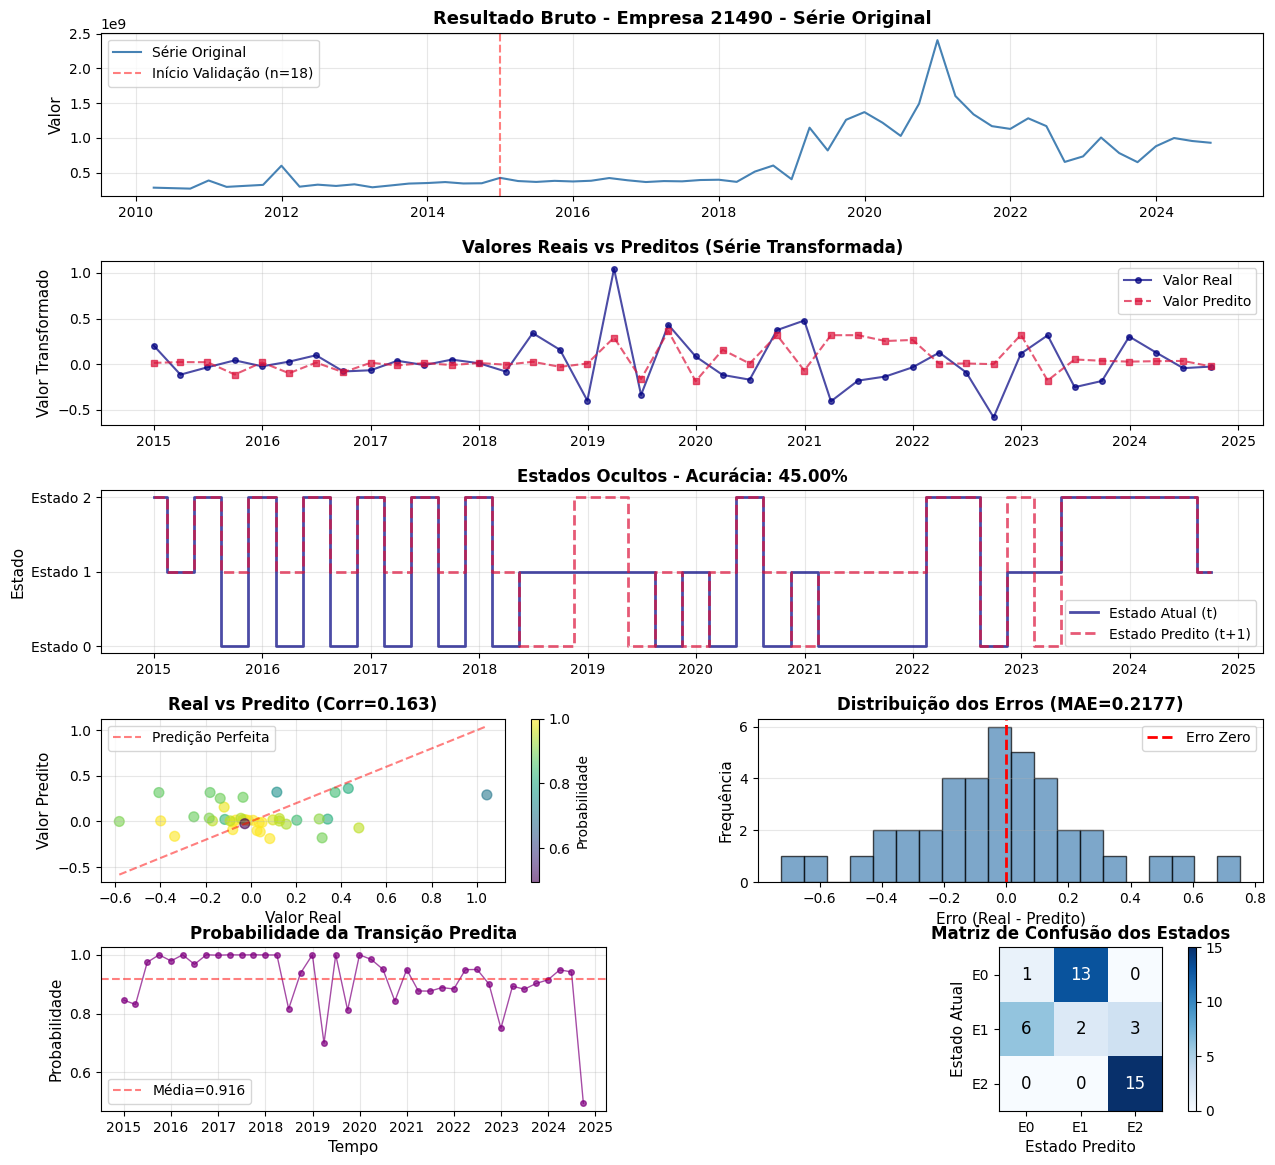


=== PRIMEIRAS 10 PREVISÕES ===


estado_atual  estado_predito  valor_real  valor_predito  \
2014-12-31             2               2    0.203306       0.014093   
2015-03-31             1               1   -0.115018       0.022673   
2015-06-30             2               2   -0.034358       0.021390   
2015-09-30             0               1    0.041631      -0.113594   
2015-12-31             2               2   -0.023646       0.018920   
2016-03-31             0               1    0.027387      -0.099483   
2016-06-30             2               2    0.097442       0.017395   
2016-09-30             0               1   -0.079944      -0.088911   
2016-12-31             2               2   -0.066865       0.015232   
2017-03-31             0               1    0.036828      -0.013776   

            probabilidade  
2014-12-31       0.845768  
2015-03-31       0.830895  
2015-06-30       0.974474  
2015-09-30       1.000000  
2015-12-31       0.979162  
2016-03-31       1.000000  
2016-06-30       0.967600  
2016-09-30       1.000000  
2016-12-31       0.998755  
2017-03-31       1.000000



EXECUTANDO GRID SEARCH COM VALIDAÇÃO

GRID SEARCH COM VALIDAÇÃO ONE-STEP-AHEAD - Resultado Bruto - Empresa 21490
Testando 4 configurações de estados
Com 5 pontos iniciais diferentes
Janela de treino: 18

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.871


Model is not converging.  Current: 19.713380897177505 is not greater than 19.714295935165445. Delta is -0.0009150379879407922


Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.787
Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.864
Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.907

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 1.0000
RMSE: 0.2841
MAE: 0.2015
Correlação: -0.1422

Estados=2, Seed=  1 → Acur=1.000, RMSE=0.2841, Corr=-0.142

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.960
Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.923
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.893
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.904

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.9750
RMSE: 0.2768
MAE: 0.1937
Correlação: 0.0829

Estados=2, Seed= 42 → Acur=0.975, RMSE=0.2768, Corr=0.083

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.960
Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.797
Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.864
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.907

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.9750
RMSE: 0.2797
MAE: 0.1967
Correlação: 0.0011

Estados=2, Seed= 99 → Acur=0.975, RMSE=0.2797, Corr=0.001

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Model is not converging.  Current: 12.105598056777684 is not greater than 12.107208995553172. Delta is -0.0016109387754887905
Model is not converging.  Current: 13.011113703677086 is not greater than 13.013188135158176. Delta is -0.0020744314810894338
Model is not converging.  Current: 14.785976126749325 is not greater than 14.786254875366236. Delta is -0.0002787486169104625


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.864


Model is not converging.  Current: 17.834322651191446 is not greater than 17.836202795241082. Delta is -0.001880144049636101


Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.778
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.864
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.906

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.9750
RMSE: 0.2852
MAE: 0.2016
Correlação: -0.1445

Estados=2, Seed=150 → Acur=0.975, RMSE=0.2852, Corr=-0.145

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.872
Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.782
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.885
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.905

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.8500
RMSE: 0.2808
MAE: 0.1995
Correlação: 0.0271

Estados=2, Seed=200 → Acur=0.850, RMSE=0.2808, Corr=0.027

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.902
Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.517
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.882
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.874

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5750
RMSE: 0.3438
MAE: 0.2480
Correlação: -0.1033

Estados=3, Seed=  1 → Acur=0.575, RMSE=0.3438, Corr=-0.103

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000
Previsão 20/40: Estado_atual=0, Estado_pred=1, Prob=0.812
Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.950


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Model is not converging.  Current: 9.368001908722205 is not greater than 9.388788079820449. Delta is -0.02078617109824421


Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.495

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4500
RMSE: 0.2918
MAE: 0.2177
Correlação: 0.1625

Estados=3, Seed= 42 → Acur=0.450, RMSE=0.2918, Corr=0.163

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 11.549046685817366 is not greater than 11.550601573512408. Delta is -0.0015548876950415291
Model is not converging.  Current: 12.76261491712868 is not greater than 12.763300650596557. Delta is -0.0006857334678773697


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.903
Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.515
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.881
Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.869

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5750
RMSE: 0.3342
MAE: 0.2379
Correlação: 0.0200

Estados=3, Seed= 99 → Acur=0.575, RMSE=0.3342, Corr=0.020

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Model is not converging.  Current: 10.428339593939477 is not greater than 10.430234537622017. Delta is -0.0018949436825401733
Model is not converging.  Current: 11.565833053000183 is not greater than 11.566760585619237. Delta is -0.0009275326190536504


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.910
Previsão 20/40: Estado_atual=1, Estado_pred=2, Prob=1.000
Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.882
Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.861

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6000
RMSE: 0.3419
MAE: 0.2415
Correlação: 0.1108

Estados=3, Seed=150 → Acur=0.600, RMSE=0.3419, Corr=0.111

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Model is not converging.  Current: 18.26805074246885 is not greater than 18.269186637210016. Delta is -0.0011358947411643783


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.902
Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.509
Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.881


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.869

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5500
RMSE: 0.3555
MAE: 0.2601
Correlação: -0.1697

Estados=3, Seed=200 → Acur=0.550, RMSE=0.3555, Corr=-0.170

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Erro na iteração 21: array must not contain infs or NaNs
Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 20.680190861821544 is not greater than 20.691156134107242. Delta is -0.010965272285698546


Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.669


Model is not converging.  Current: 17.02403880786603 is not greater than 17.026661631739874. Delta is -0.0026228238738426057


Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.839


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.850

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.4359
RMSE: 0.3440
MAE: 0.2440
Correlação: 0.0015

Estados=4, Seed=  1 → Acur=0.436, RMSE=0.3440, Corr=0.001

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.856
Previsão 20/40: Estado_atual=3, Estado_pred=0, Prob=0.671


Model is not converging.  Current: 21.432552886384343 is not greater than 21.43328763667515. Delta is -0.0007347502908068293
Model is not converging.  Current: 21.093256213028866 is not greater than 21.093785955649604. Delta is -0.0005297426207384603
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 43: array must not contain infs or NaNs
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.812


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.835

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.5897
RMSE: 0.3262
MAE: 0.2372
Correlação: 0.1317

Estados=4, Seed= 42 → Acur=0.590, RMSE=0.3262, Corr=0.132

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 15.609555619249683 is not greater than 15.61961313479655. Delta is -0.01005751554686718
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000
Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.826
Previsão 30/40: Estado_atual=2, Estado_pred=1, Prob=0.789


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 53: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=2, Prob=0.999

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.1795
RMSE: 0.3203
MAE: 0.2308
Correlação: 0.1893

Estados=4, Seed= 99 → Acur=0.179, RMSE=0.3203, Corr=0.189

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=2, Estado_pred=2, Prob=0.848


Model is not converging.  Current: 24.053283514507633 is not greater than 24.054491666193574. Delta is -0.0012081516859403507


Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.725
Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.877


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 56: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.740

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.5641
RMSE: 0.3440
MAE: 0.2285
Correlação: 0.0477

Estados=4, Seed=150 → Acur=0.564, RMSE=0.3440, Corr=0.048

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=1.000
Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.723
Previsão 30/40: Estado_atual=3, Estado_pred=3, Prob=0.866


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.821

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6500
RMSE: 0.2927
MAE: 0.1998
Correlação: 0.1836

Estados=4, Seed=200 → Acur=0.650, RMSE=0.2927, Corr=0.184

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Model is not converging.  Current: 16.192642117850703 is not greater than 16.19550735229836. Delta is -0.0028652344476576275
Fitting a model with 34 free scalar parameters with only 23 data poin

Erro na iteração 21: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Model is not converging.  Current: 19.044095491396078 is not greater than 19.046046205258424. Delta is -0.0019507138623460207


Erro na iteração 23: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.


Erro na iteração 25: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.


Erro na iteração 26: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 28 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=1.000


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 35: array must not contain infs or NaNs
Previsão 20/40: Estado_atual=0, Estado_pred=4, Prob=0.739
Previsão 30/40: Estado_atual=2, Estado_pred=1, Prob=1.000


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 50: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 54: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 55: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.877

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 32
Acurácia dos Estados: 0.5938
RMSE: 0.3129
MAE: 0.2320
Correlação: -0.2345

Estados=5, Seed=  1 → Acur=0.594, RMSE=0.3129, Corr=-0.234

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

Erro na iteração 26: array must not contain infs or NaNs
Previsão 10/40: Estado_atual=3, Estado_pred=4, Prob=1.000


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 34: array must not contain infs or NaNs
Previsão 20/40: Estado_atual=3, Estado_pred=0, Prob=1.000


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 42: array must not contain infs or NaNs


Model is not converging.  Current: 23.34056604988824 is not greater than 23.340621617125727. Delta is -5.556723748867398e-05


Previsão 30/40: Estado_atual=1, Estado_pred=0, Prob=0.758


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=1, Prob=0.919

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 37
Acurácia dos Estados: 0.0811
RMSE: 0.2923
MAE: 0.2104
Correlação: 0.0828

Estados=5, Seed= 42 → Acur=0.081, RMSE=0.2923, Corr=0.083

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

Erro na iteração 27: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.


Erro na iteração 28: array must not contain infs or NaNs


Model is not converging.  Current: 25.578334748630134 is not greater than 25.581770733092448. Delta is -0.003435984462313968
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Model is not converging.  Current: 28.691576433831464 is not greater than 28.6928944541572. Delta is -0.0013180203257370238
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum b

Erro na iteração 34: array must not contain infs or NaNs
Previsão 20/40: Estado_atual=3, Estado_pred=0, Prob=0.682


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 38: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Erro na iteração 39: transmat_ rows must sum to 1 (got row sums of [1. 1. 1. 1. 0.])


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 41: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 42: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 43: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 44: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 45: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 46: array must not contain infs or NaNs
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.871


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Erro na iteração 48: array must not contain infs or NaNs


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 49: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 50: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 51: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 52: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 53: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.839

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 23
Acurácia dos Estados: 0.7391
RMSE: 0.3065
MAE: 0.2003
Correlação: 0.2303

Estados=5, Seed= 99 → Acur=0.739, RMSE=0.3065, Corr=0.230

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
Fitting a 

Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=1.000


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.
Model is not converging.  Current: 27.95740980529808 is not greater than 27.967326990595822. Delta is -0.009917185297741327


Previsão 20/40: Estado_atual=2, Estado_pred=4, Prob=0.710


Model is not converging.  Current: 27.427436865850105 is not greater than 27.434084838817274. Delta is -0.0066479729671691246


Previsão 30/40: Estado_atual=4, Estado_pred=4, Prob=0.924


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=3, Estado_pred=3, Prob=0.823

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.3750
RMSE: 0.3078
MAE: 0.2148
Correlação: -0.0545

Estados=5, Seed=150 → Acur=0.375, RMSE=0.3078, Corr=-0.055

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 21490
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.


Erro na iteração 18: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.


Erro na iteração 21: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.


Erro na iteração 22: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Model is not converging.  Current: 18.2310054814933 is not greater than 18.23167392956551. Delta is -0.0006684480722114472


Erro na iteração 23: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 28 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.852


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.
Model is not converging.  Current: 24.715662544211845 is not greater than 24.716439472952082. Delta is -0.0007769287402368263


Previsão 20/40: Estado_atual=0, Estado_pred=4, Prob=0.726


Model is not converging.  Current: 23.100209905802444 is not greater than 23.100487524840723. Delta is -0.0002776190382789423
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 42: array must not contain infs or NaNs
Erro na iteração 43: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 45: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 47: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 49: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 50: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 52: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 55: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 56: array must not contain infs or NaNs
Previsão 40/40: Estado_atual=4, Estado_pred=4, Prob=0.860

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 27
Acurácia dos Estados: 0.5556
RMSE: 0.3011
MAE: 0.2109
Correlação: 0.1299

Estados=5, Seed=200 → Acur=0.556, RMSE=0.3011, Corr=0.130

RESUMO DOS RESULTADOS

✓ MELHOR MODELO POR ACURÁCIA DE ESTADOS:
  Estados: 2
  Acurácia: 1.0000
  RMSE: 0.2841

✓ MELHOR MODELO POR RMSE:
  Estados: 2
  RMSE: 0.2768
  Acurácia: 0.9750

✓ MELHOR MODELO POR CORRELAÇÃO:
  Estados: 5
  Correlação: 0.2303
  RMSE: 0.3065

=== TOP 10 MODELOS POR ACURÁCIA ===


n_estados  random_state  acuracia_estados      rmse       mae  correlacao
0           2             1          1.000000  0.284103  0.201507   -0.142244
2           2            99          0.975000  0.279737  0.196704    0.001122
3           2           150          0.975000  0.285224  0.201578   -0.144514
1           2            42          0.975000  0.276765  0.193659    0.082861
4           2           200          0.850000  0.280826  0.199517    0.027060
17          5            99          0.739130  0.306549  0.200328    0.230261
14          4           200          0.650000  0.292701  0.199799    0.183580
8           3           150          0.600000  0.341893  0.241460    0.110793
15          5             1          0.593750  0.312903  0.232031   -0.234457
11          4            42          0.589744  0.326205  0.237227    0.131667



PLOTANDO MELHOR MODELO POR ACURÁCIA


KeyError: 'melhor_r'

In [ ]:
def gaussianhmm_one_step_ahead(serie, nome_serie='Série', n_estados=3, janela_treino=18,
                                aplicar_log=True, diferenciacao=1, n_iter=100, random_state=1):
    """
    Treina GaussianHMM com validação one-step-ahead.
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        n_estados: número de estados ocultos
        janela_treino: número de observações iniciais para treino
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
        n_iter: iterações do Baum-Welch
        random_state: seed para reprodutibilidade
    
    Returns:
        dict com previsões, estados reais vs preditos e métricas
    """
    # Prepara série
    serie_transformada, serie_original, transformacoes = preparar_serie_gaussianhmm(
        serie, aplicar_log, diferenciacao
    )
    
    # Testa estacionariedade
    teste_estacionariedade = testar_estacionariedade(serie_transformada, nome_serie)
    
    obs_sequencia = serie_transformada.to_numpy()
    index_obs = serie_transformada.index
    
    if len(obs_sequencia) <= janela_treino:
        raise ValueError(f"Série tem apenas {len(obs_sequencia)} observações. Necessário > {janela_treino}")
    
    # Listas para armazenar resultados
    estados_reais = []
    estados_preditos = []
    valores_reais = []
    valores_preditos = []
    probabilidades = []
    indices = []
    
    print(f"\n{'='*70}")
    print(f"ONE-STEP-AHEAD GAUSSIANHMM - {nome_serie}")
    print(f"{'='*70}")
    print(f"Janela de treino inicial: {janela_treino} observações")
    print(f"Total de previsões (out-of-sample): {len(obs_sequencia) - janela_treino}")
    print(f"Transformações: {' → '.join(transformacoes)}")
    print(f"Série estacionária: {'✓ SIM' if teste_estacionariedade['conclusao_estacionaria'] else '✗ NÃO'}")
    print('='*70)
    
    # Loop de previsões rolling (COMEÇA A PARTIR DA JANELA DE TREINO)
    for i in range(janela_treino, len(obs_sequencia)):
        # Dados de treino (janela deslizante - TODOS os dados até i)
        treino = obs_sequencia[:i].reshape(-1, 1)
        
        # Treina modelo
        model = hmm.GaussianHMM(
            n_components=n_estados,
            covariance_type='full',
            n_iter=n_iter,
            random_state=random_state,
            verbose=False
        )
        
        try:
            model.fit(treino)
            
            # Decodifica estados do conjunto de treino
            _, estados_treino = model.decode(treino)
            estado_atual = estados_treino[-1]
            
            # Prediz próximo estado usando matriz de transição
            probs_prox_estado = model.transmat_[estado_atual]
            estado_predito = int(np.argmax(probs_prox_estado))
            
            # Prediz próximo valor usando média do estado predito
            valor_predito = model.means_[estado_predito][0]
            
            # Valor real (out-of-sample)
            valor_real = obs_sequencia[i]
            
            # Armazena resultados
            estados_reais.append(estado_atual)  # Estado atual (t)
            estados_preditos.append(estado_predito)  # Estado predito (t+1)
            valores_reais.append(valor_real)
            valores_preditos.append(valor_predito)
            probabilidades.append(probs_prox_estado[estado_predito])
            indices.append(index_obs[i])
            
            if (i - janela_treino + 1) % 10 == 0:
                print(f"Previsão {i-janela_treino+1}/{len(obs_sequencia)-janela_treino}: "
                      f"Estado_atual={estado_atual}, Estado_pred={estado_predito}, "
                      f"Prob={probs_prox_estado[estado_predito]:.3f}")
        
        except Exception as e:
            print(f"Erro na iteração {i}: {str(e)}")
            continue
    
    # Verifica se há previsões
    if len(valores_reais) == 0:
        raise ValueError("Nenhuma previsão foi realizada!")
    
    # Cria DataFrame com resultados (SOMENTE PREVISÕES OUT-OF-SAMPLE)
    df_resultados = pd.DataFrame({
        'estado_atual': estados_reais,
        'estado_predito': estados_preditos,
        'valor_real': valores_reais,
        'valor_predito': valores_preditos,
        'probabilidade': probabilidades
    }, index=indices)
    
    # Calcula métricas (SOMENTE COM DADOS OUT-OF-SAMPLE)
    acuracia_estados = accuracy_score(estados_reais, estados_preditos)
    
    # Converte para arrays numpy para cálculos
    valores_reais_arr = np.array(valores_reais)
    valores_preditos_arr = np.array(valores_preditos)
    
    mse = mean_squared_error(valores_reais_arr, valores_preditos_arr)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(valores_reais_arr - valores_preditos_arr))
    
    # Correlação entre valores reais e preditos
    if len(valores_reais) > 1:
        correlacao = np.corrcoef(valores_reais_arr, valores_preditos_arr)[0, 1]
    else:
        correlacao = np.nan
    
    print(f"\n{'='*70}")
    print("RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)")
    print('='*70)
    print(f"Número de previsões: {len(df_resultados)}")
    print(f"Acurácia dos Estados: {acuracia_estados:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Correlação: {correlacao:.4f}")
    print('='*70)
    
    return {
        'nome': nome_serie,
        'serie_original': serie_original,
        'serie_transformada': serie_transformada,
        'transformacoes': transformacoes,
        'teste_estacionariedade': teste_estacionariedade,
        'df_resultados': df_resultados,
        'metricas': {
            'acuracia_estados': acuracia_estados,
            'rmse': rmse,
            'mae': mae,
            'correlacao': correlacao,
            'n_predicoes': len(df_resultados)
        },
        'n_estados': n_estados,
        'janela_treino': janela_treino
    }
      

def plotar_validacao_gaussianhmm(resultado_validacao, figsize=(15, 14)):
    """
    Plota resultados da validação one-step-ahead.
    
    Args:
        resultado_validacao: dict retornado por gaussianhmm_one_step_ahead
        figsize: tamanho da figura
    """
    df = resultado_validacao['df_resultados']
    metricas = resultado_validacao['metricas']
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(5, 2, hspace=0.4, wspace=0.3)
    
    # 1. Série Original Completa
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(resultado_validacao['serie_original'].index, 
             resultado_validacao['serie_original'], 
             color='steelblue', linewidth=1.5, label='Série Original')
    ax1.axvline(x=df.index[0], color='red', linestyle='--', alpha=0.5, 
                label=f'Início Validação (n={resultado_validacao["janela_treino"]})')
    ax1.set_title(f"{resultado_validacao['nome']} - Série Original", 
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel('Valor', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # 2. Valores Reais vs Preditos (Série Transformada)
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(df.index, df['valor_real'], 'o-', color='navy', 
             linewidth=1.5, markersize=4, label='Valor Real', alpha=0.7)
    ax2.plot(df.index, df['valor_predito'], 's--', color='crimson', 
             linewidth=1.5, markersize=4, label='Valor Predito', alpha=0.7)
    ax2.set_title('Valores Reais vs Preditos (Série Transformada)', 
                  fontsize=12, fontweight='bold')
    ax2.set_ylabel('Valor Transformado', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Estados: Atual vs Predito
    ax3 = fig.add_subplot(gs[2, :])
    ax3.step(df.index, df['estado_atual'], where='mid', 
             color='navy', linewidth=2, label='Estado Atual (t)', alpha=0.7)
    ax3.step(df.index, df['estado_predito'], where='mid', 
             color='crimson', linewidth=2, label='Estado Predito (t+1)', 
             linestyle='--', alpha=0.7)
    ax3.set_title(f'Estados Ocultos - Acurácia: {metricas["acuracia_estados"]:.2%}', 
                  fontsize=12, fontweight='bold')
    ax3.set_ylabel('Estado', fontsize=11)
    ax3.set_yticks(range(resultado_validacao['n_estados']))
    ax3.set_yticklabels([f'Estado {i}' for i in range(resultado_validacao['n_estados'])])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Scatter Plot: Real vs Predito
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.scatter(df['valor_real'], df['valor_predito'], 
                alpha=0.6, c=df['probabilidade'], cmap='viridis', s=50)
    
    # Linha de referência (predição perfeita)
    min_val = min(df['valor_real'].min(), df['valor_predito'].min())
    max_val = max(df['valor_real'].max(), df['valor_predito'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, 
             label='Predição Perfeita')
    
    ax4.set_xlabel('Valor Real', fontsize=11)
    ax4.set_ylabel('Valor Predito', fontsize=11)
    ax4.set_title(f'Real vs Predito (Corr={metricas["correlacao"]:.3f})', 
                  fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Colorbar
    cbar = plt.colorbar(ax4.collections[0], ax=ax4)
    cbar.set_label('Probabilidade', fontsize=10)
    
    # 5. Distribuição dos Erros
    ax5 = fig.add_subplot(gs[3, 1])
    erros = df['valor_real'] - df['valor_predito']
    ax5.hist(erros, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')
    ax5.set_xlabel('Erro (Real - Predito)', fontsize=11)
    ax5.set_ylabel('Frequência', fontsize=11)
    ax5.set_title(f'Distribuição dos Erros (MAE={metricas["mae"]:.4f})', 
                  fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Probabilidades das Previsões
    ax6 = fig.add_subplot(gs[4, 0])
    ax6.plot(df.index, df['probabilidade'], 'o-', color='purple', 
             linewidth=1, markersize=4, alpha=0.7)
    ax6.axhline(y=df['probabilidade'].mean(), color='red', linestyle='--', 
                alpha=0.5, label=f'Média={df["probabilidade"].mean():.3f}')
    ax6.set_xlabel('Tempo', fontsize=11)
    ax6.set_ylabel('Probabilidade', fontsize=11)
    ax6.set_title('Probabilidade da Transição Predita', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Matriz de Confusão dos Estados
    ax7 = fig.add_subplot(gs[4, 1])
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(df['estado_atual'], df['estado_predito'])
    im = ax7.imshow(cm, cmap='Blues', interpolation='nearest')
    
    ax7.set_xticks(range(resultado_validacao['n_estados']))
    ax7.set_yticks(range(resultado_validacao['n_estados']))
    ax7.set_xticklabels([f'E{i}' for i in range(resultado_validacao['n_estados'])])
    ax7.set_yticklabels([f'E{i}' for i in range(resultado_validacao['n_estados'])])
    
    # Adiciona valores na matriz
    for i in range(resultado_validacao['n_estados']):
        for j in range(resultado_validacao['n_estados']):
            ax7.text(j, i, f'{cm[i, j]}', ha='center', va='center', 
                    color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=12)
    
    ax7.set_xlabel('Estado Predito', fontsize=11)
    ax7.set_ylabel('Estado Atual', fontsize=11)
    ax7.set_title('Matriz de Confusão dos Estados', fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax7)
    
    plt.tight_layout()
    plt.show()

def grid_search_gaussianhmm_validacao(serie, nome_serie='Série', 
                                      estados_range=(2, 6), 
                                      janela_treino=18,
                                      n_iter=100, 
                                      random_states=None,
                                      aplicar_log=True, 
                                      diferenciacao=1):
    """
    Grid search para GaussianHMM com validação one-step-ahead.
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        estados_range: tuple (min, max) para número de estados
        janela_treino: número de observações iniciais para treino
        n_iter: iterações do Baum-Welch
        random_states: lista de seeds (default: 10 valores aleatórios)
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
    
    Returns:
        dict com resultados e melhor modelo
    """
    if random_states is None:
        np.random.seed(42)
        random_states = np.random.randint(1, 1000, size=10).tolist()
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH COM VALIDAÇÃO ONE-STEP-AHEAD - {nome_serie}")
    print(f"{'='*70}")
    print(f"Testando {len(range(estados_range[0], estados_range[1]))} configurações de estados")
    print(f"Com {len(random_states)} pontos iniciais diferentes")
    print(f"Janela de treino: {janela_treino}")
    print('='*70)
    
    resultados = []
    
    for n_estados in range(estados_range[0], estados_range[1]):
        for seed in random_states:
            try:
                resultado = gaussianhmm_one_step_ahead(
                    serie=serie,
                    nome_serie=nome_serie,
                    n_estados=n_estados,
                    janela_treino=janela_treino,
                    aplicar_log=aplicar_log,
                    diferenciacao=diferenciacao,
                    n_iter=n_iter,
                    random_state=seed
                )
                
                resultados.append({
                    'n_estados': n_estados,
                    'random_state': seed,
                    'acuracia_estados': resultado['metricas']['acuracia_estados'],
                    'rmse': resultado['metricas']['rmse'],
                    'mae': resultado['metricas']['mae'],
                    'correlacao': resultado['metricas']['correlacao'],
                    'resultado_completo': resultado
                })
                
                print(f"\nEstados={n_estados}, Seed={seed:3d} → "
                      f"Acur={resultado['metricas']['acuracia_estados']:.3f}, "
                      f"RMSE={resultado['metricas']['rmse']:.4f}, "
                      f"Corr={resultado['metricas']['correlacao']:.3f}")
                
            except Exception as e:
                print(f"\nEstados={n_estados}, Seed={seed} → ERRO: {str(e)}")
                continue
    
    if not resultados:
        raise ValueError("Nenhum modelo foi treinado com sucesso!")
    
    # Cria DataFrame com resultados
    df_resultados = pd.DataFrame([
        {
            'n_estados': r['n_estados'],
            'random_state': r['random_state'],
            'acuracia_estados': r['acuracia_estados'],
            'rmse': r['rmse'],
            'mae': r['mae'],
            'correlacao': r['correlacao']
        }
        for r in resultados
    ])
    
    # Identifica melhores modelos
    melhor_acuracia_idx = df_resultados['acuracia_estados'].idxmax()
    melhor_rmse_idx = df_resultados['rmse'].idxmin()
    melhor_correlacao_idx = df_resultados['correlacao'].idxmax()
    
    melhor_acuracia = resultados[melhor_acuracia_idx]['resultado_completo']
    melhor_rmse = resultados[melhor_rmse_idx]['resultado_completo']
    melhor_correlacao = resultados[melhor_correlacao_idx]['resultado_completo']
    
    print(f"\n{'='*70}")
    print("RESUMO DOS RESULTADOS")
    print('='*70)
    print(f"\n✓ MELHOR MODELO POR ACURÁCIA DE ESTADOS:")
    print(f"  Estados: {melhor_acuracia['n_estados']}")
    print(f"  Acurácia: {melhor_acuracia['metricas']['acuracia_estados']:.4f}")
    print(f"  RMSE: {melhor_acuracia['metricas']['rmse']:.4f}")
    
    print(f"\n✓ MELHOR MODELO POR RMSE:")
    print(f"  Estados: {melhor_rmse['n_estados']}")
    print(f"  RMSE: {melhor_rmse['metricas']['rmse']:.4f}")
    print(f"  Acurácia: {melhor_rmse['metricas']['acuracia_estados']:.4f}")
    
    print(f"\n✓ MELHOR MODELO POR CORRELAÇÃO:")
    print(f"  Estados: {melhor_correlacao['n_estados']}")
    print(f"  Correlação: {melhor_correlacao['metricas']['correlacao']:.4f}")
    print(f"  RMSE: {melhor_correlacao['metricas']['rmse']:.4f}")
    print('='*70)
    
    return {
        'nome': nome_serie,
        'df_resultados': df_resultados,
        'todos_resultados': resultados,
        'melhor_acuracia': melhor_acuracia,
        'melhor_rmse': melhor_rmse,
        'melhor_correlacao': melhor_correlacao
    }

# ==========================================
# EXEMPLO DE USO
# ==========================================

# Validação one-step-ahead para uma empresa
empresa_analise = '21490'

print("VALIDAÇÃO ONE-STEP-AHEAD PARA RESULTADO BRUTO")
resultado_validacao = gaussianhmm_one_step_ahead(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    n_estados=3,
    janela_treino=18,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100,
    random_state=42
)

# Plota resultados
plotar_validacao_gaussianhmm(resultado_validacao)

# Exibe DataFrame de resultados
print("\n=== PRIMEIRAS 10 PREVISÕES ===")
display(resultado_validacao['df_resultados'].head(10))

# Grid search com validação
print("\n\nEXECUTANDO GRID SEARCH COM VALIDAÇÃO")
resultado_grid_val = grid_search_gaussianhmm_validacao(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    estados_range=(2, 6),
    janela_treino=18,
    n_iter=100,
    random_states=[1, 42, 99, 150, 200],  # 5 seeds para ser mais rápido
    aplicar_log=True,
    diferenciacao=1
)

# Exibe tabela resumo
print("\n=== TOP 10 MODELOS POR ACURÁCIA ===")
display(resultado_grid_val['df_resultados'].sort_values('acuracia_estados', ascending=False).head(10))

# Plota melhor modelo
print("\n\nPLOTANDO MELHOR MODELO POR ACURÁCIA")
plotar_validacao_gaussianhmm(resultado_grid_val['melhor_rmse'])

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


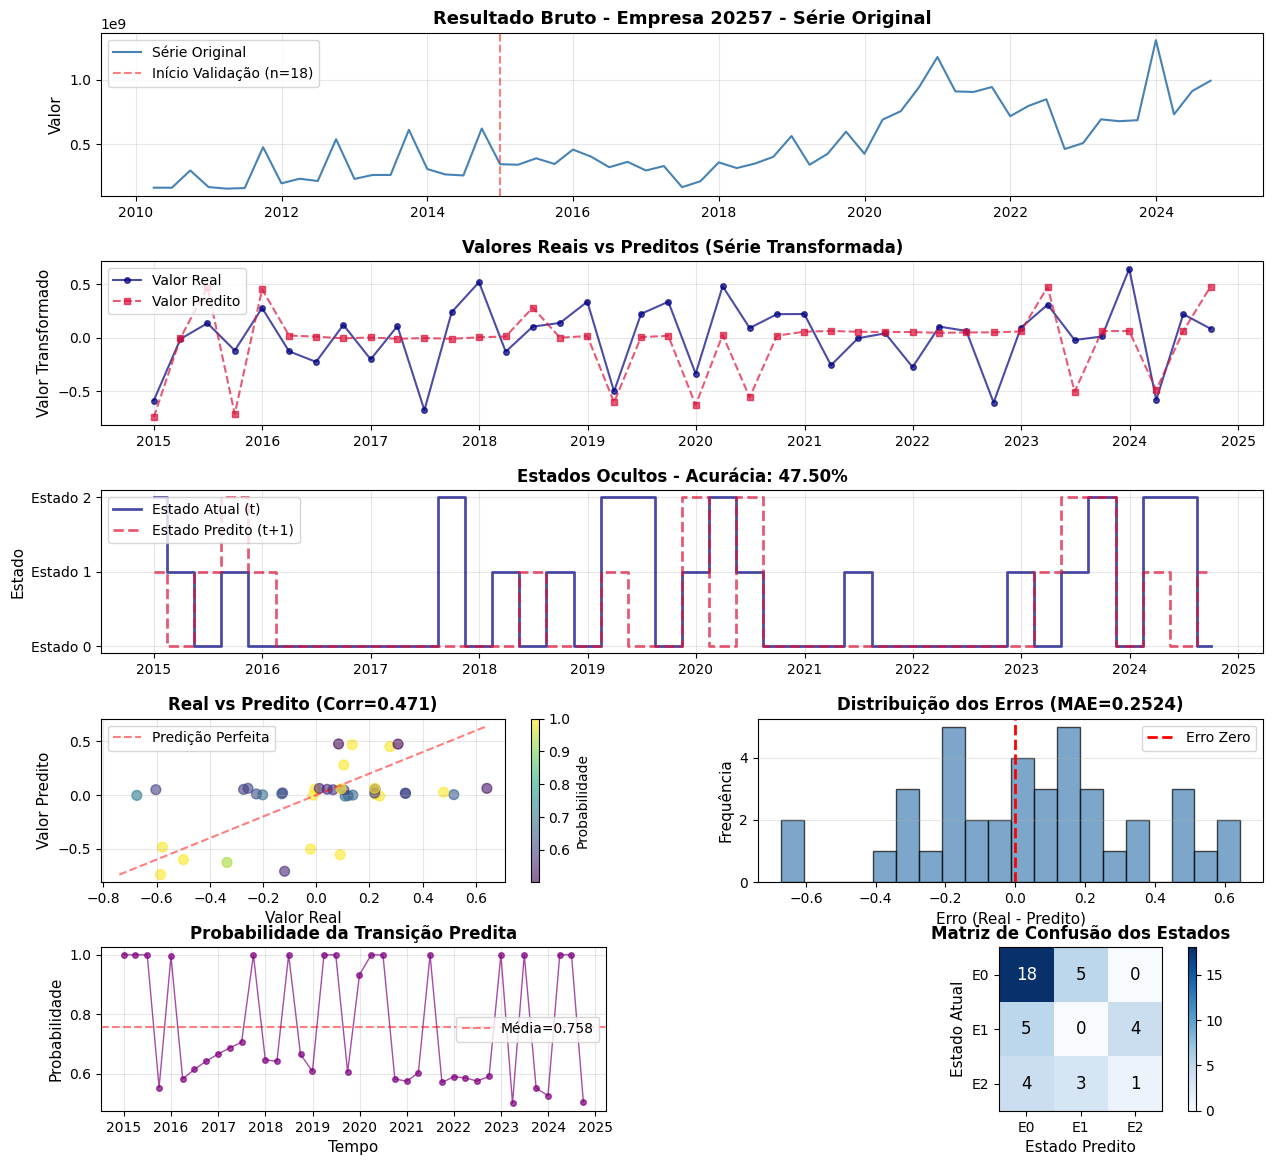

In [54]:

plotar_validacao_gaussianhmm(resultado_grid_val['melhor_rmse'])

In [42]:
resultado_grid_val.keys()

dict_keys(['nome', 'df_resultados', 'todos_resultados', 'melhor_acuracia', 'melhor_rmse', 'melhor_correlacao'])

In [51]:
resultado_grid_val['df_resultados']

n_estados  random_state  acuracia_estados      rmse       mae  correlacao
0           2             1          1.000000  0.284103  0.201507   -0.142244
1           2            42          0.975000  0.276765  0.193659    0.082861
2           2            99          0.975000  0.279737  0.196704    0.001122
3           2           150          0.975000  0.285224  0.201578   -0.144514
4           2           200          0.850000  0.280826  0.199517    0.027060
5           3             1          0.575000  0.343847  0.248045   -0.103268
6           3            42          0.450000  0.291833  0.217693    0.162542
7           3            99          0.575000  0.334244  0.237871    0.019980
8           3           150          0.600000  0.341893  0.241460    0.110793
9           3           200          0.550000  0.355540  0.260139   -0.169715
10          4             1          0.435897  0.343975  0.243957    0.001467
11          4            42          0.589744  0.326205  0.237227    0.131667
12          4            99          0.179487  0.320326  0.230831    0.189285
13          4           150          0.564103  0.344038  0.228476    0.047657
14          4           200          0.650000  0.292701  0.199799    0.183580
15          5             1          0.593750  0.312903  0.232031   -0.234457
16          5            42          0.081081  0.292332  0.210436    0.082797
17          5            99          0.739130  0.306549  0.200328    0.230261
18          5           150          0.375000  0.307823  0.214772   -0.054531
19          5           200          0.555556  0.301090  0.210872    0.129922

VALIDAÇÃO ONE-STEP-AHEAD PARA RESULTADO BRUTO

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM
Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000
Previsão 20/40: Estado_atual=2, Estado_pred=2, Prob=0.567
Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.593
Previsão 40/40: Estado_atual=2, Estado_pred=1, Prob=0.574

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.1750
RMSE: 0.3822
MAE: 0.3195
Correlação: 0.1560


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


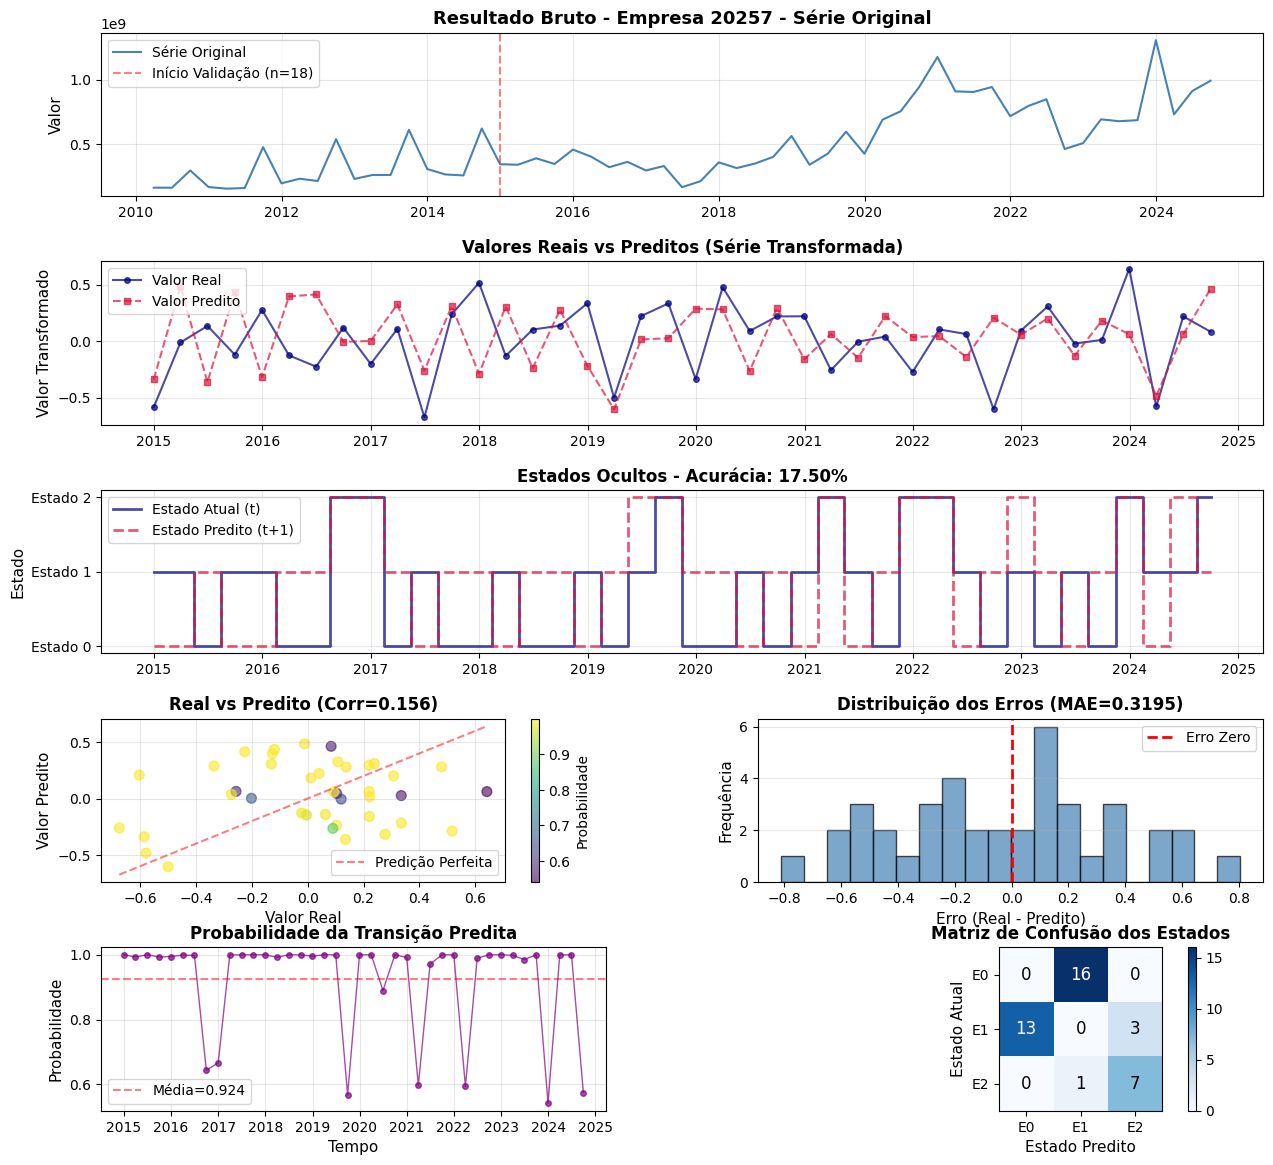


=== PRIMEIRAS 10 PREVISÕES ===


estado_atual  estado_predito  valor_real  valor_predito  \
2014-12-31             1               0   -0.585399      -0.338207   
2015-03-31             1               0   -0.011359       0.485510   
2015-06-30             0               1    0.135404      -0.362927   
2015-09-30             1               0   -0.118868       0.435704   
2015-12-31             1               0    0.277277      -0.317533   
2016-03-31             0               1   -0.126340       0.397371   
2016-06-30             0               1   -0.225063       0.414767   
2016-09-30             2               2    0.120074      -0.005439   
2016-12-31             2               2   -0.201291       0.002405   
2017-03-31             0               1    0.108559       0.325599   

            probabilidade  
2014-12-31       0.999980  
2015-03-31       0.993702  
2015-06-30       1.000000  
2015-09-30       0.993569  
2015-12-31       0.994479  
2016-03-31       0.999322  
2016-06-30       0.997884  
2016-09-30       0.642857  
2016-12-31       0.666665  
2017-03-31       0.999999



EXECUTANDO GRID SEARCH COM VALIDAÇÃO

GRID SEARCH COM VALIDAÇÃO ONE-STEP-AHEAD - Resultado Bruto - Empresa 20257
Testando 4 configurações de estados
Com 5 pontos iniciais diferentes
Janela de treino: 18

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM
Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000
Previsão 20/40: Estado_atual=1, Estado_pred=0, Prob=0.931
Previsão 30/40: Estado_atual=1, Estado_pred=0, Prob=0.979
Previsão 40/40: Estado_atual=1, Estado_pred=0, Prob=0.802

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.0000
RMSE: 0.4373
MAE: 0.3813
Correlação: -0.0673

Estados=2, Seed=  1 → Acur=0.000, RMSE=0.4373, Corr=-0.067

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
T

Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=0, Prob=0.507

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5250
RMSE: 0.4143
MAE: 0.3238
Correlação: 0.2135

Estados=3, Seed=200 → Acur=0.525, RMSE=0.4143, Corr=0.213

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=2, Estado_pred=0, Prob=0.625
Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.568
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.589


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.518

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2000
RMSE: 0.5639
MAE: 0.4302
Correlação: -0.0326

Estados=4, Seed=  1 → Acur=0.200, RMSE=0.5639, Corr=-0.033

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.
Model is not converging.  Current: 10.648936323215395 is not greater than 10.651460691312215. Delta is -0.0025243680968198845


Previsão 10/40: Estado_atual=1, Estado_pred=3, Prob=0.788
Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.566
Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.815


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=2, Estado_pred=2, Prob=0.729

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6000
RMSE: 0.4192
MAE: 0.3032
Correlação: -0.0091

Estados=4, Seed= 42 → Acur=0.600, RMSE=0.4192, Corr=-0.009

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 24: array must not contain infs or NaNs
Previsão 10/40: Estado_atual=1, Estado_pred=3, Prob=0.625


Model is not converging.  Current: -0.2721261639588427 is not greater than -0.2550625110571792. Delta is -0.017063652901663506
Model is not converging.  Current: 0.1278821464330641 is not greater than 0.1306729081473143. Delta is -0.0027907617142502172


Previsão 20/40: Estado_atual=3, Estado_pred=2, Prob=0.554
Previsão 30/40: Estado_atual=3, Estado_pred=1, Prob=1.000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=1, Estado_pred=2, Prob=0.599

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.0513
RMSE: 0.4582
MAE: 0.3694
Correlação: 0.2700

Estados=4, Seed= 99 → Acur=0.051, RMSE=0.4582, Corr=0.270

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.
Model is not converging.  Current: 5.341961851301416 is not greater than 5.342370755015157. Delta is -0.00040890371374047163
Model is not converging.  Current: 5.700064379171851 is not greater than 5.700373186175032. Delta is -0.00030880700318114407


Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=0.687
Previsão 20/40: Estado_atual=0, Estado_pred=3, Prob=1.000
Previsão 30/40: Estado_atual=0, Estado_pred=3, Prob=1.000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=3, Estado_pred=3, Prob=0.529

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2750
RMSE: 0.4971
MAE: 0.3650
Correlação: 0.0775

Estados=4, Seed=150 → Acur=0.275, RMSE=0.4971, Corr=0.077

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 23 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 22 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=0.634
Previsão 20/40: Estado_atual=3, Estado_pred=3, Prob=0.591


Model is not converging.  Current: -1.9913477602030674 is not greater than -1.9898999738890282. Delta is -0.00144778631403919


Previsão 30/40: Estado_atual=3, Estado_pred=3, Prob=1.000


Model is not converging.  Current: -0.4670093896152547 is not greater than -0.46516993001153545. Delta is -0.001839459603719229
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=3, Estado_pred=3, Prob=0.776

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6500
RMSE: 0.4200
MAE: 0.3203
Correlação: 0.2754

Estados=4, Seed=200 → Acur=0.650, RMSE=0.4200, Corr=0.275

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 16.276431571874156 is not greater than 16.27860979664095. Delta is -0.002178224766794301
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate soluti

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.634


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.


Previsão 20/40: Estado_atual=0, Estado_pred=3, Prob=0.705
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.759


Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.728

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4250
RMSE: 0.4808
MAE: 0.3539
Correlação: -0.0048

Estados=5, Seed=  1 → Acur=0.425, RMSE=0.4808, Corr=-0.005

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
C:\Users\g

Erro na iteração 27: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.


Previsão 20/40: Estado_atual=4, Estado_pred=0, Prob=1.000
Previsão 30/40: Estado_atual=1, Estado_pred=4, Prob=0.737


Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=4, Estado_pred=0, Prob=0.872

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.0000
RMSE: 0.5213
MAE: 0.3842
Correlação: 0.0029

Estados=5, Seed= 42 → Acur=0.000, RMSE=0.5213, Corr=0.003

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.


Erro na iteração 22: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.


Erro na iteração 24: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.


Erro na iteração 25: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 28 data points will result in a degenerate solution.


Erro na iteração 27: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.


Erro na iteração 28: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Model is not converging.  Current: -11.331759295230881 is not greater than -11.331189521177512. Delta is -0.0005697740533694429
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.


Erro na iteração 29: transmat_ rows must sum to 1 (got row sums of [1. 1. 0. 1. 1.])


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.


Erro na iteração 30: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.


Erro na iteração 31: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.


Erro na iteração 32: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 36: array must not contain infs or NaNs
Previsão 20/40: Estado_atual=3, Estado_pred=3, Prob=1.000


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 39: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 47: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 48: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 49: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 50: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 51: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 52: array must not contain infs or NaNs
Erro na iteração 53: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.


Erro na iteração 57: array must not contain infs or NaNs

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 21
Acurácia dos Estados: 0.5714
RMSE: 0.4028
MAE: 0.3508
Correlação: 0.0800

Estados=5, Seed= 99 → Acur=0.571, RMSE=0.4028, Corr=0.080

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 25 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 28 data points will result in a degenerate solution.
Fitting a 

Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=0.683


Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.


Previsão 20/40: Estado_atual=3, Estado_pred=3, Prob=0.565
Previsão 30/40: Estado_atual=0, Estado_pred=3, Prob=0.665


Fitting a model with 34 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=3, Prob=0.686

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.3500
RMSE: 0.3977
MAE: 0.3080
Correlação: 0.2988

Estados=5, Seed=150 → Acur=0.350, RMSE=0.3977, Corr=0.299

ONE-STEP-AHEAD GAUSSIANHMM - Resultado Bruto - Empresa 20257
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 0.32317071932517716 is not greater than 0.3231708776407094. Delta is -1.5831553223932815e-07
Fitting a model with 34 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 21 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 22 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 23 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 24 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide


Erro na iteração 24: array must not contain infs or NaNs


Fitting a model with 34 free scalar parameters with only 27 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 28 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.687


Fitting a model with 34 free scalar parameters with only 29 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 30 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 31 data points will result in a degenerate solution.


Erro na iteração 30: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Fitting a model with 34 free scalar parameters with only 32 data points will result in a degenerate solution.
Fitting a model with 34 free scalar parameters with only 33 data points will result in a degenerate solution.


Erro na iteração 31: array must not contain infs or NaNs
Previsão 20/40: Estado_atual=3, Estado_pred=3, Prob=0.566


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:386: RuntimeWarning: overflow encountered in divide
  self._covars_ = ((covars_prior + c_n) /


Erro na iteração 40: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 43: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 45: array must not contain infs or NaNs
Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.607


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 48: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 49: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 50: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 51: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 52: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 53: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Erro na iteração 54: array must not contain infs or NaNs
Previsão 40/40: Estado_atual=3, Estado_pred=3, Prob=0.540

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 27
Acurácia dos Estados: 0.3704
RMSE: 0.4148
MAE: 0.3058
Correlação: 0.2756

Estados=5, Seed=200 → Acur=0.370, RMSE=0.4148, Corr=0.276

RESUMO DOS RESULTADOS

✓ MELHOR MODELO POR ACURÁCIA DE ESTADOS:
  Estados: 3
  Acurácia: 0.9000
  RMSE: 0.3367

✓ MELHOR MODELO POR RMSE:
  Estados: 3
  RMSE: 0.3152
  Acurácia: 0.4750

✓ MELHOR MODELO POR CORRELAÇÃO:
  Estados: 3
  Correlação: 0.4710
  RMSE: 0.3152

=== TOP 10 MODELOS POR ACURÁCIA ===


n_estados  random_state  acuracia_estados      rmse       mae  correlacao
8           3           150          0.900000  0.336698  0.273689   -0.011206
14          4           200          0.650000  0.420021  0.320267    0.275378
2           2            99          0.600000  0.362116  0.288440   -0.047955
11          4            42          0.600000  0.419220  0.303157   -0.009146
17          5            99          0.571429  0.402795  0.350803    0.079958
9           3           200          0.525000  0.414259  0.323835    0.213471
5           3             1          0.475000  0.315193  0.252356    0.470994
15          5             1          0.425000  0.480805  0.353875   -0.004787
7           3            99          0.425000  0.354894  0.286517    0.316699
19          5           200          0.370370  0.414793  0.305779    0.275579



PLOTANDO MELHOR MODELO POR ACURÁCIA


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


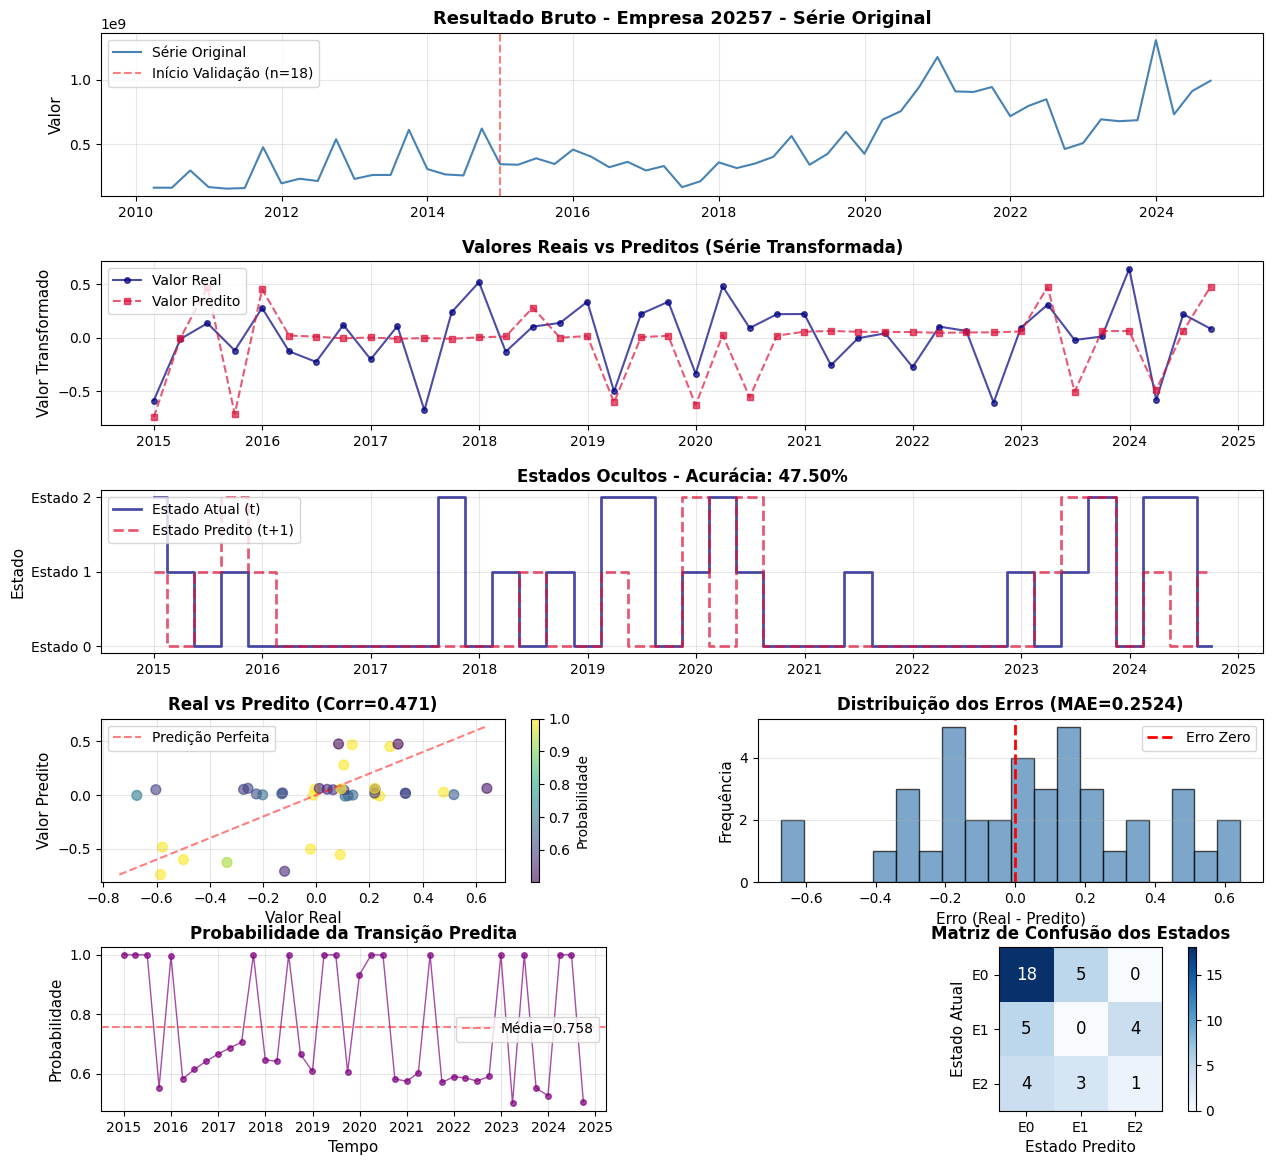

In [53]:
empresa_analise = '20257'

print("VALIDAÇÃO ONE-STEP-AHEAD PARA RESULTADO BRUTO")
resultado_validacao = gaussianhmm_one_step_ahead(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    n_estados=3,
    janela_treino=18,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100,
    random_state=42
)

# Plota resultados
plotar_validacao_gaussianhmm(resultado_validacao)

# Exibe DataFrame de resultados
print("\n=== PRIMEIRAS 10 PREVISÕES ===")
display(resultado_validacao['df_resultados'].head(10))

# Grid search com validação
print("\n\nEXECUTANDO GRID SEARCH COM VALIDAÇÃO")
resultado_grid_val = grid_search_gaussianhmm_validacao(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    estados_range=(2, 6),
    janela_treino=18,
    n_iter=100,
    random_states=[1, 42, 99, 150, 200],  # 5 seeds para ser mais rápido
    aplicar_log=True,
    diferenciacao=1
)

# Exibe tabela resumo
print("\n=== TOP 10 MODELOS POR ACURÁCIA ===")
display(resultado_grid_val['df_resultados'].sort_values('acuracia_estados', ascending=False).head(10))

# Plota melhor modelo
print("\n\nPLOTANDO MELHOR MODELO POR ACURÁCIA")
plotar_validacao_gaussianhmm(resultado_grid_val['melhor_rmse'])

C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 21 free scalar parameters with only 18 data points will result in a degenerate solution.


TESTE ÚNICO - GMMHMM

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 18.182580682268394 is not greater than 29.943812550133778. Delta is -11.761231867865384
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 17.063861653378318 is not greater than 17.522746365046984. Delta is -0.4588847116686665
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.865209967806695 is not greater than 40.155936377200725. Delta is -24.29072640939403
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.03233883895487 is not greater than 47.476024298091104. Delta is -28.443685459136233
Covariance of state #2, mixture #1 has a null eigenvalue.


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 22.477904462527423 is not greater than 22.89276483323575. Delta is -0.4148603707083254
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.69962658943944 is not greater than 29.98803128332297. Delta is -3.288404693883532
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.04161950909073 is not greater than 31.759594269752625. Delta is -3.717974760661896
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.54442059492148 is not greater than 41.350276447863884. Delta is -11.805855852942404
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.665225390577564 is not greater than 48.24641261113696. Delta is -18.581187220559396
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 30.42800173451278 is not greater than 30.986910289255675. Delta is -

Previsão 20/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 15.158275790998124 is not greater than 27.355017873437724. Delta is -12.1967420824396
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.213282254486284 is not greater than 20.94088651948012. Delta is -1.7276042649938361
Covariance of state #2, mixture #0 has a null eigenvalue.


Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=1.000


Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.


Previsão 40/40: Estado_atual=0, Estado_pred=1, Prob=0.861

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2250
RMSE: 0.2810
MAE: 0.2146
Correlação: 0.1517


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


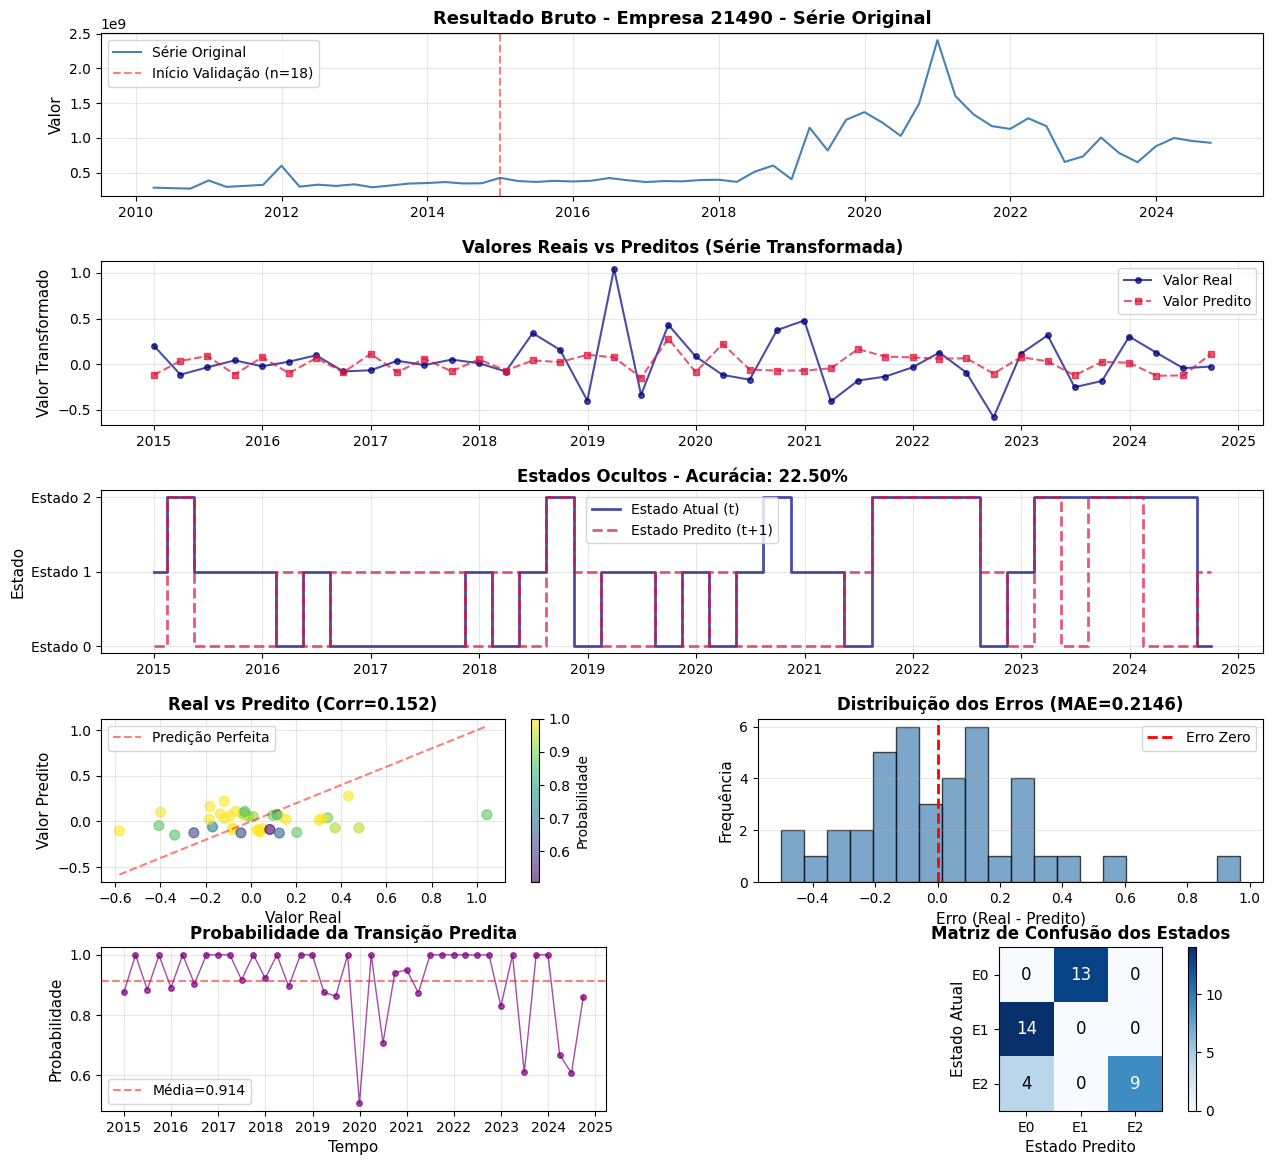



GRID SEARCH - GMMHMM

GRID SEARCH GMMHMM COM VALIDAÇÃO - Resultado Bruto - Empresa 21490
Estados: [2, 3, 4]
Componentes Gaussianas: [2, 3]
Seeds: [1, 42, 99, 150, 200]
Janela de treino: 18
Total de combinações: 30

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Model is not converging.  Current: 17.996016854274398 is not greater than 30.15037350601472. Delta is -12.154356651740322
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.786729023581362 is not greater than 21.309699747503117. Delta is -1.5229707239217554
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.513646139438322 is not greater than 32.21936003041078. Delta is -11.705713890972461
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.37274

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.665


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 24.189450341991577 is not greater than 24.685640215970352. Delta is -0.4961898739787749
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.90956379055334 is not greater than 32.13542948449711. Delta is -6.225865693943771
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 26.083452785108356 is not greater than 35.27421764244955. Delta is -9.190764857341193
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 24.55682806528433 is not greater than 25.34557222946308. Delta is -0.7887441641787518
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.783210330916948 is not greater than 40.77615367778659. Delta is -16.99294334686964
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.87613757

Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.787


Model is not converging.  Current: 17.02403293946184 is not greater than 32.32696682315484. Delta is -15.302933883693001
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.821435387748927 is not greater than 19.768400492524265. Delta is -1.9469651047753374
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.9167500046071 is not greater than 21.138091267381792. Delta is -4.221341262774693
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.989651686747695 is not greater than 27.85849019955522. Delta is -11.868838512807525
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.133799777438709 is not greater than 27.971671943714185. Delta is -16.837872166275474
Covariance of state #0, mixture #1 has a nu

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.897


Model is not converging.  Current: 12.938182788646976 is not greater than 18.80498597414426. Delta is -5.866803185497282
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 14.705980335980575 is not greater than 14.912581945556528. Delta is -0.2066016095759533
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.756762930223946 is not greater than 11.90803016261419. Delta is -1.1512672323902446
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 9.906885377029637 is not greater than 11.304807643453703. Delta is -1.3979222664240663
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 9.37235877729683 is not greater than 14.00971231389898. Delta is -4.63735353660215
Covariance of state #1, mixture #0 has a null 

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.672

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6250
RMSE: 0.2952
MAE: 0.2073
Correlação: -0.0892

Estados=2, Mix=2, Seed=  1 → Acur=0.625, RMSE=0.2952, MAE=0.2073, Corr=-0.089

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 14.174213123493239 is not greater than 28.3601562879752. Delta is -14.185943164481962
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.7618661186585 is not greater than 38.44317961034819. Delta is -24.68131349168969
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.433319111712343 is not greater than 20.005567462043814. Delta is -3.5722483503314706
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.02441072533628 is not greater than 23.060727761470233. Delta is -4.036317036133951
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.80156524914069 is not greater than 26.735751771152405. Delta is -6.934186522011714
Covariance of state #1, mixture #1 has a null e

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.840


Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.440151137963554 is not greater than 35.86452448741098. Delta is -12.424373349447428
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.692253984885088 is not greater than 39.89632061802827. Delta is -20.20406663314318
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.27804291718529 is not greater than 29.708251013175673. Delta is -11.430208095990384
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.077080665958235 is not greater than 17.181550520795124. Delta is -0.1044698548368892


Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.862


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.138084012850218 is not greater than 19.38826254999858. Delta is -1.2501785371483614
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.99538265273661 is not greater than 19.967852851830134. Delta is -1.9724701990935252
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.13364032851328 is not greater than 19.050130904136296. Delta is -1.9164905756230155
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.879468022915715 is not greater than 20.13122050973365. Delta is -6.251752486817937
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eig

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.861


Model is not converging.  Current: 12.738448536097426 is not greater than 16.487913862165055. Delta is -3.7494653260676287
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 8.747974591489884 is not greater than 9.256296232812836. Delta is -0.5083216413229525
Covariance of state #1, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags=

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.842

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6500
RMSE: 0.2733
MAE: 0.1975
Correlação: 0.2008

Estados=2, Mix=2, Seed= 42 → Acur=0.650, RMSE=0.2733, MAE=0.1975, Corr=0.201

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 16.40731893010028 is not greater than 17.82966040991632. Delta is -1.422341479816037
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.289361458127177 is not greater than 24.151953271381533. Delta is -10.862591813254356
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 15.879355640359124 is not greater than 36.61221593381088. Delta is -20.732860293451758
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.815147600746997 is not greater than 23.474758313649787. Delta is -7.65961071290279
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.230948150096935 is not greater than 24.78035137807031. Delta is -2.549403227973375
Covariance of state #0, mixture #1 has a null

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.902


Model is not converging.  Current: 23.351568865710043 is not greater than 28.030948751583303. Delta is -4.67937988587326
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 24.778417423427122 is not greater than 31.180027564195502. Delta is -6.40161014076838
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 26.8427581859771 is not greater than 53.96124687109993. Delta is -27.11848868512283
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.131911832776574 is not greater than 54.777515881457056. Delta is -28.645604048680482
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.803764740256874 is not greater than 49.43983371836675. Delta is -23.636068978109876
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.43550324

Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.784


Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 20.169028418105643 is not greater than 33.59828409592744. Delta is -13.429255677821796
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 18.74480542526459 is not greater than 26.495685418990977. Delta is -7.750879993726386
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.43382384461202 is not greater than 23.905889704399524. Delta is -6.472065859787502
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.


Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.900


Model is not converging.  Current: 10.436506175066063 is not greater than 18.140183607185865. Delta is -7.703677432119802
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.555343539527207 is not greater than 18.645719817251702. Delta is -7.090376277724495
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.034375568081156 is not greater than 17.7559407248604. Delta is -1.7215651567792456
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.881556841612918 is not greater than 28.850652666569708. Delta is -12.96909582495679
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 6.106218014932346 is not greater than 12.29168929329424. Delta is -6.185471278361894
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.928

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.9250
RMSE: 0.2783
MAE: 0.1961
Correlação: 0.0512

Estados=2, Mix=2, Seed= 99 → Acur=0.925, RMSE=0.2783, MAE=0.1961, Corr=0.051

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 17.26491051987784 is not greater than 36.29484161572. Delta is -19.029931095842162
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.717044091022277 is not greater than 22.21415032052464. Delta is -1.4971062295023643
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 21.306652242871174 is not greater than 39.97566257070358. Delta is -18.669010327832403
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 22.2555893198414 is not greater than 24.333545801560973. Delta is -2.077956481719575
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 23.599175891272786 is not greater than 48.62652449891386. Delta is -25.027348607641073


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=0.728


Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 24.683201860895945 is not greater than 25.293034406719073. Delta is -0.609832545823128
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 26.12808255633251 is not greater than 36.56604504501629. Delta is -10.437962488683777
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 25.689771783470526 is not greater than 26.99994024854953. Delta is -1.3101684650790055
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.


Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.801


Model is not converging.  Current: 16.913514125586556 is not greater than 44.824853761441034. Delta is -27.91133963585448
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.577600311418877 is not greater than 19.515208416862787. Delta is -1.9376081054439105
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.63725770599507 is not greater than 22.98142993541902. Delta is -7.344172229423949
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.343904270327673 is not greater than 30.049661891431096. Delta is -12.705757621103423
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.424424954864264 is not greater than 12.534387523304948. Delta is -0.1099625684406842
Covariance of state #1, mixture #1 has a 

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.842


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.387773692634271 is not greater than 17.484397220824974. Delta is -4.096623528190703
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.0580952006218 is not greater than 15.683733675429695. Delta is -3.6256384748078947
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.723606150042041 is not greater than 22.457998946075126. Delta is -11.734392796033084
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.72090600099658 is not greater than 10.816067823136777. Delta is -1.0951618221401969
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.234350984108662 is not greater than 16.907618635051325. Delta is -7.6732676509426625
Covariance of state #1, mixture #1 has a nu

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.822

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4250
RMSE: 0.2911
MAE: 0.2261
Correlação: 0.0399

Estados=2, Mix=2, Seed=150 → Acur=0.425, RMSE=0.2911, MAE=0.2261, Corr=0.040

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 23.347937836387832 is not greater than 24.947206902683796. Delta is -1.5992690662959639
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 26.3968100934869 is not greater than 29.333466095445893. Delta is -2.936656001958994
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 27.954196737751516 is not greater than 38.19853116619797. Delta is -10.24433442844645
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 28.535635887016614 is not greater than 46.164854409921666. Delta is -17.629218522905052
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 26.165010208351063 is not greater than 28.692460980430404. Delta is -2.527450772079341
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.915990616950527 is not greater than 44.49143798871203. Delta is -18.575447371761502
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.681320860609734 is not greater than 40.62197656908454. Delta is 

Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.807


Model is not converging.  Current: 17.306376945477805 is not greater than 17.452105815958515. Delta is -0.14572887048070982
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.315173206955347 is not greater than 23.272975300121285. Delta is -4.957802093165938
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.997671275883057 is not greater than 21.507373769683316. Delta is -3.5097024938002583
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.159800406459183 is not greater than 20.343606927297667. Delta is -3.183806520838484
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.987471006631134 is not greater than 21.18347764571885. Delta is -5.196006639087715
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.81689195191259 is not greater than 21.503238555465686. Delta

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.699


Model is not converging.  Current: 12.706981836458516 is not greater than 13.352762043617457. Delta is -0.6457802071589409
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.367958875178257 is not greater than 29.201490812497386. Delta is -15.83353193731913
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.813019221209709 is not greater than 13.587034113555697. Delta is -2.7740148923459884
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.266228985513145 is not greater than 14.528530028171359. Delta is -5.262301042658214
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 8.523773319350276 is not greater than 11.214636820717976. Delta is -2.

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.690

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4500
RMSE: 0.2841
MAE: 0.2186
Correlação: 0.1148

Estados=2, Mix=2, Seed=200 → Acur=0.450, RMSE=0.2841, MAE=0.2186, Corr=0.115

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 19.04990587995413 is not greater than 36.00905956233637. Delta is -16.959153682382237
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 16.752978501135708 is not greater than 20.679220635169205. Delta is -3.9262421340334974
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.03656679177679 is not greater than 37.55256668806374. Delta is -18.515999896286953
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.456075520413705 is not greater than 22.647996568918945. Delta is -1.1919210485052396
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.040261115363542 is not greater than 41.681296132289766. Delta is -13.641035016926224
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 33.957

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.571


Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 23.514024980233586 is not greater than 25.428149818629922. Delta is -1.9141248383963365
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.8089792925487 is not greater than 32.725328337090424. Delta is -6.916349044541725
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 32.759731215115046 is not greater than 35.174653637799956. Delta is -2.41492242268491
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 32.146660764171976 is not greater than 34.56433713496023. Delta is -2.417676370788257
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 25.916436618819695 is not greater than 27.396735284846716. Delta is -1.4802986660270214
Covariance of state #0, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 24.557378

Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.761


Model is not converging.  Current: 16.932018773013187 is not greater than 17.96409240243134. Delta is -1.0320736294181536
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.94784524479989 is not greater than 25.11097462059159. Delta is -7.163129375791701
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.775191623578785 is not greater than 34.714090647748215. Delta is -16.93889902416943
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.89476545044638 is not greater than 44.770939347209136. Delta is -27.876173896762758
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.919716453442302 is not greater than 17.010061146131473. Delta is -1.0903446926891718
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 24.176615037331363 is not greater than 37.07833567478196. Delta is

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.898


Model is not converging.  Current: 13.642189073128842 is not greater than 19.35962324452836. Delta is -5.717434171399519
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 14.341311721715465 is not greater than 41.06780997688608. Delta is -26.72649825517062
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 14.789086070439483 is not greater than 16.676407640349098. Delta is -1.8873215699096146
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.064726066693627 is not greater than 36.804800799620125. Delta is -25.740074732926498
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null ei

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.644

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5000
RMSE: 0.2898
MAE: 0.2113
Correlação: 0.0147

Estados=2, Mix=3, Seed=  1 → Acur=0.500, RMSE=0.2898, MAE=0.2113, Corr=0.015

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 14.7550752009559 is not greater than 19.65037091554521. Delta is -4.8952957145893095
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 16.386100133289307 is not greater than 22.492977875115713. Delta is -6.1068777418264055
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.00580770507759 is not greater than 27.526629425039747. Delta is -1.5208217199621572
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.31770932886057 is not greater than 37.465707648772494. Delta is -15.147998319911924
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 20.21596128073

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.756


Model is not converging.  Current: 25.682945190216778 is not greater than 39.20205450648998. Delta is -13.519109316273202
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 27.383980670555538 is not greater than 31.632032446888715. Delta is -4.2480517763331775
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 35.62112368957422 is not greater than 39.27561102275587. Delta is -3.654487333181649
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 36.106645654176894 is not greater than 57.82113742776452. Delta is -21.714491773587625
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 34.59600583662

Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.850


Model is not converging.  Current: 17.07207332548936 is not greater than 18.237358980089923. Delta is -1.165285654600563
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.20716024933819 is not greater than 21.073670793999568. Delta is -2.8665105446613772
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.069856927316717 is not greater than 22.314074373625683. Delta is -4.244217446308966
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.087834920909856 is not greater than 22.03770691111354. Delta is -4.9498719902036825
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.525121078005023 is not greater than 16.882063554410873. Delta is -1.35694247640585
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.777194

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.847


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.330923344413428 is not greater than 42.17093169078805. Delta is -25.840008346374624
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.371609024865744 is not greater than 24.875003706575406. Delta is -14.503394681709661
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 8.991860109354295 is not greater than 24.536167784168207. Delta is -15.544307674813911
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 6.842610883496282 is not greater than 13.046523774428712. Delta is -6.20391289093243
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 6.604293560870198 is not greater than 14.075136669963761. Delta is -7.470843109093564
Covariance of state #1, mixture #1 has a nul

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.831

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.6500
RMSE: 0.2852
MAE: 0.2020
Correlação: 0.0069

Estados=2, Mix=3, Seed= 42 → Acur=0.650, RMSE=0.2852, MAE=0.2020, Corr=0.007

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 14.039146855383631 is not greater than 16.35999370768001. Delta is -2.3208468522963805
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.231614399888777 is not greater than 52.83477489811876. Delta is -23.603160498229983
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.717585308028056 is not greater than 25.287884974688968. Delta is -7.570299666660912
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 17.28755252381151 is not greater than 26.19460004468565. Delta is -8.90704752087414
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.587174428360726 is not greater than 35.28829069800808. Delta is -15.701116269647358
Covariance of state #1, mixture #1 has a null

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.904


Model is not converging.  Current: 29.68567105688377 is not greater than 44.57334616731873. Delta is -14.887675110434962
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.505604667798895 is not greater than 43.81276066554876. Delta is -16.307155997749863
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 35.52141674346624 is not greater than 49.461648912473606. Delta is -13.940232169007366
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 29.590436314854493 is not greater than 35.204214387317066. Delta is -5.613778072462573
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.075620887096168 is not greater than 36.94717168603518. Delta is -10.871550798939015
Covariance of state #0, mixture #2 has a nu

Previsão 20/40: Estado_atual=1, Estado_pred=1, Prob=0.778


Model is not converging.  Current: 20.206022848350585 is not greater than 25.138637253395036. Delta is -4.9326144050444505
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 20.354186477808717 is not greater than 48.147728157115665. Delta is -27.793541679306948
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.395351255794324 is not greater than 20.103471118339407. Delta is -0.7081198625450824
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 18.69564756301748 is not greater than 45.37027498660713. Delta is -26.674627423589648
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.305044736697003 is not greater than 33.23543478609303. Delta is -1

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.846


Model is not converging.  Current: 10.080855413166589 is not greater than 12.22002852481306. Delta is -2.139173111646471
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.120124812135225 is not greater than 13.645052687559545. Delta is -2.5249278754243196
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.753205499787436 is not greater than 32.4608968509508. Delta is -16.70769135116337
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.746417069393752 is not greater than 17.431244636264807. Delta is -1.6848275668710553
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.3634487480686 is not greater than 30.726791076988206. Delta is -9.363342328919607
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 5.62534256

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.926

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.9250
RMSE: 0.2808
MAE: 0.1961
Correlação: 0.0050

Estados=2, Mix=3, Seed= 99 → Acur=0.925, RMSE=0.2808, MAE=0.1961, Corr=0.005

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 19.466516328907197 is not greater than 23.719632289167077. Delta is -4.25311596025988
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 18.161578502369938 is not greater than 39.076586629678246. Delta is -20.915008127308308
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.04952916030108 is not greater than 31.8636080392213. Delta is -14.81407887892022
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 26.27078903889756 is not greater than 31.408048883416104. Delta is -5.1372598445185425
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 25.0582774597318

Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.434655157249388 is not greater than 29.802289332598335. Delta is -1.3676341753489467
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 30.40110872279195 is not greater than 37.21547605528548. Delta is -6.8143673324935286
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 32.160819898915676 is not greater than 34.49699252248499. Delta is -2.336172623569311
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 31.04186376743335 is not greater than 36.33291257067043. Delta is -5.291048803237079
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.382769527515 is not greater than 30.689141451084904. Delta is -5.306371923569905
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null ei

Previsão 20/40: Estado_atual=0, Estado_pred=0, Prob=0.631


Model is not converging.  Current: 16.509925908029096 is not greater than 16.95413882132617. Delta is -0.444212913297072
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.304791031768765 is not greater than 19.82168409123896. Delta is -1.5168930594701955
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.28095008512554 is not greater than 22.565782338363054. Delta is -5.284832253237514
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.313383993787465 is not greater than 19.102414529221118. Delta is -3.7890305354336533
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.049485687900468 is not greater than 46.982884265080905. Delta is -26.933398577180437
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.3521

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.847


Model is not converging.  Current: 13.784736483788029 is not greater than 20.697927409650784. Delta is -6.9131909258627555
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 14.242886508781027 is not greater than 17.141589706714083. Delta is -2.898703197933056
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.195705316947256 is not greater than 19.979577841735107. Delta is -7.783872524787851
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.704856992156813 is not greater than 15.429887383639743. Delta is -4.72503039148293
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.685319620481703 is not greater than 12.63956731753797. Delta is -2.9542476970562674
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.419955

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.750

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.4000
RMSE: 0.2986
MAE: 0.2262
Correlação: -0.0655

Estados=2, Mix=3, Seed=150 → Acur=0.400, RMSE=0.2986, MAE=0.2262, Corr=-0.065

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 2
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 19.401792061425386 is not greater than 23.07043031218221. Delta is -3.6686382507568247
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.94611449164278 is not greater than 18.000667249986794. Delta is -0.05455275834401263
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 24.660149314743602 is not greater than 29.795920620847753. Delta is -5.13577130610415
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.


Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 28.56343194664504 is not greater than 33.957355693698936. Delta is -5.393923747053897
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 26.81999929505428 is not greater than 32.75988530997116. Delta is -5.93988601491688
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 33.147222577444204 is not greater than 51.74199250966206. Delta is -18.594769932217858
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 40.81274574632175 is not greater than 69.3712419639642. Delta is -28.558496217642443
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 36.7533164312497 is not greater than 65.43036692537963. Delta is -28.67705049412993
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigen

Previsão 20/40: Estado_atual=0, Estado_pred=1, Prob=0.668


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.198441458842105 is not greater than 24.787513759585092. Delta is -6.589072300742988
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.874859994688215 is not greater than 24.351619546450387. Delta is -6.476759551762171
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.327570560756982 is not greater than 16.09418343360274. Delta is -0.7666128728457586
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.28313160030724 is not greater than 27.402327385258317. Delta is -1.1191957849510779
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.68618329821263 is not greater than 36.39392100545343. Delta is -23.7

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.868


Model is not converging.  Current: 12.410592396974724 is not greater than 14.096613155247189. Delta is -1.6860207582724644
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.058434284617421 is not greater than 32.53362383054476. Delta is -19.475189545927343
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.790653906868606 is not greater than 23.200510746727947. Delta is -0.40985683985934074
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.475592490161096 is not greater than 14.851291118787401. Delta is -3.3756986286263047
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.875936809846207 is not greater than 38.73282389919207. Delta is -27.85688708934586
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 9.83

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.608

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.3000
RMSE: 0.2853
MAE: 0.2144
Correlação: 0.1276

Estados=2, Mix=3, Seed=200 → Acur=0.300, RMSE=0.2853, MAE=0.2144, Corr=0.128

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 21.94138454085075 is not greater than 35.335503989180154. Delta is -13.394119448329405
Covariance of state #2, mixture #0 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 26.1851958433768 is not greater than 36.76320852393613. Delta is -10.578012680559329
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.324175104604237 is not greater than 26.245573174978233. Delta is -7.921398070373996
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.009506245214066 is not greater than 40.50496788072077. Delta is -21.495461635506704
Model is not converging.  Current: 22.459065772143596 is not g

Previsão 10/40: Estado_atual=0, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 27.795395324445646 is not greater than 29.467026939921837. Delta is -1.6716316154761905
Model is not converging.  Current: 27.389455288987566 is not greater than 37.980822184600335. Delta is -10.591366895612769
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 33.146642275020135 is not greater than 35.4915992579713. Delta is -2.3449569829511674
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 35.095775262494534 is not greater than 45.387421489650286. Delta is -10.291646227155752
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 30.93241278031836 is not greater than 39.31976054437213. Delta is -8.387347764053771
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 31.061279272032277 is not greater than 46.21364244939334. Delta is -15.152363177361064
Covariance of state #2, mixture #0 h

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.745


Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.83468481440792 is not greater than 35.27868803791651. Delta is -9.444003223508588
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 25.593208732332183 is not greater than 51.53092621911863. Delta is -25.93771748678645
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.720863526322272 is not greater than 27.784826320193417. Delta is -5.063962793871145
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.386167202746105 is not greater than 38.37496515325673. Delta is -15.988797950510627
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.99862701949805 is not greater than 22.311139809736. Delta is -1.3125127902379532
Covariance of state #1, mixture #1 has a null ei

Previsão 30/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.98492449711136 is not greater than 22.657060137251726. Delta is -2.6721356401403646
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.45841973498956 is not greater than 22.344506787170296. Delta is -4.886087052180738
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 16.47548345646686 is not greater than 42.736305836359975. Delta is -26.260822379893114
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 16.054715314076848 is not greater than 28.725693890563534. Delta is -12.670978576486686
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 16.0183680880

Previsão 40/40: Estado_atual=1, Estado_pred=2, Prob=0.877

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2000
RMSE: 0.3273
MAE: 0.2418
Correlação: -0.0291

Estados=3, Mix=2, Seed=  1 → Acur=0.200, RMSE=0.3273, MAE=0.2418, Corr=-0.029

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 21.7527003168872 is not greater than 23.336603926773986. Delta is -1.5839036098867858
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 16.628356286272428 is not greater than 16.73983967531425. Delta is -0.11148338904182253
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 24.82186733293121 is not greater than 54.15820187899687. Delta is -29.33633454606566
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.722789862466808 is not greater than 23.424017127284813. Delta is -3.701227264818005
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.51330776229464 is not gr

Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 25.84625498816748 is not greater than 28.694917529851136. Delta is -2.8486625416836553
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.64967632302009 is not greater than 36.22851128070293. Delta is -8.578834957682844
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.30259105571493 is not greater than 32.28218099311331. Delta is -2.9795899373983765
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.67376077907639 is not greater than 43.058109501144735. Delta is -13.384348722068346
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.962122612329615 is not greater than 39.483175244075575. Delta is -10.52105263174596
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 30.42800173451278 is not greater than 30.986910289255675. Delta is -

Previsão 20/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 15.158275790998124 is not greater than 27.355017873437724. Delta is -12.1967420824396
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.213282254486284 is not greater than 20.94088651948012. Delta is -1.7276042649938361
Covariance of state #2, mixture #0 has a null eigenvalue.


Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=1.000


Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 21 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=0, Estado_pred=1, Prob=0.861

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2000
RMSE: 0.2768
MAE: 0.2105
Correlação: 0.1920

Estados=3, Mix=2, Seed= 42 → Acur=0.200, RMSE=0.2768, MAE=0.2105, Corr=0.192

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 32.40822125513211 is not greater than 51.280480160657376. Delta is -18.872258905525264
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 26.48361960268336 is not greater than 28.817503568435914. Delta is -2.3338839657525554
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 20.902728653993385 is not greater than 33.62080650560811. Delta is -12.718077851614723
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 21.207358728319477 is not greater than 25.38983163943325. Delta is -4.1824729111137735
Co

Previsão 10/40: Estado_atual=0, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 26.517646961067705 is not greater than 32.96660038005635. Delta is -6.448953418988644
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.81887602832482 is not greater than 41.561651281401495. Delta is -14.742775253076676
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 28.17186466498996 is not greater than 48.45577072556679. Delta is -20.283906060576832
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 41.72991664646294 is not greater than 48.55913530063662. Delta is -6.82921865417368
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 30.98779256068081 is not greater than 58.236638687849506. Delta is -27.248846127168697
Covariance of state #1, mixture #1 has a null e

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.810


Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.92863408288047 is not greater than 23.18949131580185. Delta is -3.260857232921378
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.5559071902009 is not greater than 22.595620910894308. Delta is -3.039713720693406
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.317935283326225 is not greater than 22.642008521728364. Delta is -3.324073238402139
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 18.514904051216362 is not greater than 21.223505307509402. Delta is -2.70860125629304
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.945458956584144 is not greater than 25.756926235231003. Delta is -8.811467278646859
Covariance of state #1, mixture #1 has a null e

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.608


Model is not converging.  Current: 22.079487725513346 is not greater than 25.007118787255205. Delta is -2.9276310617418595
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.938022274748228 is not greater than 26.33836131800399. Delta is -8.400339043255762
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.260293547706418 is not greater than 36.48151132476182. Delta is -18.2212177770554
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.875399256155415 is not greater than 20.415677175428485. Delta is -1.5402779192730698
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.743078080885574 is not greater than 19.1009901197841. Delta is -1.357912038898526
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.886239526975924 is not greater than 28.87897399121176. Delta is -

Previsão 40/40: Estado_atual=0, Estado_pred=2, Prob=0.796

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.3000
RMSE: 0.3246
MAE: 0.2474
Correlação: -0.0551

Estados=3, Mix=2, Seed= 99 → Acur=0.300, RMSE=0.3246, MAE=0.2474, Corr=-0.055

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 19.52454434465846 is not greater than 50.69717322159543. Delta is -31.17262887693697
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 16.46132894940622 is not greater than 30.8569445760572. Delta is -14.39561562665098
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 17.441273277236697 is not greater than 27.20683980079335. Delta is -9.765566523556654
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 24.313732947522475 is not greater tha

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 35.651951783914 is not greater than 43.354742163298155. Delta is -7.702790379384155
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 44.034510953265524 is not greater than 52.6585771786776. Delta is -8.624066225412072
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 32.91019438833807 is not greater than 35.50062737516848. Delta is -2.5904329868304075
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.203543958473936 is not greater than 39.86993482416263. Delta is -10.66639086568869
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.60974771734948 is not greater than 22.626087291516107. Delta is -1.0163395741666257
Covariance of state #1, mixture #1 has a null eig

Erro na iteração 36: array must not contain infs or NaNs


Model is not converging.  Current: 24.480444233169695 is not greater than 32.9801697380152. Delta is -8.499725504845504
Covariance of state #2, mixture #0 has a null eigenvalue.


Previsão 20/40: Estado_atual=1, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 20.080332215631348 is not greater than 23.40727398896887. Delta is -3.3269417733375235
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 34.37617547783779 is not greater than 62.82183489399423. Delta is -28.44565941615644
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 26.142163686148965 is not greater than 28.11316874226847. Delta is -1.9710050561195054
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 30.222404512173878 is not greater than 32.3952802864022. Delta is -2.17287577422832
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenva

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.508


Model is not converging.  Current: 17.619110395734065 is not greater than 26.565491839464897. Delta is -8.946381443730832
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 20.739370160079297 is not greater than 29.22778648485835. Delta is -8.488416324779053
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.984402932416817 is not greater than 33.036379071071686. Delta is -6.051976138654869
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is out

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.918

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.8462
RMSE: 0.2939
MAE: 0.1995
Correlação: 0.1997

Estados=3, Mix=2, Seed=150 → Acur=0.846, RMSE=0.2939, MAE=0.1995, Corr=0.200

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 27.672543872173073 is not greater than 49.518839372462. Delta is -21.846295500288925
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 20.64999296058794 is not greater than 46.2461558692553. Delta is -25.596162908667356
Covariance of state #2, mixture #0 has a null eigenvalue.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 21.940418204526747 is not greater than 28.83176642312282. Delta is -6.891348218596072
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.55675991609124 is not greater than 25.63270182870757. Delta is -2.0759419126163294
Covarian

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.815


Model is not converging.  Current: 36.35416866034481 is not greater than 40.84877858548654. Delta is -4.494609925141731
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 31.68190288040434 is not greater than 32.801283823728866. Delta is -1.1193809433245256
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 31.963856045718845 is not greater than 48.58852752650711. Delta is -16.624671480788262
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 34.827869669353014 is not greater than 43.43246266472148. Delta is -8.604592995368463
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 34.46439401663747 is not greater than 47.551286024840856. Delta is -13.086

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.730


Model is not converging.  Current: 19.4345507893146 is not greater than 24.805375101752837. Delta is -5.370824312438238
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.151253521260884 is not greater than 23.448499859117643. Delta is -2.297246337856759
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.590462840730577 is not greater than 30.188814609559927. Delta is -6.59835176882935
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.475427902748116 is not greater than 41.59503674548735. Delta is -22.119608842739233
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigen

Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.797


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.1205511430065 is not greater than 19.964587007495563. Delta is -1.8440358644890615
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.55523234148307 is not greater than 15.249133285750295. Delta is -1.6939009442672255
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.076689915713004 is not greater than 22.515113471285268. Delta is -3.438423555572264
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.889242904391145 is not greater than 32.90525434227933. Delta is -20.01601143788818
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.684532381143

Previsão 40/40: Estado_atual=1, Estado_pred=2, Prob=0.547

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5000
RMSE: 0.3407
MAE: 0.2427
Correlação: -0.1873

Estados=3, Mix=2, Seed=200 → Acur=0.500, RMSE=0.3407, MAE=0.2427, Corr=-0.187

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 21.2202559803063 is not greater than 42.48514076298914. Delta is -21.26488478268284
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 17.37189681154454 is not greater than 23.451341062211004. Delta is -6.079444250666462
Fitting a model with 28 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 17.78930045300263 is not greater than 37.753240742197875. Delta is -19.963940289195243
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 18.4331240309059 is not greater than 28.43645516609408. Delta is -10.00333113518818
Covariance of s

Erro na iteração 22: array must not contain infs or NaNs


Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 24 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 28 free scalar parameters with only 25 data points will result in a degenerate solution.


Erro na iteração 24: array must not contain infs or NaNs


Model is not converging.  Current: 26.348498259947352 is not greater than 156.2572729879679. Delta is -129.90877472802055
Fitting a model with 28 free scalar parameters with only 26 data points will result in a degenerate solution.
Model is not converging.  Current: 28.42924483103864 is not greater than 30.96248412699341. Delta is -2.5332392959547683
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 27 data points will result in a degenerate solution.
Model is not converging.  Current: 38.11432385711653 is not greater than 45.369879459414406. Delta is -7.255555602297875
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.


Previsão 10/40: Estado_atual=1, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 30.034056802758183 is not greater than 30.42322125106855. Delta is -0.38916444831036756
Model is not converging.  Current: 37.993018844277145 is not greater than 252.98571332236367. Delta is -214.99269447808652
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 36.313191843030594 is not greater than 43.950585417377695. Delta is -7.637393574347101
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 40.955291253770135 is not greater than 52.49985264585413. Delta is -11.544561392083999
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 32.776104090810406 is not greater than 35.24610964713978. Delta is -2.470005556329376
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 31.991294175448726 is not greater than 34.644282762194784. Delta

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 25.78746945985944 is not greater than 41.39460841621593. Delta is -15.60713895635649
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 34.55018111381727 is not greater than 53.76388020731124. Delta is -19.21369909349397
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.083176533545156 is not greater than 25.449651077861827. Delta is -2.36647454431667
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.932431142237736 is not greater than 23.654778333356266. Delta is -1.72234719111853
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.736343726188476 is not greater than 23.342304330262753. Delta is -0.605960

Previsão 30/40: Estado_atual=0, Estado_pred=1, Prob=0.942


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.493398345455354 is not greater than 28.898067218421545. Delta is -9.404668872966191
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.203027727044226 is not greater than 42.29558906343834. Delta is -25.092561336394116
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.461746128092187 is not greater than 20.020696932304965. Delta is -2.5589508042127775
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 15.835288762878905 is not greater than 16.555841147632936. Delta is -0.7205523847540309
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 15.886262922137458 is not greater than 34.89322111116163. Delta is -19.00695818902417
Covariance of state #1, mixture #0 has a 

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.788

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.1842
RMSE: 0.3283
MAE: 0.2429
Correlação: 0.0419

Estados=3, Mix=3, Seed=  1 → Acur=0.184, RMSE=0.3283, MAE=0.2429, Corr=0.042

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 22.00043397284156 is not greater than 22.949543750590855. Delta is -0.9491097777492961
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 24.44601842017701 is not greater than 25.428556282627593. Delta is -0.9825378624505845
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 18.44408963436497 is not greater than 35.22759762768946. Delta is -16.78350799332449
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 21.8857059644461 is not greater than 40

Previsão 10/40: Estado_atual=2, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 30.321371235785044 is not greater than 30.409322696221537. Delta is -0.08795146043649282
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 40.493338889992614 is not greater than 55.14781091966572. Delta is -14.654472029673109
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 34.15051582431109 is not greater than 34.46557054337631. Delta is -0.3150547190652162
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 31.503599322702392 is not greater than 59.91845474789948. Delta is -28.41485542519709
Covariance of state #2, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 41.91463679590756 is not greater than 44.84219532075029. Delta is -2.9275585248427305
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #0 has a nu

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=1.000


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.57922010985228 is not greater than 34.54234202364764. Delta is -11.963121913795362
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 41: array must not contain infs or NaNs


Model is not converging.  Current: 15.640504659664332 is not greater than 39.36286111228877. Delta is -23.72235645262444
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.97395091056918 is not greater than 19.265103338851787. Delta is -1.291152428282608
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.308444372858826 is not greater than 32.11187533639536. Delta is -15.803430963536531
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.79398596844965 is not greater than 29.098409716750304. Delta is -12.304423748300653
Covariance of state #1, mixture #1 has a null eigenvalue.


Previsão 30/40: Estado_atual=1, Estado_pred=0, Prob=0.863


Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.4219920523291 is not greater than 14.559863854306156. Delta is -1.137871801977056
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.7729026683635 is not greater than 25.977156528988374. Delta is -10.204253860624874
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.27400766508771 is not greater than 23.210423104294247. Delta is -1.936415439206538
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 13.534314068249918 is not greater than 37.12041791853966. Delta is -23.58610385028974
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 12.627285247580042 is not greater than 15.0232768158866. Delta is -2.3959915

Previsão 40/40: Estado_atual=2, Estado_pred=2, Prob=1.000

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.4615
RMSE: 0.3058
MAE: 0.2255
Correlação: -0.1830

Estados=3, Mix=3, Seed= 42 → Acur=0.462, RMSE=0.3058, MAE=0.2255, Corr=-0.183

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 30.386292071200984 is not greater than 53.387178083890895. Delta is -23.00088601268991
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 26.18385826350958 is not greater than 32.8247655204659. Delta is -6.6409072569563214
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 20 data points will result in a degenerate solution.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 22.253434391789 is not greater than 31.351412423413592. Delta is -9.097978031624592
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model wit

Previsão 10/40: Estado_atual=1, Estado_pred=1, Prob=0.657


Covariance of state #0, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 30.33656569349038 is not greater than 35.95623283543645. Delta is -5.619667141946074
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.761603052966123 is not greater than 31.14672785935849. Delta is -1.3851248063923656
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 24.96509697367051 is not greater than 25.816561923752758. Delta is -0.8514649500822493
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 30.664722806728832 is not greater than 32.81604857434948. Delta is -2.151325767620648
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 31.42633356430641 is not greater than 40.17061819965619. Delta is -8.744284635349779
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null e

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 19.874053220765752 is not greater than 27.200703425044924. Delta is -7.326650204279172
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 20.480319332167188 is not greater than 33.154570501783034. Delta is -12.674251169615847
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 20.15149519195567 is not greater than 35.13303974063403. Delta is -14.981544548678361
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 19.41137708010236 is not greater than 22.75515092779959. Delta is -3.343773847697232
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 18.213474486333407 is not greater than 18.611845029151194. Delta is -0.39837054281778705
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 16.26437615629623 is not greater than 40.50372189220495. Delta is

Previsão 30/40: Estado_atual=0, Estado_pred=0, Prob=0.498


Model is not converging.  Current: 21.181219073953514 is not greater than 31.061329374389317. Delta is -9.880110300435803
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 38.58845272909699 is not greater than 39.17166785066199. Delta is -0.5832151215649972
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.512790360262436 is not greater than 21.698908657147083. Delta is -3.186118296884647
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.579591126743594 is not greater than 17.63560517740322. Delta is -0.056014050659626946
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.24165505951512 is not greater than 22.157163666412515. Delta is -3.9155086068973937
Covariance of state #0, mixture #1 has a 

Previsão 40/40: Estado_atual=0, Estado_pred=2, Prob=0.814

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.2000
RMSE: 0.3189
MAE: 0.2463
Correlação: -0.0347

Estados=3, Mix=3, Seed= 99 → Acur=0.200, RMSE=0.3189, MAE=0.2463, Corr=-0.035

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 28 free scalar parameters with only 19 data points will result in a degenerate solution.


Erro na iteração 18: array must not contain infs or NaNs


Model is not converging.  Current: 25.947365139019112 is not greater than 28.986775544865004. Delta is -3.039410405845892
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 28 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 19.331983807363642 is not greater than 19.632408157119624. Delta is -0.300424349755982
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 22 data points will result in a degenerate solution.
Model is not converging.  Current: 23.11529667081404 is not greater than 46.184701348604996. Delta is -23.069404677790956
Covariance of state #1, mixture #2 has a null eigenvalue.
Fitting a mode

Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 35.70650876690443 is not greater than 41.01074721897556. Delta is -5.304238452071132
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 36.368597504280025 is not greater than 40.10878770144975. Delta is -3.7401901971697242
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 32.76971053314443 is not greater than 48.07043463618275. Delta is -15.30072410303832
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 41.71093196912659 is not greater than 44.53494654545632. Delta is -2.8240145763297306
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 35.6339227887357 is not greater than 64.27876988254609. Delta is -28.6448470

Erro na iteração 37: array must not contain infs or NaNs


Model is not converging.  Current: 28.699876639886796 is not greater than 47.203085734019126. Delta is -18.50320909413233
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 32.66289366361209 is not greater than 60.0058352916429. Delta is -27.342941628030815
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 19.287448481704125 is not greater than 38.809554769354015. Delta is -19.52210628764989
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 31.347064033435952 is not greater than 42.58799697362648. Delta is -11.240932940190529
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.020843767990826 is not greater than 29.19358230629241. Delta is -0.172

Previsão 30/40: Estado_atual=1, Estado_pred=2, Prob=0.573


Model is not converging.  Current: 15.424425143744296 is not greater than 25.314647013448322. Delta is -9.890221869704027
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.722701026259532 is not greater than 46.29567050839687. Delta is -17.572969482137335
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.946510884967555 is not greater than 29.662966293369394. Delta is -2.7164554084018384
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 22.69062870673974 is not greater than 34.44266241726457. Delta is -11.752033710524831
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null ei

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.861

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.7895
RMSE: 0.3033
MAE: 0.2114
Correlação: -0.1498

Estados=3, Mix=3, Seed=150 → Acur=0.789, RMSE=0.3033, MAE=0.2114, Corr=-0.150

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 3
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 22.053784214622457 is not greater than 34.304826614619934. Delta is -12.251042399997477
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 20.047607326111866 is not greater than 25.011271838090806. Delta is -4.963664511978941
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 26.143197675772743 is not greater than 51.982897726820994. Delta is -25.83970005104825
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 28 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 23.165029286640127 is not greater th

Previsão 10/40: Estado_atual=0, Estado_pred=1, Prob=0.917


Model is not converging.  Current: 29.939361905292184 is not greater than 35.11495443762303. Delta is -5.1755925323308425
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 36.91669647333307 is not greater than 42.81173707903832. Delta is -5.895040605705255
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 46.863962860534045 is not greater than 48.31993663698197. Delta is -1.4559737764479266
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 30.233854682421587 is not greater than 34.47194893424164. Delta is -4.238094251820051
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.666602858800314 is not greater than 23.512850839104907. Delta is -0.846

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 18.800513823235455 is not greater than 41.407692329771685. Delta is -22.60717850653623
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 37.49563678308123 is not greater than 60.08758102708684. Delta is -22.59194424400561
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 34.230145057215246 is not greater than 46.56955536009521. Delta is -12.339410302879962
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.780583248736676 is not greater than 29.692580178476984. Delta is -5.911996929740308
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.36591024217781 is not greater than 24.298999420302767. Delta is -2.933

Previsão 30/40: Estado_atual=2, Estado_pred=2, Prob=0.875


Model is not converging.  Current: 14.634685967537587 is not greater than 17.190745188406265. Delta is -2.5560592208686774
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 15.334202962076931 is not greater than 22.932032289960308. Delta is -7.597829327883376
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.49359645459043 is not greater than 22.694658046921912. Delta is -4.201061592331481
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 11.552677429393178 is not greater than 19.168518384191064. Delta is -7.615840954797886
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 18.801602568302144 is not greater than 19.014544942938315. Delta is -0.21294237463617094
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 10.37

Previsão 40/40: Estado_atual=2, Estado_pred=0, Prob=0.782

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.1750
RMSE: 0.3054
MAE: 0.2344
Correlação: 0.0948

Estados=3, Mix=3, Seed=200 → Acur=0.175, RMSE=0.3054, MAE=0.2344, Corr=0.095

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 61.375948790766444 is not greater than 61.67917544597442. Delta is -0.303226655207979
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 22.505284578996893 is not greater than 50.08277706183588. Delta is -27.577492482838984
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 49.51585626861754 is not greater than 50.451255048809074. Delta is -0.9353987801915338
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 21 data po

Previsão 10/40: Estado_atual=1, Estado_pred=3, Prob=0.661


Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 37.94877672944913 is not greater than 51.51751621249771. Delta is -13.568739483048581
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 30 data points will result in a degenerate solution.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 32.49024553410971 is not greater than 35.44761016313567. Delta is -2.9573646290259603
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 35.55739812812509 is not greater than 63.3361

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=0.737


Model is not converging.  Current: 29.67175445944873 is not greater than 31.731796898855286. Delta is -2.060042439406555
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 37.22839833072654 is not greater than 47.002987167605106. Delta is -9.774588836878564
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 41.87121393679825 is not greater than 46.89542276810953. Delta is -5.0242088313112845
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 45.71313033145319 is not greater than 47.12904628099306. Delta is -1.4159159495398654
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 35.1439027815251 

Previsão 30/40: Estado_atual=1, Estado_pred=2, Prob=0.829


Model is not converging.  Current: 20.676445486148843 is not greater than 31.655521380734168. Delta is -10.979075894585325
Covariance of state #3, mixture #0 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\stats.py:95: RuntimeWarning: overflow encountered in square
  + (cv_sol ** 2).sum(axis=1)
Model is not converging.  Current: 21.209790175932387 is not greater than 34.993176125994374. Delta is -13.783385950061987
Model is not converging.  Current: 22.083885890329114 is not greater than 37.80698935863772. Delta is -15.723103468308608
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.468370534501627 is not greater than 26.78459829320252. Delta is -4.316227758700894
Covariance of state #3, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache

Erro na iteração 57: array must not contain infs or NaNs

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 39
Acurácia dos Estados: 0.4103
RMSE: 0.3299
MAE: 0.2250
Correlação: -0.1027

Estados=4, Mix=2, Seed=  1 → Acur=0.410, RMSE=0.3299, MAE=0.2250, Corr=-0.103

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 23.086323009768837 is not greater than 39.08818616824944. Delta is -16.001863158480607
Fitting a model with 32 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 28.145342265254715 is not greater than 53.2464006210594. Delta is -25.101058355804685
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 32.264885877843014 is not greater than 32.79688800417873. Delta is -0.5320021263357191
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 21 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zer

Erro na iteração 21: array must not contain infs or NaNs


Model is not converging.  Current: 23.252584889590793 is not greater than 35.74156673092055. Delta is -12.48898184132976
Fitting a model with 32 free scalar parameters with only 23 data points will result in a degenerate solution.
Model is not converging.  Current: 29.301453693731872 is not greater than 58.477947005704586. Delta is -29.176493311972713
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 24 data points will result in a degenerate solution.
Fitting a model with 32 free scalar parameters with only 25 data points will result in a degenerate solution.
Model is not converging.  Current: 32.41088387203257 is not greater than 59.593000825920925. Delta is -27.182116953888354
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 26 data points will result in a degenerate solution.
Model is not converging.  Current: 35.35378059675848 is not greater than 38.67

Previsão 10/40: Estado_atual=0, Estado_pred=2, Prob=0.421


Model is not converging.  Current: 32.582816467895235 is not greater than 60.27083435340044. Delta is -27.688017885505204
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 29 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 32 free scalar parameters with only 30 data points will result in a degenerate solution.


Erro na iteração 29: array must not contain infs or NaNs


Model is not converging.  Current: 27.126482576931185 is not greater than 37.433104599672674. Delta is -10.30662202274149
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 43.77339485175694 is not greater than 46.89124513912345. Delta is -3.117850287366508
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 37.53802082406543 is not greater than 38.490826087147106. Delta is -0.9528052630816788
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 29.733636055276182 is not greater than 49.64293333404555. Delta is -19.90929727876937
Model is not converging.  Current: 40.48291658474453 is not greater than 43.37275961991574. Delta is -2.8898430351712108
Covariance of state #3, mixture #1 has a null eigenv

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.707


Model is not converging.  Current: 23.365698957956507 is not greater than 30.5298707458415. Delta is -7.164171787884992
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 41.955680202115566 is not greater than 60.61387532671838. Delta is -18.658195124602813
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.19242777001915 is not greater than 23.41599791009851. Delta is -0.22357014007936016
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 40.83115393656773 is not greater than 43.314400290274975. Delta is -2.4832463537072442
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 21.560513939840

Previsão 30/40: Estado_atual=1, Estado_pred=3, Prob=1.000


Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 24.653922751298712 is not greater than 28.063778539089093. Delta is -3.409855787790381
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.0984489673759 is not greater than 29.25294034751976. Delta is -0.15449138014385966
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.6077262812096 is not greater than 35.14652168199692. Delta is -7.538795400787322
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.090729982076663 is not greater than 35.22140515682504. Delta is -6.130675174748379
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 25.70641930799291 is not greater than 38.409222518803695. Delta is -12.70280

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.870

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.5000
RMSE: 0.3639
MAE: 0.2775
Correlação: -0.1136

Estados=4, Mix=2, Seed= 42 → Acur=0.500, RMSE=0.3639, MAE=0.2775, Corr=-0.114

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 18.80103345303392 is not greater than 35.96488008433614. Delta is -17.163846631302217
Fitting a model with 32 free scalar parameters with only 19 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Model is not converging.  Current: 16.965535693826354 is not greater than 31.918132603521006. Delta is -14.952596909694652
Fitting a model with 32 free scalar parameters with only 20 data points will result in a degenerate solution.


Erro na iteração 19: array must not contain infs or NaNs


Model is not converging.  Current: 18.211022432165525 is not greater than 36.60864539295442. Delta is -18.397622960788897
Fitting a model with 32 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 19.50382763894412 is not greater than 26.615956505135927. Delta is -7.1121288661918065
Fitting a model with 32 free scalar parameters with only 22 data points will result in a degenerate solution.
Model is not converging.  Current: 27.92080644425922 is not greater than 44.256364223758524. Delta is -16.335557779499304
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 23 data points will result in a degenerate solution.
Model is not converging.  Current: 40.928605192213276 is not greater than 42.952976280115934. Delta is -2.024371087902658
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting 

Previsão 10/40: Estado_atual=1, Estado_pred=2, Prob=1.000


Fitting a model with 32 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 32.794764004831094 is not greater than 70.37151352191782. Delta is -37.576749517086725
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 34.072500369731415 is not greater than 76.4987664337793. Delta is -42.42626606404788
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 35.68970216030932 is not greater than 55.72048801963082. Delta is -20.030785859321504
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 38.50305376409245 is not greater than 67

Previsão 20/40: Estado_atual=2, Estado_pred=3, Prob=1.000


Model is not converging.  Current: 26.09167747838287 is not greater than 46.17666670376181. Delta is -20.08498922537894
Covariance of state #0, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 34.49112284137705 is not greater than 39.54317099976457. Delta is -5.052048158387521
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 18.65588605680395 is not greater than 22.426786298560067. Delta is -3.7709002417561166
Model is not converging.  Current: 21.260846728084744 is not greater than 42.40745312711892. Delta is -21.146606399034177
Model is not converging.  Current: 23.642620023770494 is not greater than 37.81776168054202. Delta is -14.175141656771526
Model is not converging.  Current: 26.83797895166831 is not greater than 37.42920013465242. Delta is -10.59122118298411
Covariance of state #1, mixture #0 has a null eigenvalue.


Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.787


Model is not converging.  Current: 23.81527631400171 is not greater than 40.17828273397498. Delta is -16.36300641997327
Model is not converging.  Current: 23.763430322254376 is not greater than 39.207381517334916. Delta is -15.44395119508054
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.130574262027746 is not greater than 41.871800327612654. Delta is -12.741226065584907
Covariance of state #1, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 52: array must not contain infs or NaNs


Model is not converging.  Current: 19.560322211831895 is not greater than 22.38076633274101. Delta is -2.820444120909116
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 19.403120933499434 is not greater than 31.23552589339416. Delta is -11.832404959894728
Covariance of state #0, mixture #0 has a null eigenvalue.
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 32 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=3, Estado_pred=2, Prob=0.829

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.1316
RMSE: 0.3031
MAE: 0.2223
Correlação: 0.0692

Estados=4, Mix=2, Seed= 99 → Acur=0.132, RMSE=0.3031, MAE=0.2223, Corr=0.069

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 32.85086431573454 is not greater than 34.06024401343125. Delta is -1.2093796976967113
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 23.138981498441062 is not greater than 26.150902261506786. Delta is -3.0119207630657243
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 25.557522590895303 is not greater than 56.28145891505174. Delta is -30.72393632415644
Covariance of state #0, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 25.733582172577126 is not greater than

Previsão 10/40: Estado_atual=1, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 30.49128284075089 is not greater than 52.321832251987864. Delta is -21.830549411236973
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 38.47619405128364 is not greater than 42.838539952341286. Delta is -4.362345901057644
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 42.357228748806904 is not greater than 61.75320729027637. Delta is -19.395978541469468
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not co

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.744


Model is not converging.  Current: 31.550862884620884 is not greater than 48.509642810804465. Delta is -16.95877992618358
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 36.185989936338224 is not greater than 40.180573178003215. Delta is -3.9945832416649907
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 41.39961540398711 is not greater than 63.303359993333835. Delta is -21.903744589346722
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.40761727841757 is not greater than 29.39908707466983. Delta is -6.991469796252261
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 34.50440052729885 is not greater than 36.19603866223993. Delta is -1.691

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.883


Model is not converging.  Current: 27.10652703646539 is not greater than 31.94939205972627. Delta is -4.842865023260881
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 31.741958944311435 is not greater than 42.23030658238983. Delta is -10.488347638078395
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.133711164963344 is not greater than 48.63409386739851. Delta is -22.500382702435168
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.962779999601974 is not greater than 43.75702127051085. Delta is -15.794241270908874
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.847343215877725 is not greater than 27.120331629048117. Delta is -4.272988413170392
Covariance of state #3, mixture #1 has a nul

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.745

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5000
RMSE: 0.3073
MAE: 0.2184
Correlação: 0.0998

Estados=4, Mix=2, Seed=150 → Acur=0.500, RMSE=0.3073, MAE=0.2184, Corr=0.100

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 2
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 33.61565246249611 is not greater than 36.3801264299425. Delta is -2.764473967446392
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 19 data points will result in a degenerate solution.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 20 data points will result in a degenerate solution.
Covariance of state #2, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not converging.  Current: 28.82270354957017 is not greater than 45.16920823261408. Delta is -16.34650468304391
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 32 f

Previsão 10/40: Estado_atual=3, Estado_pred=3, Prob=1.000


Model is not converging.  Current: 38.54574462132112 is not greater than 53.569003754259036. Delta is -15.023259132937916
Fitting a model with 32 free scalar parameters with only 29 data points will result in a degenerate solution.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 44.68685618485517 is not greater than 45.838088459056515. Delta is -1.151232274201341
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 32 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 55.376811709687736 is not greater than 61.094577853775334. Delta is -5.717766144087598
Covariance of s

Erro na iteração 32: array must not contain infs or NaNs


Model is not converging.  Current: 42.60717577599239 is not greater than 57.68116538460643. Delta is -15.073989608614042
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 43.57904102273312 is not greater than 69.46881867478128. Delta is -25.889777652048153
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 42.873467981576106 is not greater than 48.274496740272454. Delta is -5.401028758696349
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 36.82870490719032 is not greater than 44.86303531524143. Delta is -8.034330408051112
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 45.6569844595541 is not greater than 46.78912561878453. Delta is -1.1321411

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.667


Model is not converging.  Current: 30.51154756069 is not greater than 36.08110262876579. Delta is -5.56955506807579
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.38771598632787 is not greater than 33.03358778352184. Delta is -4.645871797193969
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.989782406376047 is not greater than 32.535701882580334. Delta is -2.5459194762042863
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.447007191127213 is not greater than 41.34972546540803. Delta is -12.902718274280815
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 26.517640647568864 is not greater than 31.052419787736227. Delta is -4.5347791401673625
Covariance of state #1, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

Erro na iteração 44: array must not contain infs or NaNs


Model is not converging.  Current: 23.69411604450165 is not greater than 25.836784477808738. Delta is -2.1426684333070867
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 28.445345797178216 is not greater than 42.5234256910639. Delta is -14.078079893885683


Previsão 30/40: Estado_atual=3, Estado_pred=3, Prob=0.896


Model is not converging.  Current: 24.627080580725067 is not greater than 40.06773407308293. Delta is -15.440653492357864
Model is not converging.  Current: 22.686562140543376 is not greater than 48.35146942395764. Delta is -25.664907283414262
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 29.27576990286621 is not greater than 31.361185707059366. Delta is -2.0854158041931576
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 28.992201598238395 is not greater than 32.77495650725171. Delta is -3.7827549090133132
Model is not converging.  Current: 24.29884065404342 is not greater than 33.3021081041568. Delta is -9.00326745011338
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 23.4071737609686 is not greater than 32.612553717488. Delta is -9.205379956519398
Covariance of state #1, mixture #1 has a null

Previsão 40/40: Estado_atual=3, Estado_pred=3, Prob=0.901

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.6316
RMSE: 0.3612
MAE: 0.2619
Correlação: -0.3272

Estados=4, Mix=2, Seed=200 → Acur=0.632, RMSE=0.3612, MAE=0.2619, Corr=-0.327

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 19.53343906325828 is not greater than 31.626632497514372. Delta is -12.09319343425609
Fitting a model with 41 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 36.400196190133165 is not greater than 53.17691722628002. Delta is -16.776721036146853
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 29.14584372015575 is not greater than 36.17956812999108. Delta is -7.033724409835333
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 21 data poin

Erro na iteração 25: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Model is not converging.  Current: 29.268518408331957 is not greater than 37.2250898393974. Delta is -7.956571431065441
Fitting a model with 41 free scalar parameters with only 27 data points will result in a degenerate solution.


Erro na iteração 26: array must not contain infs or NaNs


Model is not converging.  Current: 36.4116603072735 is not greater than 58.35986095737384. Delta is -21.94820065010034
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 28 data points will result in a degenerate solution.


Previsão 10/40: Estado_atual=0, Estado_pred=0, Prob=0.700


Model is not converging.  Current: 48.251614567699264 is not greater than 56.44720232638392. Delta is -8.19558775868466
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 33.669909108178246 is not greater than 34.69189079721874. Delta is -1.0219816890404942
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 35.89211240611705 is not greater than 39.12728931288735. Delta is -3.235176906770299
Fitting a model with 41 free scalar parameters with only 31 data point

Erro na iteração 34: array must not contain infs or NaNs


Model is not converging.  Current: 39.04993419117027 is not greater than 62.66655040064272. Delta is -23.616616209472447
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 36 data points will result in a degenerate solution.
Model is not converging.  Current: 28.347532021145383 is not greater than 38.056954180571715. Delta is -9.709422159426332
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 37 data points will result in a degenerate solution.
Model is not converging.  Current: 32.76250947528813 is not greater than 37.623122725054685. Delta is -4.860613249766558
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 38 data poi

Previsão 20/40: Estado_atual=2, Estado_pred=0, Prob=1.000


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 41 free scalar parameters with only 39 data points will result in a degenerate solution.


Erro na iteração 38: array must not contain infs or NaNs


Model is not converging.  Current: 35.062145098426925 is not greater than 39.53047720357093. Delta is -4.4683321051440075
Covariance of state #0, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 40 data points will result in a degenerate solution.
Model is not converging.  Current: 39.3406204038086 is not greater than 42.85991960019985. Delta is -3.519299196391252
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 28.12916823445273 is not greater than 28.13438069760921. Delta is -0.005212463156478719
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 30.886969643197403 is not greater than 40.11756355010058. Delta is -9.230593906903174
Covariance of state #2, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 38.0907487920019 is not greater than 61.24690821565854. Delta is -23.15615942365

Previsão 30/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 21.62607114716389 is not greater than 26.49363821973337. Delta is -4.867567072569479
Model is not converging.  Current: 21.601108068323278 is not greater than 25.531260152557678. Delta is -3.9301520842344004
Model is not converging.  Current: 16.25142458296398 is not greater than 28.21977688919219. Delta is -11.968352306228208
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 17.659277324235234 is not greater than 29.04117034090458. Delta is -11.381893016669345
Covariance of state #3, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 52: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 53: array must not contain infs or NaNs


Model is not converging.  Current: 18.090516034331493 is not greater than 23.727609180723437. Delta is -5.637093146391944
Model is not converging.  Current: 14.168931952556257 is not greater than 27.19682883352219. Delta is -13.027896880965933
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 56: array must not contain infs or NaNs


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 41 free scalar parameters with only 18 data points will result in a degenerate solution.


Erro na iteração 57: array must not contain infs or NaNs

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 32
Acurácia dos Estados: 0.4375
RMSE: 0.3274
MAE: 0.2359
Correlação: -0.0515

Estados=4, Mix=3, Seed=  1 → Acur=0.438, RMSE=0.3274, MAE=0.2359, Corr=-0.052

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 37.29250953131828 is not greater than 51.44043808973176. Delta is -14.147928558413476
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 23.63613201302794 is not greater than 40.13683506086555. Delta is -16.50070304783761
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 20 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a

Erro na iteração 20: array must not contain infs or NaNs


Model is not converging.  Current: 26.968282945926568 is not greater than 55.82808212525873. Delta is -28.859799179332164
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 22 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 41 free scalar parameters with only 23 data points will result in a degenerate solution.


Erro na iteração 22: array must not contain infs or NaNs


Model is not converging.  Current: 23.441308279484343 is not greater than 28.374610347384902. Delta is -4.933302067900559
Fitting a model with 41 free scalar parameters with only 24 data points will result in a degenerate solution.
Model is not converging.  Current: 27.376294873108716 is not greater than 28.322721418837684. Delta is -0.9464265457289684
Covariance of state #1, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 25 data points will result in a degenerate solution.
Model is not converging.  Current: 33.459365694415375 is not greater than 42.73048313507731. Delta is -9.271117440661932
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 26 data points will result in a degenerate solution.
Model is not converging.  Current: 32.907323430874285 is not greater tha

Erro na iteração 27: array must not contain infs or NaNs


Model is not converging.  Current: 33.639676892629154 is not greater than 44.29267327248851. Delta is -10.652996379859353
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 48.27446337327213 is not greater than 75.15960004321818. Delta is -26.88513666994605
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 36.7976418016123 is not greater than 54.78910196564083. Delta is -17.99146016402853
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of

Erro na iteração 35: array must not contain infs or NaNs


Model is not converging.  Current: 46.38959925561097 is not greater than 52.36221703959835. Delta is -5.972617783987381
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 37 data points will result in a degenerate solution.
Model is not converging.  Current: 25.347437376274144 is not greater than 35.79338892103003. Delta is -10.445951544755886
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 38 data points will result in a degenerate solution.


Previsão 20/40: Estado_atual=3, Estado_pred=0, Prob=1.000


Model is not converging.  Current: 37.45292325089333 is not greater than 64.36660265768681. Delta is -26.913679406793484
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 39 data points will result in a degenerate solution.
Model is not converging.  Current: 26.99972265266981 is not greater than 29.4651191515014. Delta is -2.4653964988315913
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 40 data points will result in a degenerate solution.
Model is not converging.  Current: 35.356949796723 is not greater than 35.58762696993988. Delta is -0.23067717321688264
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 33.720877385741176 is not greater th

Previsão 30/40: Estado_atual=0, Estado_pred=2, Prob=1.000


Model is not converging.  Current: 39.025349951065415 is not greater than 42.299725269101785. Delta is -3.2743753180363697
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 33.7660377296133 is not greater than 61.375936945923925. Delta is -27.609899216310623
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 47.22994867993046 is not greater than 49.46324959969162. Delta is -2.233300919761163
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 35.676266972650524 is

Previsão 40/40: Estado_atual=0, Estado_pred=0, Prob=0.868

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 36
Acurácia dos Estados: 0.5556
RMSE: 0.3222
MAE: 0.2472
Correlação: -0.1499

Estados=4, Mix=3, Seed= 42 → Acur=0.556, RMSE=0.3222, MAE=0.2472, Corr=-0.150

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 28.503965088850155 is not greater than 32.479866090084826. Delta is -3.9759010012346714
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 19 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 41 free scalar parameters with only 20 data points will result in a degenerate solution.


Erro na iteração 19: array must not contain infs or NaNs


Model is not converging.  Current: 35.168201688251486 is not greater than 56.50498065245089. Delta is -21.336778964199404
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 21 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Model is not converging.  Current: 24.564779368163094 is not greater than 39.978189919246454. Delta is -15.41341055108336
Covariance of state #0, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 22 data points will result in a degenerate solution.


Erro na iteração 21: array must not contain infs or NaNs


Model is not converging.  Current: 35.496181890299475 is not greater than 40.28095589773587. Delta is -4.784774007436397
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 23 data points will result in a degenerate solution.
Model is not converging.  Current: 39.32164716253938 is not greater than 48.779621366534364. Delta is -9.457974203994986
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 24 data points will result in a degenerate solution.
Model is not converging.  Current: 21.82853875966238 is not greater than 27.920764057920124. Delta is -6.092225298257745
Fitting a model with 41 free scalar parameters with only 25 data points will result in a degenerate solution.
Model is not converging.  Current: 25.318322624029967 is not greater than 32.32959350605897. Delta is -7.011270882029002
Fitting a mo

Previsão 10/40: Estado_atual=3, Estado_pred=2, Prob=0.997


Model is not converging.  Current: 38.59520780811318 is not greater than 43.25026037960927. Delta is -4.655052571496093
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 26.892492472536503 is not greater than 32.38895896563465. Delta is -5.496466493098147
Fitting a model with 41 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 42.935186130342565 is not greater than 59.08349205082685. Delta is -16.148305920484283
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 36.659522889146935 is not greater than 52.59400036401733. Delta is -15.934477474870398
Covariance 

Previsão 20/40: Estado_atual=2, Estado_pred=3, Prob=1.000


Model is not converging.  Current: 33.890146830781354 is not greater than 61.056145228638485. Delta is -27.16599839785713
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 39 data points will result in a degenerate solution.
Model is not converging.  Current: 31.92890888719272 is not greater than 46.682963794740736. Delta is -14.754054907548017
Fitting a model with 41 free scalar parameters with only 40 data points will result in a degenerate solution.
Model is not converging.  Current: 29.14369896958188 is not greater than 35.01860454496206. Delta is -5.874905575380179
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 40.67825383432438 is not greater than 42.59552048507964. Delta is -1.9172666507552591
Covariance of state #1, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 21.190836929308748 is not greater than 48.7718314257202. Delta is -27.580994496411453


Previsão 30/40: Estado_atual=0, Estado_pred=1, Prob=1.000


Model is not converging.  Current: 37.37004154803623 is not greater than 43.050302207781996. Delta is -5.68026065974577
Model is not converging.  Current: 23.113976010535996 is not greater than 24.242559109633003. Delta is -1.128583099097007
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 22.934391423823985 is not greater than 30.324730336813868. Delta is -7.390338912989883
Model is not converging.  Current: 31.94856709426729 is not greater than 34.596769188513434. Delta is -2.6482020942461446
Covariance of state #2, mixture #1 has a null eigenvalue.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Model is not converging.  Current: 13.453756583622075 is not greater than 25.13388067605366. Delta is -11.680124092431585


Erro na iteração 52: array must not contain infs or NaNs


Model is not converging.  Current: 24.10386987581513 is not greater than 32.32723850173718. Delta is -8.223368625922049
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d


Erro na iteração 54: array must not contain infs or NaNs


Model is not converging.  Current: 20.53655175704662 is not greater than 25.374305941589352. Delta is -4.837754184542732
Covariance of state #0, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 34.4410210644456 is not greater than 52.46486327594398. Delta is -18.023842211498383
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 26.061511330567637 is not greater than 28.697422286258792. Delta is -2.6359109556911555
Covariance of state #3, mixture #0 has a null eigenvalue.
C:\Users\giova\AppData\Local\Temp\ipykernel_31100\26322033.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(serie.dropna(), regression='c', nlags='auto')
Fitting a model with 41 free scalar parameters with only 18 data points will result in a degenerate solution.


Previsão 40/40: Estado_atual=3, Estado_pred=2, Prob=0.800

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 36
Acurácia dos Estados: 0.0000
RMSE: 0.3279
MAE: 0.2492
Correlação: -0.1293

Estados=4, Mix=3, Seed= 99 → Acur=0.000, RMSE=0.3279, MAE=0.2492, Corr=-0.129

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 31.987771047714702 is not greater than 36.34579573427588. Delta is -4.35802468656118
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 38.44859996806465 is not greater than 55.91412466151005. Delta is -17.465524693445403
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 19.25038208455342 is not greater than 20.677588013962616. Delta is -1.4272059294091974
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not conv

Previsão 10/40: Estado_atual=1, Estado_pred=0, Prob=0.523


Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 36.266292151871724 is not greater than 36.30343193417976. Delta is -0.037139782308038605
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 30 data points will result in a degenerate solution.
Model is not converging.  Current: 45.33779054365186 is not greater than 48.18504612533915. Delta is -2.8472555816872855
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 31 data points will result in a degenerate solution.
Model is not converging.  Current: 53.96789719253422 is not greater than 81.79082269888056. Delta is -27.822925506346344
Covariance of state #3, mixture #0 has a null eigenvalue.
Covariance of 

Previsão 20/40: Estado_atual=2, Estado_pred=1, Prob=0.748


Model is not converging.  Current: 40.59133403202988 is not greater than 66.395982158997. Delta is -25.804648126967123
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 39 data points will result in a degenerate solution.
Model is not converging.  Current: 33.48119901287042 is not greater than 42.05638629130757. Delta is -8.575187278437149
Covariance of state #2, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 40 data points will result in a degenerate solution.
Model is not converging.  Current: 32.0545141835136 is not greater than 58.11444322871008. Delta is -26.059929045196483
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 33.89515394714956 is not greater than 38.4494823496901. Delta is -4.554328402540541
Covariance o

Previsão 30/40: Estado_atual=1, Estado_pred=1, Prob=0.875


Model is not converging.  Current: 26.697475050543055 is not greater than 35.58959587695967. Delta is -8.892120826416615
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 27.55465221198585 is not greater than 38.99841943690985. Delta is -11.443767224923999
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 26.183724596380923 is not greater than 49.84364371602453. Delta is -23.659919119643607
Covariance of state #3, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 15.247711451071666 is not greater than 20.807318640666974. Delta is -5.559607189595308
Covariance of state #1, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 21.591349624166323 is not greater than 32.89439441236153. Delta is -11.303044788195205
Covariance of state #2, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 34.264904430890944 is not greater than 37.717001059959706. Delta is

Previsão 40/40: Estado_atual=1, Estado_pred=0, Prob=1.000

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 40
Acurácia dos Estados: 0.5000
RMSE: 0.3230
MAE: 0.2453
Correlação: 0.0819

Estados=4, Mix=3, Seed=150 → Acur=0.500, RMSE=0.3230, MAE=0.2453, Corr=0.082

ONE-STEP-AHEAD GMMHMM - Resultado Bruto - Empresa 21490
Número de estados: 4
Componentes gaussianas por estado: 3
Janela de treino inicial: 18 observações
Total de previsões (out-of-sample): 40
Transformações: Log natural → Diferenciação 1ª ordem
Série estacionária: ✓ SIM


Model is not converging.  Current: 27.738227763422508 is not greater than 32.695363167021746. Delta is -4.9571354035992385
Covariance of state #2, mixture #0 has a null eigenvalue.
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 19 data points will result in a degenerate solution.
Model is not converging.  Current: 17.550393198871912 is not greater than 26.08548194177197. Delta is -8.535088742900058
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 20 data points will result in a degenerate solution.
Model is not converging.  Current: 33.272342932368716 is not greater than 57.209480489794295. Delta is -23.93713755742558
Fitting a model with 41 free scalar parameters with only 21 data points will result in a degenerate solution.
Model is not c

Erro na iteração 27: array must not contain infs or NaNs


Model is not converging.  Current: 43.30070839232794 is not greater than 44.18725502781235. Delta is -0.8865466354844074
Covariance of state #1, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 29 data points will result in a degenerate solution.
Model is not converging.  Current: 76.3446625007817 is not greater than 85.45994196390788. Delta is -9.115279463126186
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 30 data points will result in a degenerate solution.
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hmmlearn\hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
Fitting a model with 41 free scalar parameters with only 31 data poi

Erro na iteração 30: array must not contain infs or NaNs


Model is not converging.  Current: 55.45046264979152 is not greater than 73.68133591314378. Delta is -18.230873263352265
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #3, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 32 data points will result in a degenerate solution.
Model is not converging.  Current: 54.79158645409531 is not greater than 60.313777270859866. Delta is -5.522190816764557
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 33 data points will result in a degenerate solution.
Model is not converging.  Current: 36.656585360362435 is not greater than 39.03025378185246. Delta is -2.3736684214900237
Covariance of state #1, mixture #1 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 34 data points will result in a degenerate solution.
Model is not con

Previsão 20/40: Estado_atual=3, Estado_pred=3, Prob=0.648


Model is not converging.  Current: 31.09191485885975 is not greater than 31.748360873293027. Delta is -0.6564460144332784
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 39 data points will result in a degenerate solution.
Model is not converging.  Current: 28.485609710219002 is not greater than 35.95491420051724. Delta is -7.469304490298235
Covariance of state #2, mixture #2 has a null eigenvalue.
Fitting a model with 41 free scalar parameters with only 40 data points will result in a degenerate solution.
Model is not converging.  Current: 32.78335823739012 is not greater than 34.067671122583256. Delta is -1.2843128851931382
Covariance of state #0, mixture #1 has a null eigenvalue.
Model is not converging.  Current: 38.35729972880108 is not greater than 49.02642097185688. Delta is -10.669121243055798
Cova

Previsão 30/40: Estado_atual=3, Estado_pred=3, Prob=0.879


Model is not converging.  Current: 23.94350576410042 is not greater than 47.53334049522633. Delta is -23.589834731125908
Model is not converging.  Current: 22.450725561373297 is not greater than 26.474651460169532. Delta is -4.023925898796236
Model is not converging.  Current: 35.97975305578734 is not greater than 60.27804278272587. Delta is -24.298289726938528
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 35.08955398085823 is not greater than 58.996970926265845. Delta is -23.90741694540762
Covariance of state #0, mixture #2 has a null eigenvalue.
Covariance of state #1, mixture #2 has a null eigenvalue.
Model is not converging.  Current: 25.78361244429336 is not greater than 43.78191559994698. Delta is -17.998303155653616
Covariance of state #2, mixture #1 has a null eigenvalue.
Covariance of state #3, mixture #0 has a null eigenvalue.
Model is not converging.  Current: 23.39030919

Previsão 40/40: Estado_atual=1, Estado_pred=1, Prob=0.435

RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)
Número de previsões: 38
Acurácia dos Estados: 0.6842
RMSE: 0.3566
MAE: 0.2579
Correlação: -0.2214

Estados=4, Mix=3, Seed=200 → Acur=0.684, RMSE=0.3566, MAE=0.2579, Corr=-0.221

RESUMO DOS RESULTADOS

✓ MELHOR MODELO POR ACURÁCIA DE ESTADOS:
  Estados: 2, Mix: 2
  Acurácia: 0.9250
  RMSE: 0.2783

✓ MELHOR MODELO POR RMSE:
  Estados: 2, Mix: 2
  RMSE: 0.2733
  Acurácia: 0.6500

✓ MELHOR MODELO POR MAE:
  Estados: 2, Mix: 2
  MAE: 0.1961
  RMSE: 0.2783

✓ MELHOR MODELO POR CORRELAÇÃO:
  Estados: 2, Mix: 2
  Correlação: 0.2008
  RMSE: 0.2733

=== TOP 10 MODELOS POR RMSE ===


n_estados  n_mix  random_state  acuracia_estados      rmse       mae  \
1           2      2            42          0.650000  0.273291  0.197509   
11          3      2            42          0.200000  0.276814  0.210549   
2           2      2            99          0.925000  0.278252  0.196105   
7           2      3            99          0.925000  0.280813  0.196122   
4           2      2           200          0.450000  0.284079  0.218571   
6           2      3            42          0.650000  0.285217  0.201951   
9           2      3           200          0.300000  0.285329  0.214359   
5           2      3             1          0.500000  0.289771  0.211292   
3           2      2           150          0.425000  0.291097  0.226056   
13          3      2           150          0.846154  0.293873  0.199460   

    correlacao  
1     0.200764  
11    0.192005  
2     0.051237  
7     0.005033  
4     0.114767  
6     0.006863  
9     0.127638  
5     0.014746  
3     0.039896  
13    0.199707


=== TOP 10 MODELOS POR ACURÁCIA ===


n_estados  n_mix  random_state  acuracia_estados      rmse       mae  \
2           2      2            99          0.925000  0.278252  0.196105   
7           2      3            99          0.925000  0.280813  0.196122   
13          3      2           150          0.846154  0.293873  0.199460   
18          3      3           150          0.789474  0.303311  0.211414   
29          4      3           200          0.684211  0.356603  0.257873   
1           2      2            42          0.650000  0.273291  0.197509   
6           2      3            42          0.650000  0.285217  0.201951   
24          4      2           200          0.631579  0.361206  0.261863   
0           2      2             1          0.625000  0.295212  0.207254   
26          4      3            42          0.555556  0.322154  0.247220   

    correlacao  
2     0.051237  
7     0.005033  
13    0.199707  
18   -0.149780  
29   -0.221416  
1     0.200764  
6     0.006863  
24   -0.327187  
0    -0.089184  
26   -0.149920

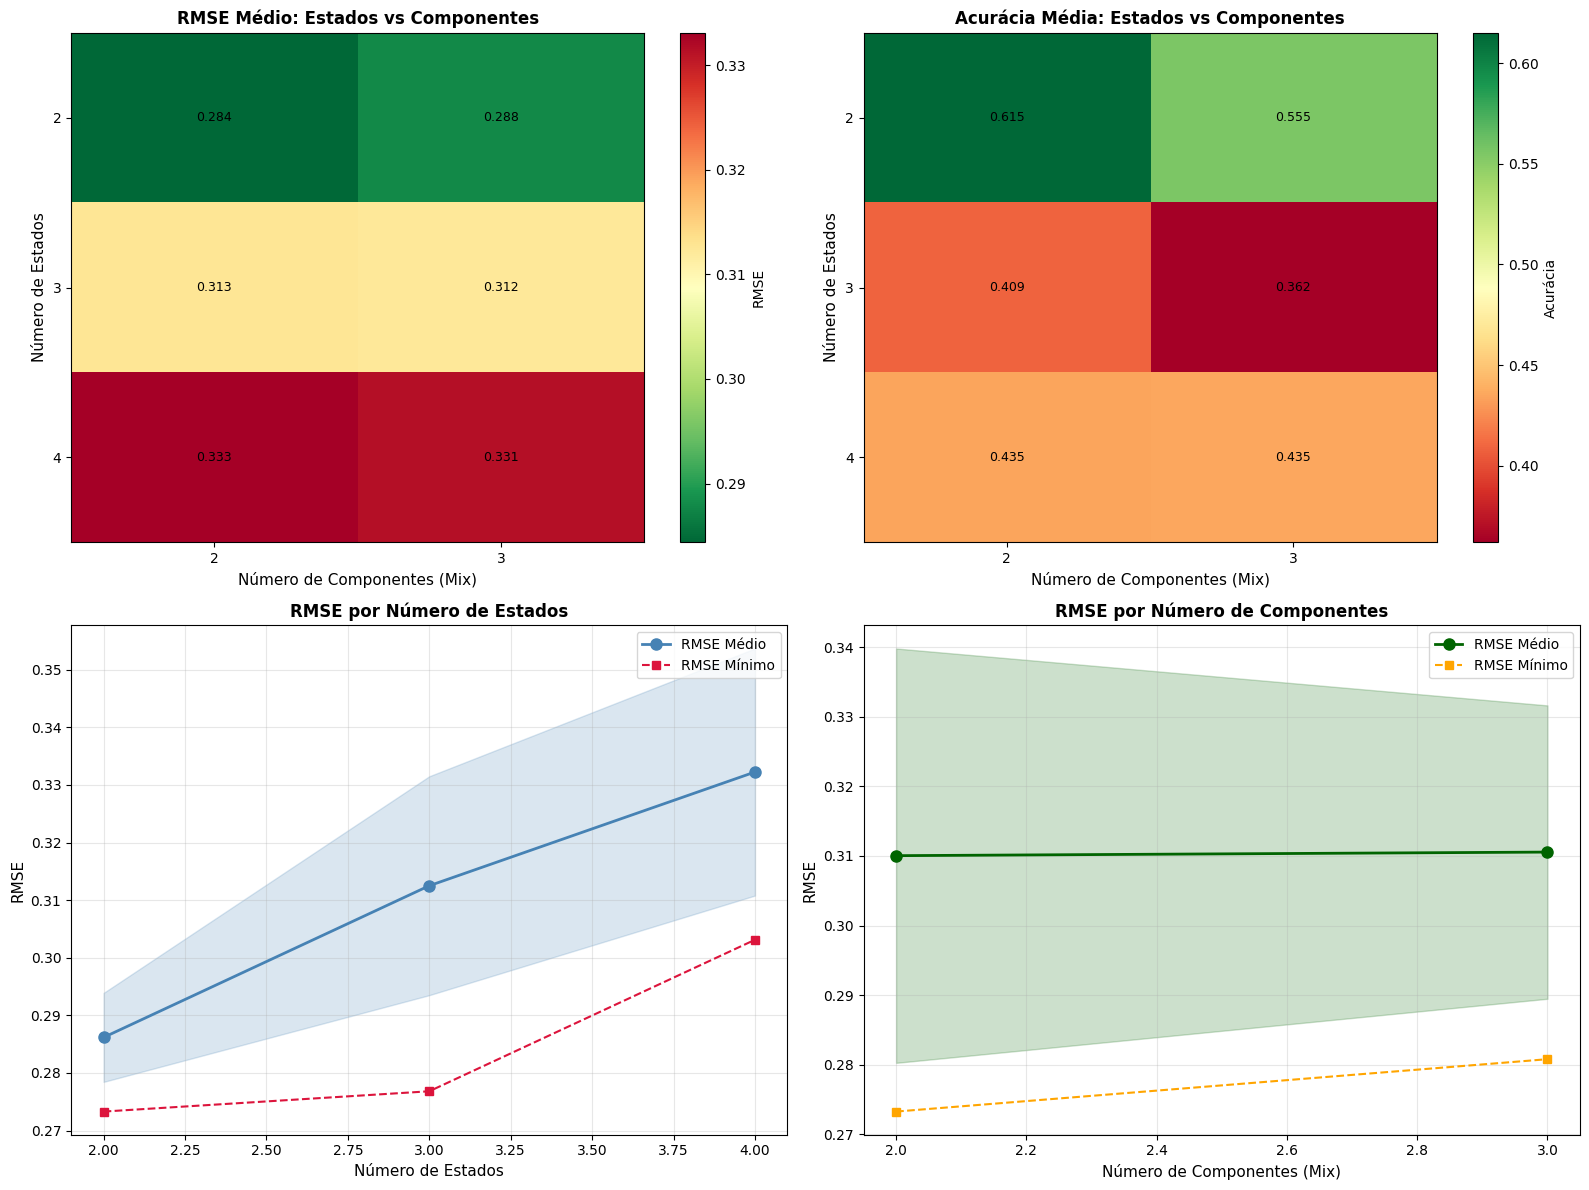



PLOTANDO MELHOR MODELO POR RMSE


C:\Users\giova\AppData\Local\Temp\ipykernel_31100\1263473777.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


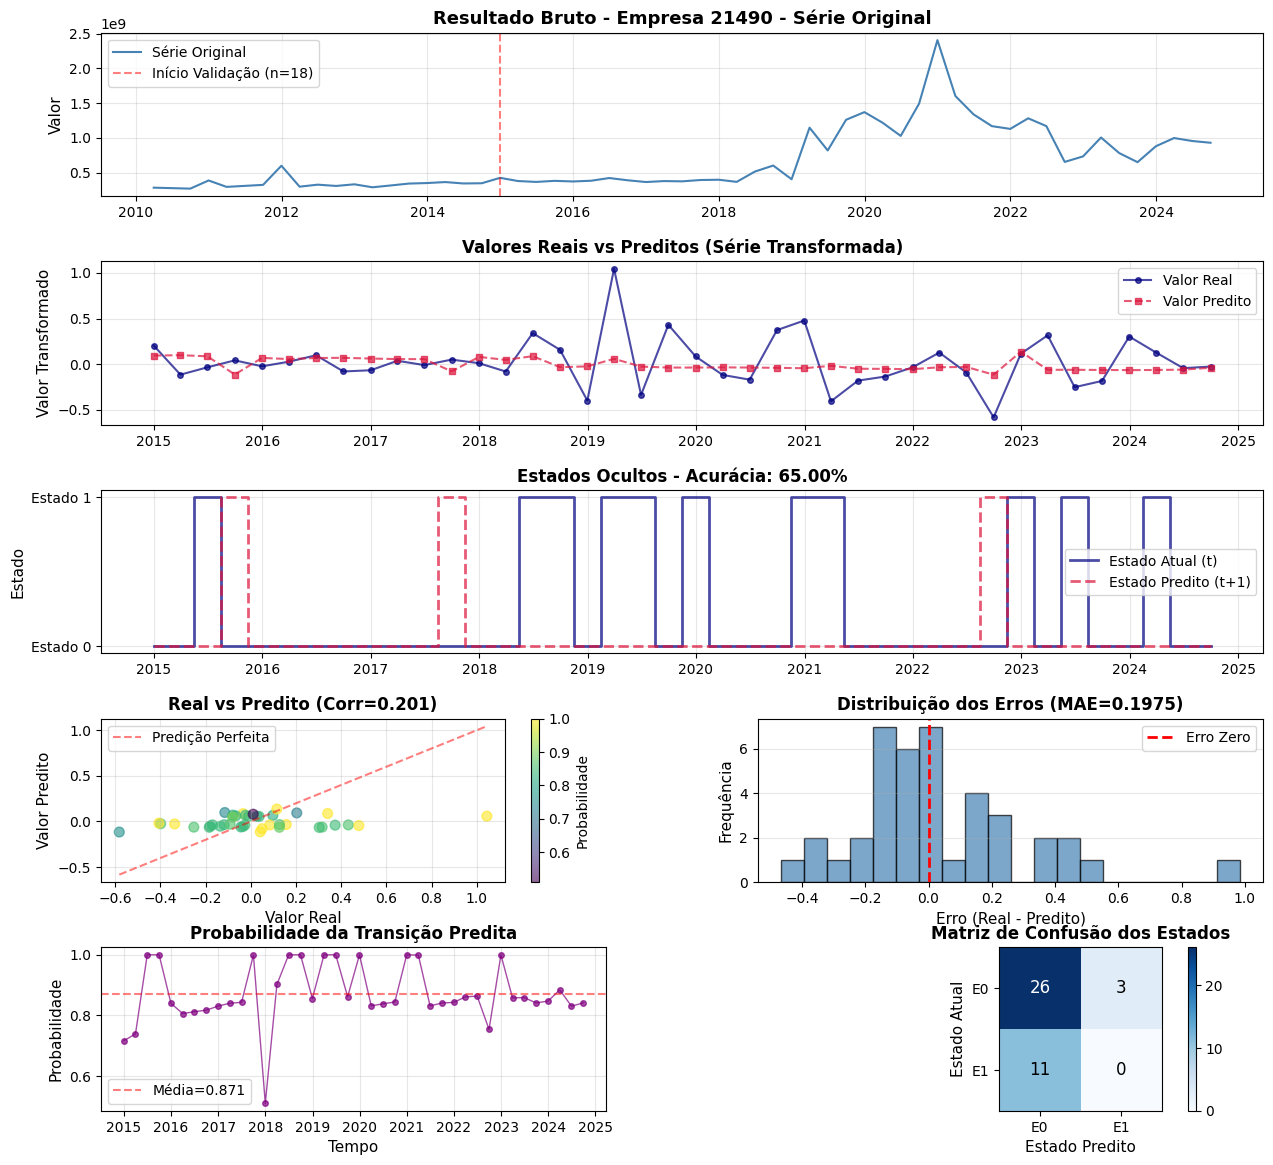

In [55]:
def gmmhmm_one_step_ahead(serie, nome_serie='Série', n_estados=3, n_mix=2, janela_treino=18,
                          aplicar_log=True, diferenciacao=1, n_iter=100, random_state=1):
    """
    Treina GMMHMM (Gaussian Mixture Model HMM) com validação one-step-ahead.
    
    O GMMHMM permite que cada estado emita observações de uma mistura de gaussianas,
    capturando distribuições mais complexas do que o GaussianHMM simples.
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        n_estados: número de estados ocultos
        n_mix: número de componentes gaussianas por estado
        janela_treino: número de observações iniciais para treino
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
        n_iter: iterações do Baum-Welch
        random_state: seed para reprodutibilidade
    
    Returns:
        dict com previsões, estados reais vs preditos e métricas
    """
    # Prepara série
    serie_transformada, serie_original, transformacoes = preparar_serie_gaussianhmm(
        serie, aplicar_log, diferenciacao
    )
    
    # Testa estacionariedade
    teste_estacionariedade = testar_estacionariedade(serie_transformada, nome_serie)
    
    obs_sequencia = serie_transformada.to_numpy()
    index_obs = serie_transformada.index
    
    if len(obs_sequencia) <= janela_treino:
        raise ValueError(f"Série tem apenas {len(obs_sequencia)} observações. Necessário > {janela_treino}")
    
    # Listas para armazenar resultados
    estados_reais = []
    estados_preditos = []
    valores_reais = []
    valores_preditos = []
    probabilidades = []
    indices = []
    
    print(f"\n{'='*70}")
    print(f"ONE-STEP-AHEAD GMMHMM - {nome_serie}")
    print(f"{'='*70}")
    print(f"Número de estados: {n_estados}")
    print(f"Componentes gaussianas por estado: {n_mix}")
    print(f"Janela de treino inicial: {janela_treino} observações")
    print(f"Total de previsões (out-of-sample): {len(obs_sequencia) - janela_treino}")
    print(f"Transformações: {' → '.join(transformacoes)}")
    print(f"Série estacionária: {'✓ SIM' if teste_estacionariedade['conclusao_estacionaria'] else '✗ NÃO'}")
    print('='*70)
    
    # Loop de previsões rolling
    for i in range(janela_treino, len(obs_sequencia)):
        treino = obs_sequencia[:i].reshape(-1, 1)
        
        # Treina modelo GMMHMM
        model = hmm.GMMHMM(
            n_components=n_estados,
            n_mix=n_mix,
            covariance_type='full',
            n_iter=n_iter,
            random_state=random_state,
            verbose=False
        )
        
        try:
            model.fit(treino)
            
            # Decodifica estados do conjunto de treino
            _, estados_treino = model.decode(treino)
            estado_atual = estados_treino[-1]
            
            # Prediz próximo estado usando matriz de transição
            probs_prox_estado = model.transmat_[estado_atual]
            estado_predito = int(np.argmax(probs_prox_estado))
            
            # Prediz próximo valor usando média ponderada das gaussianas do estado predito
            # Pega as médias e pesos das componentes do estado predito
            medias_estado = model.means_[estado_predito]  # shape: (n_mix, n_features)
            pesos_estado = model.weights_[estado_predito]  # shape: (n_mix,)
            
            # Valor predito é a média ponderada
            valor_predito = np.sum(pesos_estado * medias_estado[:, 0])
            
            # Valor real (out-of-sample)
            valor_real = obs_sequencia[i]
            
            # Armazena resultados
            estados_reais.append(estado_atual)
            estados_preditos.append(estado_predito)
            valores_reais.append(valor_real)
            valores_preditos.append(valor_predito)
            probabilidades.append(probs_prox_estado[estado_predito])
            indices.append(index_obs[i])
            
            if (i - janela_treino + 1) % 10 == 0:
                print(f"Previsão {i-janela_treino+1}/{len(obs_sequencia)-janela_treino}: "
                      f"Estado_atual={estado_atual}, Estado_pred={estado_predito}, "
                      f"Prob={probs_prox_estado[estado_predito]:.3f}")
        
        except Exception as e:
            print(f"Erro na iteração {i}: {str(e)}")
            continue
    
    if len(valores_reais) == 0:
        raise ValueError("Nenhuma previsão foi realizada!")
    
    # Cria DataFrame com resultados
    df_resultados = pd.DataFrame({
        'estado_atual': estados_reais,
        'estado_predito': estados_preditos,
        'valor_real': valores_reais,
        'valor_predito': valores_preditos,
        'probabilidade': probabilidades
    }, index=indices)
    
    # Calcula métricas
    acuracia_estados = accuracy_score(estados_reais, estados_preditos)
    
    valores_reais_arr = np.array(valores_reais)
    valores_preditos_arr = np.array(valores_preditos)
    
    mse = mean_squared_error(valores_reais_arr, valores_preditos_arr)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(valores_reais_arr - valores_preditos_arr))
    
    if len(valores_reais) > 1:
        correlacao = np.corrcoef(valores_reais_arr, valores_preditos_arr)[0, 1]
    else:
        correlacao = np.nan
    
    print(f"\n{'='*70}")
    print("RESULTADOS DA VALIDAÇÃO (OUT-OF-SAMPLE)")
    print('='*70)
    print(f"Número de previsões: {len(df_resultados)}")
    print(f"Acurácia dos Estados: {acuracia_estados:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Correlação: {correlacao:.4f}")
    print('='*70)
    
    return {
        'nome': nome_serie,
        'serie_original': serie_original,
        'serie_transformada': serie_transformada,
        'transformacoes': transformacoes,
        'teste_estacionariedade': teste_estacionariedade,
        'df_resultados': df_resultados,
        'metricas': {
            'acuracia_estados': acuracia_estados,
            'rmse': rmse,
            'mae': mae,
            'correlacao': correlacao,
            'n_predicoes': len(df_resultados)
        },
        'n_estados': n_estados,
        'n_mix': n_mix,
        'janela_treino': janela_treino
    }

def grid_search_gmmhmm_validacao(serie, nome_serie='Série', 
                                 estados_range=(2, 6),
                                 mix_range=(2, 5),
                                 janela_treino=18,
                                 n_iter=100, 
                                 random_states=None,
                                 aplicar_log=True, 
                                 diferenciacao=1):
    """
    Grid search para GMMHMM com validação one-step-ahead.
    
    Testa múltiplas combinações de:
    - Número de estados ocultos
    - Número de componentes gaussianas por estado
    - Seeds aleatórios
    
    Args:
        serie: série temporal original
        nome_serie: nome da série
        estados_range: tuple (min, max) para número de estados
        mix_range: tuple (min, max) para número de componentes gaussianas
        janela_treino: número de observações iniciais para treino
        n_iter: iterações do Baum-Welch
        random_states: lista de seeds
        aplicar_log: aplicar logaritmo
        diferenciacao: ordem de diferenciação
    
    Returns:
        dict com resultados e melhores modelos
    """
    if random_states is None:
        np.random.seed(42)
        random_states = np.random.randint(1, 1000, size=5).tolist()
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH GMMHMM COM VALIDAÇÃO - {nome_serie}")
    print(f"{'='*70}")
    print(f"Estados: {list(range(estados_range[0], estados_range[1]))}")
    print(f"Componentes Gaussianas: {list(range(mix_range[0], mix_range[1]))}")
    print(f"Seeds: {random_states}")
    print(f"Janela de treino: {janela_treino}")
    print(f"Total de combinações: {len(range(estados_range[0], estados_range[1])) * len(range(mix_range[0], mix_range[1])) * len(random_states)}")
    print('='*70)
    
    resultados = []
    
    for n_estados in range(estados_range[0], estados_range[1]):
        for n_mix in range(mix_range[0], mix_range[1]):
            for seed in random_states:
                try:
                    resultado = gmmhmm_one_step_ahead(
                        serie=serie,
                        nome_serie=nome_serie,
                        n_estados=n_estados,
                        n_mix=n_mix,
                        janela_treino=janela_treino,
                        aplicar_log=aplicar_log,
                        diferenciacao=diferenciacao,
                        n_iter=n_iter,
                        random_state=seed
                    )
                    
                    resultados.append({
                        'n_estados': n_estados,
                        'n_mix': n_mix,
                        'random_state': seed,
                        'acuracia_estados': resultado['metricas']['acuracia_estados'],
                        'rmse': resultado['metricas']['rmse'],
                        'mae': resultado['metricas']['mae'],
                        'correlacao': resultado['metricas']['correlacao'],
                        'resultado_completo': resultado
                    })
                    
                    print(f"\nEstados={n_estados}, Mix={n_mix}, Seed={seed:3d} → "
                          f"Acur={resultado['metricas']['acuracia_estados']:.3f}, "
                          f"RMSE={resultado['metricas']['rmse']:.4f}, "
                          f"MAE={resultado['metricas']['mae']:.4f}, "
                          f"Corr={resultado['metricas']['correlacao']:.3f}")
                    
                except Exception as e:
                    print(f"\nEstados={n_estados}, Mix={n_mix}, Seed={seed} → ERRO: {str(e)}")
                    continue
    
    if not resultados:
        raise ValueError("Nenhum modelo foi treinado com sucesso!")
    
    # Cria DataFrame com resultados
    df_resultados = pd.DataFrame([
        {
            'n_estados': r['n_estados'],
            'n_mix': r['n_mix'],
            'random_state': r['random_state'],
            'acuracia_estados': r['acuracia_estados'],
            'rmse': r['rmse'],
            'mae': r['mae'],
            'correlacao': r['correlacao']
        }
        for r in resultados
    ])
    
    # Identifica melhores modelos
    melhor_acuracia_idx = df_resultados['acuracia_estados'].idxmax()
    melhor_rmse_idx = df_resultados['rmse'].idxmin()
    melhor_mae_idx = df_resultados['mae'].idxmin()
    melhor_correlacao_idx = df_resultados['correlacao'].idxmax()
    
    melhor_acuracia = resultados[melhor_acuracia_idx]['resultado_completo']
    melhor_rmse = resultados[melhor_rmse_idx]['resultado_completo']
    melhor_mae = resultados[melhor_mae_idx]['resultado_completo']
    melhor_correlacao = resultados[melhor_correlacao_idx]['resultado_completo']
    
    print(f"\n{'='*70}")
    print("RESUMO DOS RESULTADOS")
    print('='*70)
    print(f"\n✓ MELHOR MODELO POR ACURÁCIA DE ESTADOS:")
    print(f"  Estados: {melhor_acuracia['n_estados']}, Mix: {melhor_acuracia['n_mix']}")
    print(f"  Acurácia: {melhor_acuracia['metricas']['acuracia_estados']:.4f}")
    print(f"  RMSE: {melhor_acuracia['metricas']['rmse']:.4f}")
    
    print(f"\n✓ MELHOR MODELO POR RMSE:")
    print(f"  Estados: {melhor_rmse['n_estados']}, Mix: {melhor_rmse['n_mix']}")
    print(f"  RMSE: {melhor_rmse['metricas']['rmse']:.4f}")
    print(f"  Acurácia: {melhor_rmse['metricas']['acuracia_estados']:.4f}")
    
    print(f"\n✓ MELHOR MODELO POR MAE:")
    print(f"  Estados: {melhor_mae['n_estados']}, Mix: {melhor_mae['n_mix']}")
    print(f"  MAE: {melhor_mae['metricas']['mae']:.4f}")
    print(f"  RMSE: {melhor_mae['metricas']['rmse']:.4f}")
    
    print(f"\n✓ MELHOR MODELO POR CORRELAÇÃO:")
    print(f"  Estados: {melhor_correlacao['n_estados']}, Mix: {melhor_correlacao['n_mix']}")
    print(f"  Correlação: {melhor_correlacao['metricas']['correlacao']:.4f}")
    print(f"  RMSE: {melhor_correlacao['metricas']['rmse']:.4f}")
    print('='*70)
    
    return {
        'nome': nome_serie,
        'df_resultados': df_resultados,
        'todos_resultados': resultados,
        'melhor_acuracia': melhor_acuracia,
        'melhor_rmse': melhor_rmse,
        'melhor_mae': melhor_mae,
        'melhor_correlacao': melhor_correlacao
    }

def plotar_comparacao_gmmhmm(resultado_grid):
    """
    Plota comparação de métricas por configuração de estados e misturas.
    
    Args:
        resultado_grid: dict retornado por grid_search_gmmhmm_validacao
    """
    df = resultado_grid['df_resultados']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heatmap: RMSE por Estados vs Mix
    ax1 = axes[0, 0]
    pivot_rmse = df.pivot_table(values='rmse', index='n_estados', columns='n_mix', aggfunc='mean')
    im1 = ax1.imshow(pivot_rmse, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
    ax1.set_xticks(range(len(pivot_rmse.columns)))
    ax1.set_yticks(range(len(pivot_rmse.index)))
    ax1.set_xticklabels(pivot_rmse.columns)
    ax1.set_yticklabels(pivot_rmse.index)
    ax1.set_xlabel('Número de Componentes (Mix)', fontsize=11)
    ax1.set_ylabel('Número de Estados', fontsize=11)
    ax1.set_title('RMSE Médio: Estados vs Componentes', fontsize=12, fontweight='bold')
    
    # Adiciona valores no heatmap
    for i in range(len(pivot_rmse.index)):
        for j in range(len(pivot_rmse.columns)):
            text = ax1.text(j, i, f'{pivot_rmse.iloc[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im1, ax=ax1, label='RMSE')
    
    # 2. Heatmap: Acurácia por Estados vs Mix
    ax2 = axes[0, 1]
    pivot_acc = df.pivot_table(values='acuracia_estados', index='n_estados', columns='n_mix', aggfunc='mean')
    im2 = ax2.imshow(pivot_acc, cmap='RdYlGn', aspect='auto', interpolation='nearest')
    ax2.set_xticks(range(len(pivot_acc.columns)))
    ax2.set_yticks(range(len(pivot_acc.index)))
    ax2.set_xticklabels(pivot_acc.columns)
    ax2.set_yticklabels(pivot_acc.index)
    ax2.set_xlabel('Número de Componentes (Mix)', fontsize=11)
    ax2.set_ylabel('Número de Estados', fontsize=11)
    ax2.set_title('Acurácia Média: Estados vs Componentes', fontsize=12, fontweight='bold')
    
    for i in range(len(pivot_acc.index)):
        for j in range(len(pivot_acc.columns)):
            text = ax2.text(j, i, f'{pivot_acc.iloc[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im2, ax=ax2, label='Acurácia')
    
    # 3. Linha: RMSE por Número de Estados (média sobre mix)
    ax3 = axes[1, 0]
    stats_estados = df.groupby('n_estados').agg({
        'rmse': ['mean', 'min', 'std'],
        'acuracia_estados': ['mean', 'max']
    }).reset_index()
    
    ax3.plot(stats_estados['n_estados'], stats_estados['rmse']['mean'], 'o-', 
             color='steelblue', linewidth=2, markersize=8, label='RMSE Médio')
    ax3.plot(stats_estados['n_estados'], stats_estados['rmse']['min'], 's--', 
             color='crimson', linewidth=1.5, markersize=6, label='RMSE Mínimo')
    ax3.fill_between(stats_estados['n_estados'], 
                     stats_estados['rmse']['mean'] - stats_estados['rmse']['std'],
                     stats_estados['rmse']['mean'] + stats_estados['rmse']['std'],
                     alpha=0.2, color='steelblue')
    ax3.set_xlabel('Número de Estados', fontsize=11)
    ax3.set_ylabel('RMSE', fontsize=11)
    ax3.set_title('RMSE por Número de Estados', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Linha: RMSE por Número de Componentes (média sobre estados)
    ax4 = axes[1, 1]
    stats_mix = df.groupby('n_mix').agg({
        'rmse': ['mean', 'min', 'std'],
        'acuracia_estados': ['mean', 'max']
    }).reset_index()
    
    ax4.plot(stats_mix['n_mix'], stats_mix['rmse']['mean'], 'o-', 
             color='darkgreen', linewidth=2, markersize=8, label='RMSE Médio')
    ax4.plot(stats_mix['n_mix'], stats_mix['rmse']['min'], 's--', 
             color='orange', linewidth=1.5, markersize=6, label='RMSE Mínimo')
    ax4.fill_between(stats_mix['n_mix'], 
                     stats_mix['rmse']['mean'] - stats_mix['rmse']['std'],
                     stats_mix['rmse']['mean'] + stats_mix['rmse']['std'],
                     alpha=0.2, color='darkgreen')
    ax4.set_xlabel('Número de Componentes (Mix)', fontsize=11)
    ax4.set_ylabel('RMSE', fontsize=11)
    ax4.set_title('RMSE por Número de Componentes', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# EXEMPLO DE USO
# ==========================================

# Teste único
empresa_analise = '21490'

print("="*70)
print("TESTE ÚNICO - GMMHMM")
print("="*70)

resultado_gmmhmm = gmmhmm_one_step_ahead(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    n_estados=3,
    n_mix=2,
    janela_treino=18,
    aplicar_log=True,
    diferenciacao=1,
    n_iter=100,
    random_state=42
)

# Plota (reutiliza função do GaussianHMM)
plotar_validacao_gaussianhmm(resultado_gmmhmm)

# Grid search completo
print("\n\n" + "="*70)
print("GRID SEARCH - GMMHMM")
print("="*70)

resultado_grid_gmmhmm = grid_search_gmmhmm_validacao(
    serie=resultado_bruto[empresa_analise],
    nome_serie=f'Resultado Bruto - Empresa {empresa_analise}',
    estados_range=(2, 5),  # 2, 3, 4 estados
    mix_range=(2, 4),      # 2, 3 componentes
    janela_treino=18,
    n_iter=100,
    random_states=[1, 42, 99, 150, 200],
    aplicar_log=True,
    diferenciacao=1
)

# Exibe tabela resumo
print("\n=== TOP 10 MODELOS POR RMSE ===")
display(resultado_grid_gmmhmm['df_resultados'].sort_values('rmse').head(10))

print("\n=== TOP 10 MODELOS POR ACURÁCIA ===")
display(resultado_grid_gmmhmm['df_resultados'].sort_values('acuracia_estados', ascending=False).head(10))

# Plota comparações
plotar_comparacao_gmmhmm(resultado_grid_gmmhmm)

# Plota melhor modelo
print("\n\nPLOTANDO MELHOR MODELO POR RMSE")
plotar_validacao_gaussianhmm(resultado_grid_gmmhmm['melhor_rmse'])

K-means

In [70]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

def discretiza_kmeans(serie, bins):

    log_returns = np.diff(np.log(serie))  # Exemplo de retornos logarítmicos
    log_returns = np.nan_to_num(log_returns, nan=0.0)


    # Suponha que 'log_returns' seja sua série de retornos (percentual)
    # Formato deve ser 2D: (n_samples, 1)
    X = log_returns.reshape(-1, 1)

    index_ajustado = serie.index[1:]


    # --- OPÇÃO 1: K-MEANS (O que você provavelmente intencionava) ---
    # Define os ranges baseados na concentração dos dados
    est_kmeans = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    X_discrete_kmeans = est_kmeans.fit_transform(X)

    print("Bordas dos Bins (K-Means):")
    print(est_kmeans.bin_edges_[0])
    # Exemplo de saída: [-0.5, -0.1, 0.05, 0.2, 0.6] 
    # (Note como os intervalos têm tamanhos diferentes, adaptados aos dados)

    # --- OPÇÃO 2: QUANTILE (Recomendada para Finanças) ---
    # Garante a mesma quantidade de dias em cada bin
    # est_quantile = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
    # X_discrete_quantile = est_quantile.fit_transform(X)

    # print("\nBordas dos Bins (Quantile):")
    # print(est_quantile.bin_edges_[0])

    df_resultado_kmeans = pd.DataFrame(
        X_discrete_kmeans,          # Os dados discretizados (0, 1, 2...)
        index=index_ajustado,       # As datas alinhadas (excluindo a primeira)
        columns=['estado_kmeans']   # Nome da coluna
    )

    X_discrete_kmeans_1d = X_discrete_kmeans.astype(int)

    # df_resultado_quantile = pd.DataFrame(
    #     X_discrete_quantile,          # Os dados discretizados (0, 1, 2...)
    #     index=index_ajustado,       # As datas alinhadas (excluindo a primeira)
    #     columns=['estado_quantile']   # Nome da coluna
    # )

    df_resultado_kmeans['estado_kmeans'] = df_resultado_kmeans['estado_kmeans'].astype(int)
    #df_resultado_quantile['estado_quantile'] = df_resultado_quantile['estado_quantile'].astype(int)

    return X_discrete_kmeans_1d

In [71]:
dis = discretiza_kmeans(resultado_bruto['2437'], bins=3)

Bordas dos Bins (K-Means):
[-1.34640617 -0.31999062  0.6217333   1.58786381]


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [67]:
print(np.diff(np.log(resultado_bruto['2437'])))


[ 0.06700322  0.06093086  0.36365647 -0.16336983 -0.37681436  0.19035134
  0.48656494 -0.2193813  -0.02827108  0.06890649  0.18348711 -0.53417479
  0.01394216  0.04518483  0.00898656  0.11235599 -0.00685941 -0.20506669
  0.11926027  0.14699704 -0.04422766 -0.04023941 -0.00528869 -0.15065089
  1.58786381 -1.34640617  0.3564485  -0.31537711  0.01387536 -0.02243856
  0.2054699  -0.2397621   0.35776406 -0.31862909         nan         nan
  0.02927211  0.09306004  0.00652112 -0.05365428  0.4671757  -0.40103846
 -0.72584765  0.82531933 -0.03082616  0.22390343  0.14340702 -0.22447472
 -0.03607049 -0.09754048 -0.00363637  0.14034829  0.00386847 -0.05150093
  0.12212684 -0.12934517 -0.03775106  0.27412025]


In [ ]:
#converter X_discrete_quantile e X_discrete_kmeans para um array 1D de inteiros


In [23]:
def hmm_grid_search_discretizado(serie_receita, estados_range=(2, 6), bins_range=(2, 11), janela=12, n_iter=100, random_series=[1,42,6,99,7,150,33,25,21,12,200,2,3,4,5,6,100,350,2,3,4,5]):
    """
    Grid search para HMM variando número de estados e bins de discretização.
    
    Args:
        serie_receita: série temporal de receita
        estados_range: tuple (min, max) para número de estados
        bins_range: tuple (min, max) para número de bins
        janela: tamanho da janela rolling
        n_iter: iterações do algoritmo Baum-Welch
        random_series: lista de seeds para testar
    
    Returns:
        DataFrame com resultados ordenados por acurácia
    """
    resultados = []
    
    # Gera todas as combinações
    combinacoes = list(product(
        range(estados_range[0], estados_range[1]),
        range(bins_range[0], bins_range[1])
    ))
    
    print(f"Testando {len(combinacoes)} combinações...")
    
    for n_estados, n_bins in combinacoes:
        try:
            # Discretiza com n_bins
            obs = serie_receita.to_numpy().reshape(-1, 1)
            idx_obs = serie_receita.index
            
            # Loop sobre diferentes random_states
            for r in random_series:
                preds, reals = [], []
                
                # Loop de previsões rolling
                for i in range(janela, len(obs)):  
                    history = obs[i - janela:i]
                    
                    model = hmm.CategoricalHMM(
                        n_components=n_estados,
                        n_iter=n_iter,
                        random_state=r,
                        verbose=False
                    )
                    model.fit(history)
                    
                    estado_atual = model.predict(history)[-1]
                    probs_prox_obs = model.transmat_[estado_atual] @ model.emissionprob_
                    prox_simbolo = int(np.argmax(probs_prox_obs))
                    
                    preds.append(prox_simbolo)
                    reals.append(int(obs[i][0]))
                
                # Calcula acurácia APÓS todas as previsões
                acuracia = accuracy_score(reals, preds)
                
                # Armazena resultado UMA VEZ por combinação
                resultados.append({
                    'n_estados': n_estados,
                    'n_bins': n_bins,
                    'random_state': r,
                    'acuracia': acuracia,
                    'n_previsoes': len(preds)
                })
                
                print(f"Estados={n_estados}, Bins={n_bins}, Seed={r} → Acurácia={acuracia:.4f} ({len(preds)} previsões)")
            
        except Exception as e:
            print(f"Erro com Estados={n_estados}, Bins={n_bins}: {str(e)}")
            continue
    
    df_resultados = pd.DataFrame(resultados).sort_values('acuracia', ascending=False)
    return df_resultados

In [31]:
# Teste para uma empresa
empresa_teste = '20257'
resultados_grid = hmm_grid_search_discretizado(
    df_resultado_kmeans,
    estados_range=(2,5),
    bins_range=(3,4),
    janela=18
)

print("\n=== Top 10 Melhores Configurações ===")
display(resultados_grid.head(10))

print("\n=== Melhor Configuração ===")
melhor = resultados_grid.iloc[0]
print(f"Estados: {melhor['n_estados']}, Bins: {melhor['n_bins']}, Acurácia: {melhor['acuracia']:.4f}")

Testando 3 combinações...
Estados=2, Bins=3, Seed=1 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=42 → Acurácia=0.7250 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=99 → Acurácia=0.7250 (40 previsões)
Estados=2, Bins=3, Seed=7 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=150 → Acurácia=0.7000 (40 previsões)
Estados=2, Bins=3, Seed=33 → Acurácia=0.7250 (40 previsões)
Estados=2, Bins=3, Seed=25 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=21 → Acurácia=0.7000 (40 previsões)
Estados=2, Bins=3, Seed=12 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=200 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=2 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=3 → Acurácia=0.7250 (40 previsões)
Estados=2, Bins=3, Seed=4 → Acurácia=0.7250 (40 previsões)
Estados=2, Bins=3, Seed=5 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.6750 (40 previsões)
Estados=2, Bins=3, S

Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=3, Bins=3, Seed=5 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=1 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=42 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=99 → Acurácia=0.7250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=7 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=150 → Acurácia=0.5750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=33 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=25 → Acurácia=0.5750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=21 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=12 → Acurácia=0.5250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=200 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=2 → Acurácia=0.5500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=3 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=4 → Acurácia=0.7250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=5 → Acurácia=0.6500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=100 → Acurácia=0.6250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=350 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=2 → Acurácia=0.5500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=3 → Acurácia=0.6000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=4 → Acurácia=0.7250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=5 → Acurácia=0.6500 (40 previsões)

=== Top 10 Melhores Configurações ===


n_estados  n_bins  random_state  acuracia  n_previsoes
20          2       3             4     0.725           40
47          4       3            99     0.725           40
34          3       3             3     0.725           40
13          2       3             4     0.725           40
12          2       3             3     0.725           40
39          3       3           350     0.725           40
19          2       3             3     0.725           40
41          3       3             3     0.725           40
6           2       3            33     0.725           40
57          4       3             4     0.725           40


=== Melhor Configuração ===
Estados: 2.0, Bins: 3.0, Acurácia: 0.7250


In [32]:
# Teste para uma empresa
empresa_teste = '20257'
resultados_grid = hmm_grid_search_discretizado(
    df_resultado_quantile,
    estados_range=(2,5),
    bins_range=(3,4),
    janela=18
)

print("\n=== Top 10 Melhores Configurações ===")
display(resultados_grid.head(10))

print("\n=== Melhor Configuração ===")
melhor = resultados_grid.iloc[0]
print(f"Estados: {melhor['n_estados']}, Bins: {melhor['n_bins']}, Acurácia: {melhor['acuracia']:.4f}")

Testando 3 combinações...
Estados=2, Bins=3, Seed=1 → Acurácia=0.2500 (40 previsões)
Estados=2, Bins=3, Seed=42 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, Seed=99 → Acurácia=0.3000 (40 previsões)
Estados=2, Bins=3, Seed=7 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, Seed=150 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, Seed=33 → Acurácia=0.3000 (40 previsões)
Estados=2, Bins=3, Seed=25 → Acurácia=0.3000 (40 previsões)
Estados=2, Bins=3, Seed=21 → Acurácia=0.3250 (40 previsões)
Estados=2, Bins=3, Seed=12 → Acurácia=0.1750 (40 previsões)
Estados=2, Bins=3, Seed=200 → Acurácia=0.2500 (40 previsões)
Estados=2, Bins=3, Seed=2 → Acurácia=0.2500 (40 previsões)
Estados=2, Bins=3, Seed=3 → Acurácia=0.3250 (40 previsões)
Estados=2, Bins=3, Seed=4 → Acurácia=0.3250 (40 previsões)
Estados=2, Bins=3, Seed=5 → Acurácia=0.2250 (40 previsões)
Estados=2, Bins=3, Seed=6 → Acurácia=0.2750 (40 previsões)
Estados=2, Bins=3, S

Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=3, Bins=3, Seed=5 → Acurácia=0.4000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=1 → Acurácia=0.4250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=42 → Acurácia=0.3750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=99 → Acurácia=0.3250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=7 → Acurácia=0.3000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=150 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=33 → Acurácia=0.3250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=25 → Acurácia=0.3250 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=21 → Acurácia=0.2750 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=12 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=200 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=2 → Acurácia=0.4000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=3 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=4 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=5 → Acurácia=0.3000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=6 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=100 → Acurácia=0.3000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=350 → Acurácia=0.4500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=2 → Acurácia=0.4000 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=3 → Acurácia=0.2500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=4 → Acurácia=0.3500 (40 previsões)


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

Estados=4, Bins=3, Seed=5 → Acurácia=0.3000 (40 previsões)

=== Top 10 Melhores Configurações ===


n_estados  n_bins  random_state  acuracia  n_previsoes
31          3       3            12     0.475           40
61          4       3           350     0.450           40
44          4       3             1     0.425           40
36          3       3             5     0.400           40
34          3       3             3     0.400           40
62          4       3             2     0.400           40
41          3       3             3     0.400           40
43          3       3             5     0.400           40
55          4       3             2     0.400           40
40          3       3             2     0.375           40


=== Melhor Configuração ===
Estados: 3.0, Bins: 3.0, Acurácia: 0.4750


Comparar empresas

In [56]:
def hmm_grid_search_multiplas_empresas(empresas_list, indicador_series, nome_indicador,
                                       estados_range=(2, 6), bins_range=(2, 11), 
                                       janela=12, n_iter=100, 
                                       random_series=[1,42,6,99,7,150,33,25,21,12,200,2,3,4,5,6,100,350,8,9,10]):
    """
    Grid search para HMM em múltiplas empresas e plota comparação dos melhores modelos.
    
    Args:
        empresas_list: lista de códigos das empresas
        indicador_series: DataFrame com séries do indicador por empresa
        nome_indicador: nome do indicador (ex: 'Resultado Bruto')
        estados_range: tuple (min, max) para número de estados
        bins_range: tuple (min, max) para número de bins
        janela: tamanho da janela rolling
        n_iter: iterações do algoritmo Baum-Welch
        random_series: lista de seeds para testar
    
    Returns:
        dict com resultados de grid search e melhores modelos por empresa
    """
    resultados_empresas = {}
    melhores_modelos = {}
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH HMM - {nome_indicador} - MÚLTIPLAS EMPRESAS")
    print(f"{'='*70}")
    print(f"Empresas: {empresas_list}")
    print(f"Testando estados: {list(range(estados_range[0], estados_range[1]))}")
    print(f"Testando bins: {list(range(bins_range[0], bins_range[1]))}")
    print(f"Seeds: {random_series}")
    print('='*70)
    
    # Grid search para cada empresa
    for empresa in empresas_list:
        print(f"\n{'='*70}")
        print(f"PROCESSANDO EMPRESA {empresa}")
        print('='*70)
        
        try:
            # Obtém série da empresa
            if isinstance(indicador_series, pd.DataFrame):
                serie = indicador_series[empresa]
            else:
                serie = indicador_series[empresa]
            

            if len(serie_pct) <= janela:
                print(f"⚠ Empresa {empresa}: série muito curta ({len(serie_pct)} observações)")
                continue
            
            # Executa grid search
            resultados = []
            combinacoes = list(product(
                range(estados_range[0], estados_range[1]),
                range(bins_range[0], bins_range[1])
            ))
            
            print(f"Testando {len(combinacoes)} combinações de estados/bins...")
            
            for n_estados, n_bins in combinacoes:
                try:
                    # Discretiza com n_bins
                    obs = discretiza_kmeans(serie, n_bins)
                    
                    # Loop sobre diferentes random_states
                    for r in random_series:
                        preds, reals = [], []
                        
                        # Loop de previsões rolling
                        for i in range(janela, len(obs)):
                            history = obs[i - janela:i]
                            
                            model = hmm.CategoricalHMM(
                                n_components=n_estados,
                                n_iter=n_iter,
                                random_state=r,
                                verbose=False
                            )
                            model.fit(history)
                            
                            estado_atual = model.predict(history)[-1]
                            probs_prox_obs = model.transmat_[estado_atual] @ model.emissionprob_
                            prox_simbolo = int(np.argmax(probs_prox_obs))
                            
                            preds.append(prox_simbolo)
                            reals.append(int(obs[i][0]))
                        
                        # Calcula acurácia
                        acuracia = accuracy_score(reals, preds)
                        
                        # Armazena resultado
                        resultados.append({
                            'empresa': empresa,
                            'n_estados': n_estados,
                            'n_bins': n_bins,
                            'random_state': r,
                            'acuracia': acuracia,
                            'n_previsoes': len(preds)
                        })
                        
                        print(f"  Estados={n_estados}, Bins={n_bins}, Seed={r} → "
                              f"Acurácia={acuracia:.4f}")
                
                except Exception as e:
                    print(f"  Erro Estados={n_estados}, Bins={n_bins}: {str(e)}")
                    continue
            
            # Organiza resultados
            df_resultados = pd.DataFrame(resultados).sort_values('acuracia', ascending=False)
            resultados_empresas[empresa] = df_resultados
            
            # Identifica melhor configuração
            melhor = df_resultados.iloc[0]
            print(f"\n✓ MELHOR MODELO EMPRESA {empresa}:")
            print(f"  Estados: {melhor['n_estados']}, Bins: {melhor['n_bins']}, "
                  f"Seed: {melhor['random_state']}")
            print(f"  Acurácia: {melhor['acuracia']:.4f} ({melhor['n_previsoes']} previsões)")
            
            # Treina modelo final com melhor configuração
            obs_final = serie_pct.apply(
                lambda x: discretizar_receita_parametrizada(x, int(melhor['n_bins']))
            ).to_numpy().reshape(-1, 1)
            
            model_final = hmm.CategoricalHMM(
                n_components=int(melhor['n_estados']),
                n_iter=n_iter,
                random_state=int(melhor['random_state'])
            )
            model_final.fit(obs_final)
            _, estados_final = model_final.decode(obs_final)
            
            melhores_modelos[empresa] = {
                'serie_original': serie.loc[serie_pct.index],
                'serie_pct': serie_pct,
                'estados': estados_final,
                'index': serie_pct.index,
                'modelo': model_final,
                'melhor_config': melhor,
                'convergiu': model_final.monitor_.converged,
                'log_likelihood': model_final.monitor_.history[-1] if model_final.monitor_.history else np.nan
            }
            
        except Exception as e:
            print(f"✗ ERRO EMPRESA {empresa}: {str(e)}")
            continue
    
    if not melhores_modelos:
        raise ValueError("Nenhum modelo foi treinado com sucesso!")
    
    # Plota comparação
    plotar_comparacao_melhores_modelos(melhores_modelos, nome_indicador)
    
    # Exibe resumo comparativo
    resumo_comparativo(resultados_empresas, melhores_modelos, nome_indicador)
    
    return {
        'resultados_empresas': resultados_empresas,
        'melhores_modelos': melhores_modelos,
        'nome_indicador': nome_indicador
    }


def plotar_comparacao_melhores_modelos(melhores_modelos, nome_indicador):
    """
    Plota comparação dos melhores modelos de múltiplas empresas.
    
    Args:
        melhores_modelos: dict com melhores modelos por empresa
        nome_indicador: nome do indicador
    """
    n_empresas = len(melhores_modelos)
    fig, axes = plt.subplots(n_empresas + 1, 1, figsize=(15, 4 * (n_empresas + 1)))
    
    if n_empresas == 1:
        axes = [axes]
    
    cores_estados_base = ['crimson', 'navy', 'darkgreen', 'purple', 'orange', 'brown']
    
    # Plot individual de cada empresa
    for i, (empresa, dados) in enumerate(melhores_modelos.items()):
        ax = axes[i]
        
        # Série original
        ax.plot(dados['index'], dados['serie_original'].loc[dados['index']], 
                color='steelblue', label=f'{nome_indicador} (valor)', alpha=0.7, linewidth=1.5)
        
        # Configuração
        config = dados['melhor_config']
        ax.set_ylabel(nome_indicador, fontsize=11)
        ax.set_title(
            f'{nome_indicador} – Empresa {empresa} | '
            f'Estados={int(config["n_estados"])}, Bins={int(config["n_bins"])}, '
            f'Acurácia={config["acuracia"]:.2%}',
            fontsize=12, fontweight='bold'
        )
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        
        # Eixo secundário para estados
        ax2 = ax.twinx()
        n_estados = int(config['n_estados'])
        
        # Colorir estados
        for estado in range(n_estados):
            mascara = dados['estados'] == estado
            ax2.scatter(dados['index'][mascara], 
                       [estado] * mascara.sum(),
                       c=cores_estados_base[estado % len(cores_estados_base)],
                       s=50, alpha=0.6, label=f'Estado {estado}', marker='s')
        
        ax2.step(dados['index'], dados['estados'], where='mid', 
                color='crimson', linewidth=1.5, alpha=0.3)
        ax2.set_ylabel('Estados HMM', fontsize=11)
        ax2.set_yticks(range(n_estados))
        ax2.set_yticklabels([f'E{i}' for i in range(n_estados)])
        ax2.legend(loc='upper right', fontsize=9)
    
    # Plot comparativo (último subplot)
    ax_comp = axes[-1]
    cores_empresas = ['crimson', 'navy', 'darkgreen', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for idx, (empresa, dados) in enumerate(melhores_modelos.items()):
        # Normaliza estados para comparação (0 a 1)
        n_estados = int(dados['melhor_config']['n_estados'])
        estados_norm = dados['estados'] / (n_estados - 1) if n_estados > 1 else dados['estados']
        
        ax_comp.step(dados['index'], estados_norm, where='mid',
                    label=f'Empresa {empresa} ({int(dados["melhor_config"]["n_estados"])} estados)',
                    linewidth=2, color=cores_empresas[idx % len(cores_empresas)], 
                    alpha=0.8, linestyle='--')
    
    ax_comp.set_title(
        f'Comparação de Estados Normalizados: {nome_indicador} – Múltiplas Empresas',
        fontsize=13, fontweight='bold'
    )
    ax_comp.set_xlabel('Tempo', fontsize=11)
    ax_comp.set_ylabel('Estado Normalizado (0=Baixo, 1=Alto)', fontsize=11)
    ax_comp.set_ylim(-0.1, 1.1)
    ax_comp.legend(loc='upper left', fontsize=10, ncol=2)
    ax_comp.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def resumo_comparativo(resultados_empresas, melhores_modelos, nome_indicador):
    """
    Exibe resumo comparativo dos modelos.
    
    Args:
        resultados_empresas: dict com DataFrames de resultados por empresa
        melhores_modelos: dict com melhores modelos por empresa
        nome_indicador: nome do indicador
    """
    print(f"\n{'='*70}")
    print(f"RESUMO COMPARATIVO - {nome_indicador}")
    print('='*70)
    
    # Tabela de melhores configurações
    dados_resumo = []
    for empresa, dados in melhores_modelos.items():
        config = dados['melhor_config']
        dados_resumo.append({
            'Empresa': empresa,
            'Estados': int(config['n_estados']),
            'Bins': int(config['n_bins']),
            'Seed': int(config['random_state']),
            'Acurácia': config['acuracia'],
            'N_Previsões': config['n_previsoes'],
            'Convergiu': '✓' if dados['convergiu'] else '✗',
            'Log-Likelihood': dados['log_likelihood']
        })
    
    df_resumo = pd.DataFrame(dados_resumo).sort_values('Acurácia', ascending=False)
    
    print("\n--- Melhores Configurações por Empresa ---")
    print(df_resumo.to_string(index=False))
    
    # Estatísticas agregadas
    print(f"\n--- Estatísticas Agregadas ---")
    print(f"Acurácia Média: {df_resumo['Acurácia'].mean():.4f}")
    print(f"Acurácia Mediana: {df_resumo['Acurácia'].median():.4f}")
    print(f"Acurácia Min/Max: {df_resumo['Acurácia'].min():.4f} / {df_resumo['Acurácia'].max():.4f}")
    print(f"Desvio Padrão: {df_resumo['Acurácia'].std():.4f}")
    
    # Distribuição de configurações
    print(f"\n--- Distribuição de Configurações Vencedoras ---")
    print(f"Estados mais frequentes: {df_resumo['Estados'].mode().values}")
    print(f"Bins mais frequentes: {df_resumo['Bins'].mode().values}")
    
    print(f"\n--- Matrizes de Transição dos Melhores Modelos ---")
    for empresa, dados in melhores_modelos.items():
        print(f"\nEmpresa {empresa} ({int(dados['melhor_config']['n_estados'])} estados):")
        print(dados['modelo'].transmat_.round(3))
    
    print('='*70)


def plotar_distribuicao_acuracias(resultados_empresas, nome_indicador):
    """
    Plota distribuição de acurácias do grid search por empresa.
    
    Args:
        resultados_empresas: dict com DataFrames de resultados
        nome_indicador: nome do indicador
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Boxplot de acurácias por empresa
    ax1 = axes[0]
    dados_boxplot = [df['acuracia'].values for df in resultados_empresas.values()]
    empresas = list(resultados_empresas.keys())
    
    bp = ax1.boxplot(dados_boxplot, labels=empresas, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.6)
    
    ax1.set_xlabel('Empresa', fontsize=11)
    ax1.set_ylabel('Acurácia', fontsize=11)
    ax1.set_title(f'Distribuição de Acurácias - {nome_indicador}', 
                  fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Histogramas sobrepostos
    ax2 = axes[1]
    cores = ['steelblue', 'crimson', 'darkgreen', 'purple', 'orange']
    
    for idx, (empresa, df) in enumerate(resultados_empresas.items()):
        ax2.hist(df['acuracia'], bins=20, alpha=0.5, 
                label=f'Empresa {empresa}',
                color=cores[idx % len(cores)])
    
    ax2.set_xlabel('Acurácia', fontsize=11)
    ax2.set_ylabel('Frequência', fontsize=11)
    ax2.set_title(f'Histograma de Acurácias - {nome_indicador}',
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

GRID SEARCH HMM - RESULTADO BRUTO - MÚLTIPLAS EMPRESAS

GRID SEARCH HMM - Resultado Bruto - MÚLTIPLAS EMPRESAS
Empresas: ['21490', '2437', '20257', '18376']
Testando estados: [2, 3, 4]
Testando bins: [3, 4]
Seeds: [1, 42, 6, 99, 7, 150, 33, 25, 21, 12, 200, 2, 3, 4, 5, 6, 100, 350, 8, 9, 10]

PROCESSANDO EMPRESA 21490
Testando 6 combinações de estados/bins...
Bordas dos Bins (K-Means):
[-0.70240877 -0.16907437  0.2423164   1.04463212]


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=2, Bins=3, Seed=1 → Acurácia=0.5750
  Estados=2, Bins=3, Seed=42 → Acurácia=0.5750
  Estados=2, Bins=3, Seed=6 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=99 → Acurácia=0.5500
  Estados=2, Bins=3, Seed=7 → Acurácia=0.6250
  Estados=2, Bins=3, Seed=150 → Acurácia=0.6000
  Estados=2, Bins=3, Seed=33 → Acurácia=0.5500
  Estados=2, Bins=3, Seed=25 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=21 → Acurácia=0.5500
  Estados=2, Bins=3, Seed=12 → Acurácia=0.5750
  Estados=2, Bins=3, Seed=200 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=2 → Acurácia=0.6000
  Estados=2, Bins=3, Seed=3 → Acurácia=0.5500
  Estados=2, Bins=3, Seed=4 → Acurácia=0.5250
  Estados=2, Bins=3, Seed=5 → Acurácia=0.5750
  Estados=2, Bins=3, Seed=6 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=100 → Acurácia=0.6000
  Estados=2, Bins=3, Seed=350 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=8 → Acurácia=0.6500
  Estados=2, Bins=3, Seed=9 → Acurácia=0.5500
  Estados=2, Bins=3, Seed=10 → Acurácia=0.5750
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=2, Bins=4, Seed=1 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=42 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=6 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=99 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=7 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=150 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=33 → Acurácia=0.6500
  Estados=2, Bins=4, Seed=25 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=21 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=12 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=200 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=2 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=3 → Acurácia=0.6500
  Estados=2, Bins=4, Seed=4 → Acurácia=0.6500
  Estados=2, Bins=4, Seed=5 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=6 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=100 → Acurácia=0.6750
  Estados=2, Bins=4, Seed=350 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=8 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=9 → Acurácia=0.6500
  Estados=2, Bins=4, Seed=10 → Acurácia=0.6250
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=3, Seed=1 → Acurácia=0.4750
  Estados=3, Bins=3, Seed=42 → Acurácia=0.5250
  Estados=3, Bins=3, Seed=6 → Acurácia=0.5750
  Estados=3, Bins=3, Seed=99 → Acurácia=0.5000
  Estados=3, Bins=3, Seed=7 → Acurácia=0.6000
  Estados=3, Bins=3, Seed=150 → Acurácia=0.4750
  Estados=3, Bins=3, Seed=33 → Acurácia=0.4250
  Estados=3, Bins=3, Seed=25 → Acurácia=0.5500
  Estados=3, Bins=3, Seed=21 → Acurácia=0.5250
  Estados=3, Bins=3, Seed=12 → Acurácia=0.5750
  Estados=3, Bins=3, Seed=200 → Acurácia=0.5000
  Estados=3, Bins=3, Seed=2 → Acurácia=0.5750
  Estados=3, Bins=3, Seed=3 → Acurácia=0.5000
  Estados=3, Bins=3, Seed=4 → Acurácia=0.5750
  Estados=3, Bins=3, Seed=5 → Acurácia=0.4750
  Estados=3, Bins=3, Seed=6 → Acurácia=0.5750
  Estados=3, Bins=3, Seed=100 → Acurácia=0.5500
  Estados=3, Bins=3, Seed=350 → Acurácia=0.4750
  Estados=3, Bins=3, Seed=8 → Acurácia=0.5250
  Estados=3, Bins=3, Seed=9 → Acurácia=0.4750
  Estados=3, Bins=3, Seed=10 → Acurácia=0.6000
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=4, Seed=1 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=42 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=6 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=99 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=7 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=150 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=33 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=25 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=21 → Acurácia=0.6250
  Estados=3, Bins=4, Seed=12 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=200 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=2 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=3 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=4 → Acurácia=0.5250
  Estados=3, Bins=4, Seed=5 → Acurácia=0.6500
  Estados=3, Bins=4, Seed=6 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=100 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=350 → Acurácia=0.5250
  Estados=3, Bins=4, Seed=8 → Acurácia=0.5250
  Estados=3, Bins=4, Seed=9 → Acurácia=0.5750


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameter

  Estados=3, Bins=4, Seed=10 → Acurácia=0.5250
Bordas dos Bins (K-Means):
[-0.70240877 -0.16907437  0.2423164   1.04463212]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=1 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=42 → Acurácia=0.5500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=99 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=7 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=150 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=33 → Acurácia=0.4500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=25 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=21 → Acurácia=0.5000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=12 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=200 → Acurácia=0.5500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=2 → Acurácia=0.4750


Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=3 → Acurácia=0.5000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=4 → Acurácia=0.5250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=5 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=100 → Acurácia=0.5500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=350 → Acurácia=0.5000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=8 → Acurácia=0.5500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=9 → Acurácia=0.4750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=10 → Acurácia=0.5000
Bordas dos Bins (K-Means):
[-0.70240877 -0.21489078  0.17146627  0.59117441  1.04463212]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=1 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=42 → Acurácia=0.3750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=99 → Acurácia=0.5000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=7 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=150 → Acurácia=0.4750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=33 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=25 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=21 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=12 → Acurácia=0.5250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=200 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=2 → Acurácia=0.5250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=3 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=4 → Acurácia=0.6000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=5 → Acurácia=0.5250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=100 → Acurácia=0.6250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=350 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=8 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=9 → Acurácia=0.4750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=10 → Acurácia=0.6000

✓ MELHOR MODELO EMPRESA 21490:
  Estados: 2, Bins: 4, Seed: 5
  Acurácia: 0.6750 (40 previsões)

PROCESSANDO EMPRESA 2437
Testando 6 combinações de estados/bins...
Bordas dos Bins (K-Means):
[-1.34640617 -0.31999062  0.6217333   1.58786381]
  Estados=2, Bins=3, Seed=1 → Acurácia=0.8000
  Estados=2, Bins=3, Seed=42 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=6 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=99 → Acurácia=0.8250
  Estados=2, Bins=3, Seed=7 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=150 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=33 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=25 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=21 → Acurácia=0.8250
  Estados=2, Bins=3, Seed=12 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=200 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=2 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=3 → Acurácia=0.8250
  Estados=2, Bins=3, Seed=4 → Acurácia=0.8000
  Estados=2, Bins=3, Seed=5 → Acurácia=0.8750
  Estados=2

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=2, Bins=4, Seed=1 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=42 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=6 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=99 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=7 → Acurácia=0.5500
  Estados=2, Bins=4, Seed=150 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=33 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=25 → Acurácia=0.5750
  Estados=2, Bins=4, Seed=21 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=12 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=200 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=2 → Acurácia=0.5750
  Estados=2, Bins=4, Seed=3 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=4 → Acurácia=0.5750
  Estados=2, Bins=4, Seed=5 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=6 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=100 → Acurácia=0.6250
  Estados=2, Bins=4, Seed=350 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=8 → Acurácia=0.6000
  Estados=2, Bins=4, Seed=9 → Acurácia=0.5750
  Estados=2, Bins=4, Seed=10 → Acurácia=0.5750
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=3, Seed=1 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=42 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=6 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=99 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=7 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=150 → Acurácia=0.8000
  Estados=3, Bins=3, Seed=33 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=25 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=21 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=12 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=200 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=2 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=3 → Acurácia=0.8000
  Estados=3, Bins=3, Seed=4 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=5 → Acurácia=0.8000
  Estados=3, Bins=3, Seed=6 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=100 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=350 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=8 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=9 → Acurácia=0.8250
  Estados=3, Bins=3, Seed=10 → Acurácia=0.8500
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=4, Seed=1 → Acurácia=0.5250
  Estados=3, Bins=4, Seed=42 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=6 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=99 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=7 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=150 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=33 → Acurácia=0.6250
  Estados=3, Bins=4, Seed=25 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=21 → Acurácia=0.5750
  Estados=3, Bins=4, Seed=12 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=200 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=2 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=3 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=4 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=5 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=6 → Acurácia=0.6000
  Estados=3, Bins=4, Seed=100 → Acurácia=0.6500
  Estados=3, Bins=4, Seed=350 → Acurácia=0.5500
  Estados=3, Bins=4, Seed=8 → Acurácia=0.6250
  Estados=3, Bins=4, Seed=9 → Acurácia=0.6250


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solu

  Estados=3, Bins=4, Seed=10 → Acurácia=0.7250
Bordas dos Bins (K-Means):
[-1.34640617 -0.31999062  0.6217333   1.58786381]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=1 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=42 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=99 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=7 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=150 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=33 → Acurácia=0.8000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=25 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=21 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=12 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=200 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=2 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=3 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=4 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=5 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=100 → Acurácia=0.8500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=350 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=8 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=9 → Acurácia=0.8250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=10 → Acurácia=0.8250
Bordas dos Bins (K-Means):
[-1.34640617 -0.56181132  0.09503909  0.93271886  1.58786381]


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=1 → Acurácia=0.6500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=42 → Acurácia=0.5750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.5000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=99 → Acurácia=0.5500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=7 → Acurácia=0.6000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=150 → Acurácia=0.6250
  Erro Estados=4, Bins=4: transmat_ rows must sum to 1 (got row sums of [0. 1. 1. 1.])

✓ MELHOR MODELO EMPRESA 2437:
  Estados: 3, Bins: 3, Seed: 6
  Acurácia: 0.8750 (40 previsões)

PROCESSANDO EMPRESA 20257
Testando 6 combinações de estados/bins...
Bordas dos Bins (K-Means):
[-0.87707694 -0.24755906  0.40569325  1.07989145]
  Estados=2, Bins=3, Seed=1 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=42 → Acurácia=0.7250
  Estados=2, Bins=3, Seed=6 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=99 → Acurácia=0.7250
  Estados=2, Bins=3, Seed=7 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=150 → Acurácia=0.7000
  Estados=2, Bins=3, Seed=33 → Acurácia=0.7250
  Estados=2, Bins=3, Seed=25 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=21 → Acurácia=0.7000
  Estados=2, Bins=3, Seed=12 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=200 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=2 → Acurácia=0.6750
  Estados=2, Bins=3, Seed=3 → Acurácia=0.7250
  Estados=2, Bi

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=2, Bins=4, Seed=1 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=42 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=6 → Acurácia=0.3000
  Estados=2, Bins=4, Seed=99 → Acurácia=0.4750
  Estados=2, Bins=4, Seed=7 → Acurácia=0.4000
  Estados=2, Bins=4, Seed=150 → Acurácia=0.4750
  Estados=2, Bins=4, Seed=33 → Acurácia=0.4500
  Estados=2, Bins=4, Seed=25 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=21 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=12 → Acurácia=0.3500
  Estados=2, Bins=4, Seed=200 → Acurácia=0.4500
  Estados=2, Bins=4, Seed=2 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=3 → Acurácia=0.4500
  Estados=2, Bins=4, Seed=4 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=5 → Acurácia=0.3500
  Estados=2, Bins=4, Seed=6 → Acurácia=0.3000
  Estados=2, Bins=4, Seed=100 → Acurácia=0.4000
  Estados=2, Bins=4, Seed=350 → Acurácia=0.4000
  Estados=2, Bins=4, Seed=8 → Acurácia=0.4250
  Estados=2, Bins=4, Seed=9 → Acurácia=0.4750
  Estados=2, Bins=4, Seed=10 → Acurácia=0.4250
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=3, Seed=1 → Acurácia=0.6250
  Estados=3, Bins=3, Seed=42 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=6 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=99 → Acurácia=0.6250
  Estados=3, Bins=3, Seed=7 → Acurácia=0.6750
  Estados=3, Bins=3, Seed=150 → Acurácia=0.6750
  Estados=3, Bins=3, Seed=33 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=25 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=21 → Acurácia=0.6250
  Estados=3, Bins=3, Seed=12 → Acurácia=0.6250
  Estados=3, Bins=3, Seed=200 → Acurácia=0.6250
  Estados=3, Bins=3, Seed=2 → Acurácia=0.6750
  Estados=3, Bins=3, Seed=3 → Acurácia=0.7250
  Estados=3, Bins=3, Seed=4 → Acurácia=0.6000
  Estados=3, Bins=3, Seed=5 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=6 → Acurácia=0.6500
  Estados=3, Bins=3, Seed=100 → Acurácia=0.7000
  Estados=3, Bins=3, Seed=350 → Acurácia=0.7250
  Estados=3, Bins=3, Seed=8 → Acurácia=0.6750
  Estados=3, Bins=3, Seed=9 → Acurácia=0.6750
  Estados=3, Bins=3, Seed=10 → Acurácia=0.6750
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=4, Seed=1 → Acurácia=0.3750
  Estados=3, Bins=4, Seed=42 → Acurácia=0.3000
  Estados=3, Bins=4, Seed=6 → Acurácia=0.4500
  Estados=3, Bins=4, Seed=99 → Acurácia=0.2750
  Estados=3, Bins=4, Seed=7 → Acurácia=0.5000
  Estados=3, Bins=4, Seed=150 → Acurácia=0.4000
  Estados=3, Bins=4, Seed=33 → Acurácia=0.3500
  Estados=3, Bins=4, Seed=25 → Acurácia=0.3000
  Estados=3, Bins=4, Seed=21 → Acurácia=0.4500
  Estados=3, Bins=4, Seed=12 → Acurácia=0.4250
  Estados=3, Bins=4, Seed=200 → Acurácia=0.4250
  Estados=3, Bins=4, Seed=2 → Acurácia=0.3750
  Estados=3, Bins=4, Seed=3 → Acurácia=0.4500
  Estados=3, Bins=4, Seed=4 → Acurácia=0.4000
  Estados=3, Bins=4, Seed=5 → Acurácia=0.4500
  Estados=3, Bins=4, Seed=6 → Acurácia=0.4500
  Estados=3, Bins=4, Seed=100 → Acurácia=0.4000
  Estados=3, Bins=4, Seed=350 → Acurácia=0.4250
  Estados=3, Bins=4, Seed=8 → Acurácia=0.4000
  Estados=3, Bins=4, Seed=9 → Acurácia=0.4000


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameter

  Estados=3, Bins=4, Seed=10 → Acurácia=0.3500
Bordas dos Bins (K-Means):
[-0.87707694 -0.24755906  0.40569325  1.07989145]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=1 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=42 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=99 → Acurácia=0.7250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=7 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=150 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=33 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=25 → Acurácia=0.5750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=21 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=12 → Acurácia=0.5250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=200 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=2 → Acurácia=0.5500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=3 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=4 → Acurácia=0.7250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=5 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=100 → Acurácia=0.6250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=350 → Acurácia=0.6000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=8 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=9 → Acurácia=0.5250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=10 → Acurácia=0.7000
Bordas dos Bins (K-Means):
[-0.87707694 -0.37674996  0.04636269  0.48511398  1.07989145]


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=1 → Acurácia=0.3750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=42 → Acurácia=0.3500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.3000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=99 → Acurácia=0.3250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=7 → Acurácia=0.3750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=150 → Acurácia=0.4000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=33 → Acurácia=0.3250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=25 → Acurácia=0.3000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=21 → Acurácia=0.3250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=12 → Acurácia=0.3000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=200 → Acurácia=0.4000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=2 → Acurácia=0.3000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=3 → Acurácia=0.3250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=4 → Acurácia=0.4250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=5 → Acurácia=0.3500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.3000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=100 → Acurácia=0.3750


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=350 → Acurácia=0.4500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=8 → Acurácia=0.3500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=9 → Acurácia=0.4000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=10 → Acurácia=0.4750

✓ MELHOR MODELO EMPRESA 20257:
  Estados: 2, Bins: 3, Seed: 42
  Acurácia: 0.7250 (40 previsões)

PROCESSANDO EMPRESA 18376
Testando 6 combinações de estados/bins...
Bordas dos Bins (K-Means):
[-2.6048004  -0.83458825  1.12956343  3.1556555 ]
  Estados=2, Bins=3, Seed=1 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=42 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=6 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=99 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=7 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=150 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=33 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=25 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=21 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=12 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=200 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=2 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=3 → Acurácia=0.9000
  Estados=2, Bins=3, Seed=4 → Acurácia=0.8750
  Estados=2, Bins=3, Seed=5 → Acurácia=0.9000
  Estados

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=2, Bins=4, Seed=1 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=42 → Acurácia=0.7500
  Estados=2, Bins=4, Seed=6 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=99 → Acurácia=0.7500
  Estados=2, Bins=4, Seed=7 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=150 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=33 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=25 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=21 → Acurácia=0.7250
  Estados=2, Bins=4, Seed=12 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=200 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=2 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=3 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=4 → Acurácia=0.7500
  Estados=2, Bins=4, Seed=5 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=6 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=100 → Acurácia=0.7500
  Estados=2, Bins=4, Seed=350 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=8 → Acurácia=0.7750
  Estados=2, Bins=4, Seed=9 → Acurácia=0.7500
  Estados=2, Bins=4, Seed=10 → Acurácia=0.7250
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=3, Seed=1 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=42 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=6 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=99 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=7 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=150 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=33 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=25 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=21 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=12 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=200 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=2 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=3 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=4 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=5 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=6 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=100 → Acurácia=0.8750
  Estados=3, Bins=3, Seed=350 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=8 → Acurácia=0.9000
  Estados=3, Bins=3, Seed=9 → Acurácia=0.8500
  Estados=3, Bins=3, Seed=10 → Acurácia=0.9000
Bordas dos Bins (K-

C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


  Estados=3, Bins=4, Seed=1 → Acurácia=0.7500
  Estados=3, Bins=4, Seed=42 → Acurácia=0.7000
  Estados=3, Bins=4, Seed=6 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=99 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=7 → Acurácia=0.7500
  Estados=3, Bins=4, Seed=150 → Acurácia=0.7250
  Estados=3, Bins=4, Seed=33 → Acurácia=0.7750
  Estados=3, Bins=4, Seed=25 → Acurácia=0.6500
  Estados=3, Bins=4, Seed=21 → Acurácia=0.7000
  Estados=3, Bins=4, Seed=12 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=200 → Acurácia=0.7250
  Estados=3, Bins=4, Seed=2 → Acurácia=0.7000
  Estados=3, Bins=4, Seed=3 → Acurácia=0.7250
  Estados=3, Bins=4, Seed=4 → Acurácia=0.7000
  Estados=3, Bins=4, Seed=5 → Acurácia=0.7250
  Estados=3, Bins=4, Seed=6 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=100 → Acurácia=0.7500
  Estados=3, Bins=4, Seed=350 → Acurácia=0.6750
  Estados=3, Bins=4, Seed=8 → Acurácia=0.6250
  Estados=3, Bins=4, Seed=9 → Acurácia=0.7750


C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameter

  Estados=3, Bins=4, Seed=10 → Acurácia=0.7250
Bordas dos Bins (K-Means):
[-2.6048004  -0.83458825  1.12956343  3.1556555 ]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=1 → Acurácia=0.9000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=42 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=6 → Acurácia=0.9000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=99 → Acurácia=0.9000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=7 → Acurácia=0.9000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=150 → Acurácia=0.9000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=33 → Acurácia=0.8750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=25 → Acurácia=0.9000


Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=3, Seed=21 → Acurácia=0.9000


Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 19 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Erro Estados=4, Bins=3: transmat_ rows must sum to 1 (got row sums of [1. 1. 0. 1.])
Bordas dos Bins (K-Means):
[-2.6048004  -0.86827618  0.27707997  1.86896492  3.1556555 ]


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=1 → Acurácia=0.7500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=42 → Acurácia=0.7500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.7000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=99 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=7 → Acurácia=0.7500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=150 → Acurácia=0.7750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=33 → Acurácia=0.6750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=25 → Acurácia=0.6750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=21 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=12 → Acurácia=0.6500


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=200 → Acurácia=0.6750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=2 → Acurácia=0.7500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=3 → Acurácia=0.7250


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=4 → Acurácia=0.7750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=5 → Acurácia=0.6500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=6 → Acurácia=0.7000


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=100 → Acurácia=0.7500


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=350 → Acurácia=0.7250


Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=8 → Acurácia=0.6750


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=9 → Acurácia=0.7000


Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a model with 27 free scalar parameters with only 18 data points will result in a degenerate solution.
Fitting a 

  Estados=4, Bins=4, Seed=10 → Acurácia=0.7500

✓ MELHOR MODELO EMPRESA 18376:
  Estados: 3, Bins: 3, Seed: 6
  Acurácia: 0.9000 (40 previsões)


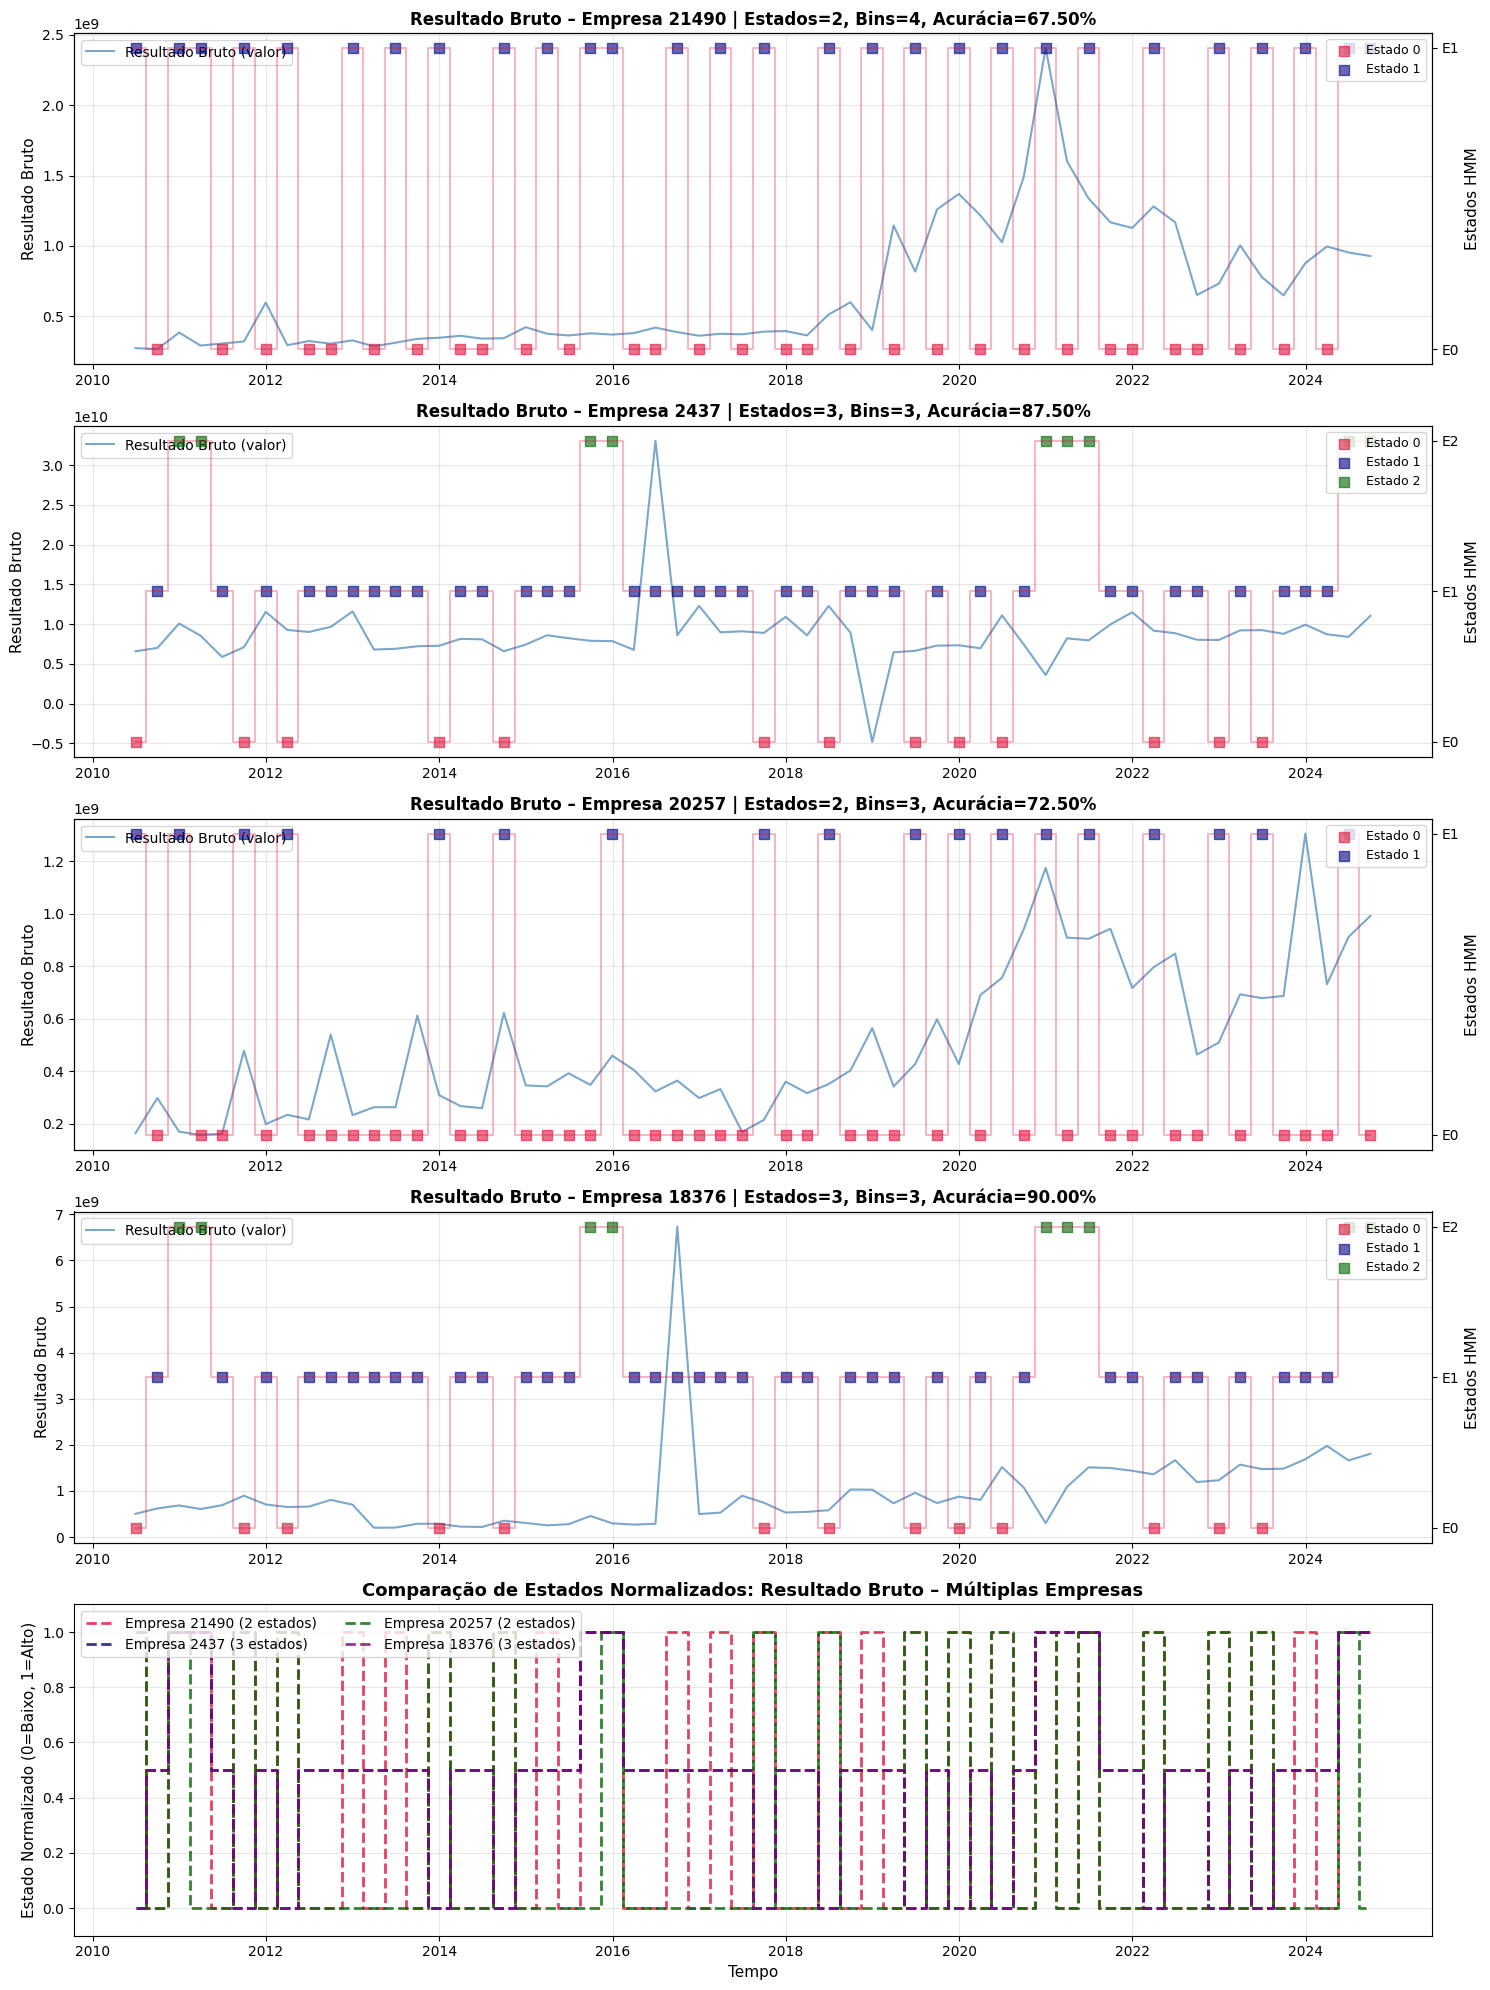


RESUMO COMPARATIVO - Resultado Bruto

--- Melhores Configurações por Empresa ---
Empresa  Estados  Bins  Seed  Acurácia  N_Previsões Convergiu  Log-Likelihood
  18376        3     3     6     0.900           40         ✓      -43.952909
   2437        3     3     6     0.875           40         ✓      -43.952909
  20257        2     3    42     0.725           40         ✓      -43.880851
  21490        2     4     5     0.675           40         ✓      -46.254716

--- Estatísticas Agregadas ---
Acurácia Média: 0.7937
Acurácia Mediana: 0.8000
Acurácia Min/Max: 0.6750 / 0.9000
Desvio Padrão: 0.1106

--- Distribuição de Configurações Vencedoras ---
Estados mais frequentes: [2 3]
Bins mais frequentes: [3]

--- Matrizes de Transição dos Melhores Modelos ---

Empresa 21490 (2 estados):
[[0.301 0.699]
 [0.822 0.178]]

Empresa 2437 (3 estados):
[[0.014 0.743 0.243]
 [0.247 0.383 0.37 ]
 [0.    0.617 0.383]]

Empresa 20257 (2 estados):
[[0.663 0.337]
 [1.    0.   ]]

Empresa 18376 (3 estado

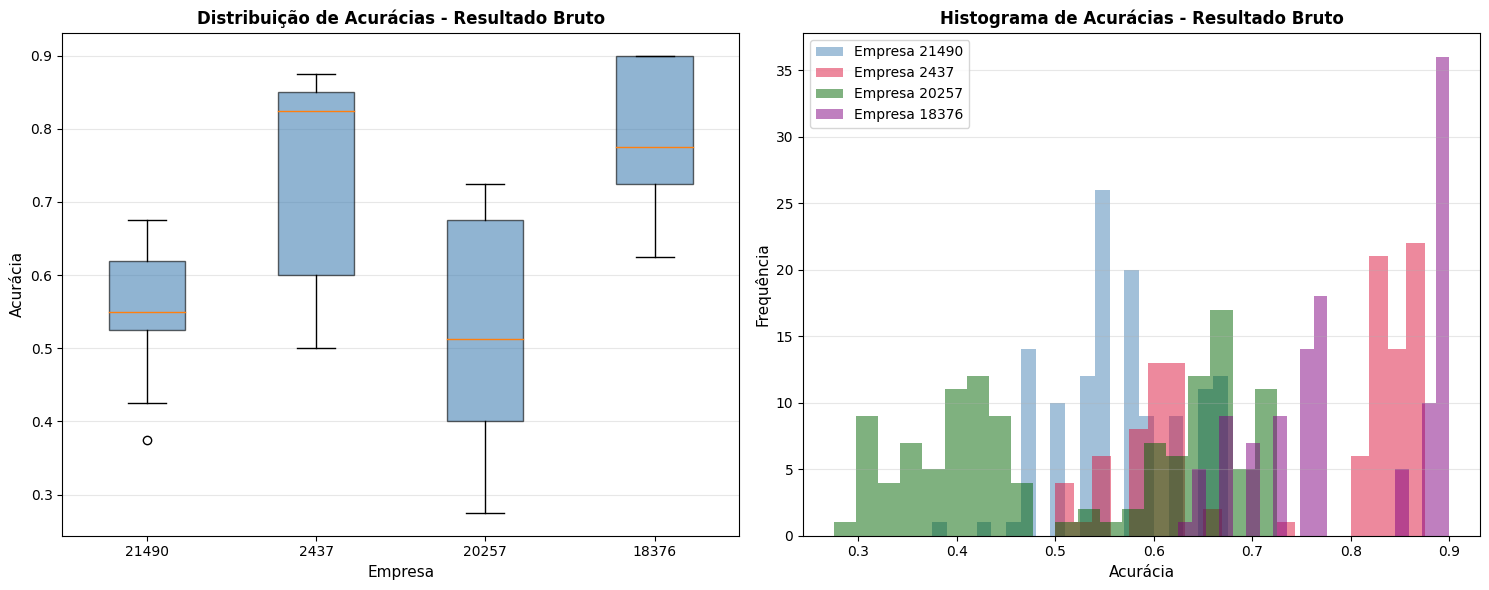


TOP 5 CONFIGURAÇÕES POR EMPRESA

--- Empresa 21490 ---


empresa  n_estados  n_bins  random_state  acuracia  n_previsoes
35   21490          2       4             5     0.675           40
32   21490          2       4             2     0.675           40
30   21490          2       4            12     0.675           40
68   21490          3       4           150     0.675           40
28   21490          2       4            25     0.675           40


--- Empresa 2437 ---


empresa  n_estados  n_bins  random_state  acuracia  n_previsoes
57    2437          3       3             6     0.875           40
60    2437          3       3             8     0.875           40
88    2437          4       3             7     0.875           40
96    2437          4       3             3     0.875           40
84    2437          4       3             1     0.875           40


--- Empresa 20257 ---


empresa  n_estados  n_bins  random_state  acuracia  n_previsoes
1    20257          2       3            42     0.725           40
59   20257          3       3           350     0.725           40
20   20257          2       3            10     0.725           40
19   20257          2       3             9     0.725           40
87   20257          4       3            99     0.725           40


--- Empresa 18376 ---


empresa  n_estados  n_bins  random_state  acuracia  n_previsoes
57   18376          3       3             6       0.9           40
19   18376          2       3             9       0.9           40
88   18376          4       3             7       0.9           40
87   18376          4       3            99       0.9           40
86   18376          4       3             6       0.9           40

In [72]:
# ==========================================
# EXEMPLO DE USO
# ==========================================

# Análise de múltiplas empresas
empresas_analise = ['21490', '2437', '20257', '18376']

print("="*70)
print("GRID SEARCH HMM - RESULTADO BRUTO - MÚLTIPLAS EMPRESAS")
print("="*70)

resultado_grid_empresas = hmm_grid_search_multiplas_empresas(
    empresas_list=empresas_analise,
    indicador_series=resultado_bruto,
    nome_indicador='Resultado Bruto',
    estados_range=(2, 5),        # Testa 2, 3, 4 estados
    bins_range=(3, 5),           # Testa 3, 4 bins
    janela=18,
    n_iter=100  # 6 seeds
)

# Plota distribuição de acurácias
plotar_distribuicao_acuracias(
    resultado_grid_empresas['resultados_empresas'],
    'Resultado Bruto'
)

# Exibe top 5 configurações de cada empresa
print("\n" + "="*70)
print("TOP 5 CONFIGURAÇÕES POR EMPRESA")
print("="*70)

for empresa, df_resultados in resultado_grid_empresas['resultados_empresas'].items():
    print(f"\n--- Empresa {empresa} ---")
    display(df_resultados.head(5))